  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

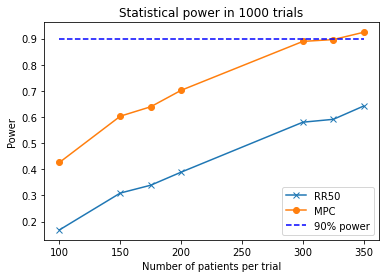

[[0.168 0.426]
 [0.309 0.603]
 [0.339 0.639]
 [0.389 0.702]
 [0.58  0.889]
 [0.591 0.896]
 [0.642 0.924]]


In [1]:
# make a simple picture of trial size vs power

%reload_ext autoreload
%autoreload 2
from weargroup import find_detector_thresh_tester,get_pow
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
#find_detector_thresh_tester()
# 100 was 30%, 300 was 88%
# note: 325 = 90.65%
DRG=0.2
REPS = 1000
Nlist = [100,150,175,200,300,325,350]
plist = np.array([ get_pow(N=Nlist[Ni],numCPUs=9,REPS=REPS,DRG=DRG) for Ni in trange(len(Nlist) )],dtype=float)
plt.plot(Nlist,plist[:,0],'x-',label='RR50')
plt.plot(Nlist,plist[:,1],'o-',label='MPC')
plt.plot([Nlist[0],Nlist[-1]],[.9,.9],'b--',label='90% power')
plt.title(f'Statistical power in {REPS} trials')
plt.xlabel('Number of patients per trial')
plt.ylabel('Power')
plt.legend()
plt.show()
print(plist)

In [ ]:
def do_full_case1_sim_v2(figname,numCPUs=9,REPS=5000,DRG=0.2): 
    T1 = time.time()
    highestN = 1000
    sensSET = [1]
    FARset = [0,1]
  
    fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,5))
    
    #metriclist= ['RR50','MPC']
    metriclist = ['MPC']
    for im,metric_type in enumerate(metriclist):
        #if im==0:
        #Nlist = [75,100,125,150,175,200]
        Nlist = [40,50,60,70,80,90,100]
        
        #else:
        #    Nlist=  [100,200,300,400,500,600,700,800]
            
        for ic,clinTF in enumerate([True,False]):
        
        #ic = 0
            L = len(FARset)*len(sensSET)
            k = pd.DataFrame(np.zeros((L,3)),columns=['FAR','sensitivity','N'])
            ind = 0
            for fi,FAR in enumerate(FARset):
                for si,sensitivity in enumerate(sensSET): 
                    finalN = highestN
                    for N in Nlist:
                        p = get_pow_kind_full(N,numCPUs,REPS,DRG,sensitivity,FAR,clinTF,metric_type)
                        if p>0.9:
                            finalN=N
                            break
                    print(f'FAR={FAR} sensitivity={sensitivity} FinalN={finalN}')
                    k.iloc[ind,:] = [FAR,sensitivity,finalN]
                    #thexy[ind,:] = [FAR,sensitivity,finalN]
                    ind+=1
            k['N'] = k['N'].astype('int')
            #k = pd.DataFrame({'FAR':thexy[0,:],'sensitivity':thexy[1,:],'N':thexy[2,:].astype('int')})
            thispow = k.pivot('FAR','sensitivity','N')
            print(k)
            sns.heatmap(thispow, annot=True,fmt='d',linewidths=0.5, ax=ax[im,ic])
            ax[im,ic].set_title(f'Power Metric={metric_type} clinTF={clinTF}')    
    plt.savefig(figname,dpi=300)
    plt.show()    
    T2 = time.time()
    print(f'Elapsed: {T2-T1}')

In [ ]:
def run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs,im,DRG):
    T1= time.time()
    #lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
    #REPS = 100

    #sensSET = np.linspace(0,1,30)
    #FARset = np.linspace(.1,3,30)
    fig,ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(10,10))
    metriclist= ['RR50','MPC']
    im = 0
    metric = metriclist[im]
    lowest_N = lowest_N_list[im]
    #for im,metric in enumerate(]):
#        
    for ib,clinTF in enumerate([True,False]):
        pow = np.zeros((len(FARset),len(sensSET)))
        xyz = np.zeros((len(FARset)*len(sensSET),3))
        ind = 0
        for i in trange(len(FARset)):
            for j in trange(len(sensSET)):
                pow[i,j] = run1Power_kind(REPS=REPS,numCPUs=numCPUs,minSz=4,N=lowest_N,DRG=DRG,PCB=0,
                    baseline=56,test=84,sensitivity=sensSET[j],FAR=FARset[i],clinTF=clinTF,metric_type=metric)
                xyz[ind,:] = [FARset[i],sensSET[j],pow[i,j]]
                ind+=1

        k = pd.DataFrame(xyz,columns=['FAR','sensitivity','power'])
        thispow = k.pivot('FAR','sensitivity','power')
        sns.heatmap(thispow, annot=True,linewidths=0.5, ax=ax[ib]).set(
            title=f'Power Metric={metric} clinTF={clinTF}')
    plt.show()
    T2= time.time()
    print(f'total time = {T2-T1}')
    
REPS=5000
#lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
lowest_N_list = [325,50]  # the lowest N for getting 90% power with these parameters

sensSET = [.01, .5, .99]
FARset = [.6, .8, .9]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=0,DRG=0.3)


#######



REPS=1000
#lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters

sensSET = [0,.25,.5,.75,1]
FARset = [.6,.7,.8,1]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=1,DRG=0.3)


###

REPS=500
#lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
lowest_N_list = [700,350]  # the lowest N for getting 90% power with these parameters

sensSET = [0,.25,.5,.75,1]
FARset = [.4,.5,.6]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=0,DRG=0.2)

#REPS=5000

sensSET = [0,.25,.5,.75,1]
FARset = [.4,.5,.6]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=1,DRG=0.2)

###

REPS=5000
#lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
lowest_N_list = [700,350]  # the lowest N for getting 90% power with these parameters

sensSET = [0,.25,.5,.75,1]
FARset = [.4,.5,.6]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=0,DRG=0.2)

#REPS=5000

sensSET = [0,.25,.5,.75,1]
FARset = [.4,.5,.6]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=1,DRG=0.2)

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import run1Power_kind,run1trial_kind,build_a_kind_of_diary
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
T1= time.time()
lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
REPS = 1000

sensSET = np.linspace(0,1,30)
FARset = np.linspace(.1,3,30)
fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))
for im,metric in enumerate(['RR50','MPC']):
    lowest_N = lowest_N_list[im]
    for ib,clinTF in enumerate([True,False]):
        pow = np.zeros((len(FARset),len(sensSET)))
        xyz = np.zeros((len(FARset)*len(sensSET),3))
        ind = 0
        for i in trange(len(FARset)):
            for j in trange(len(sensSET)):
                pow[i,j] = run1Power_kind(REPS=REPS,numCPUs=9,minSz=4,N=lowest_N,DRG=0.3,PCB=0,
                    baseline=56,test=84,sensitivity=sensSET[j],FAR=FARset[i],clinTF=clinTF,metric_type=metric)
                xyz[ind,:] = [FARset[i],sensSET[j],pow[i,j]]
                ind+=1

        k = pd.DataFrame(xyz,columns=['FAR','sensitivity','power'])
        thispow = k.pivot('FAR','sensitivity','power')
        sns.heatmap(thispow, annot=True,linewidths=0.5, ax=ax[im,ib]).set(
                title=f'Power Metric={metric} clinTF={clinTF}')
plt.show()
T2= time.time()
print(f'total time = {T2-T1}')

In [2]:
import pandas as pd
import seaborn as sns
x = FARset
y = sensSET

xyz = np.zeros((len(FARset)*len(sensSET),3))
ind = 0
for i in range(len(FARset)):
    for j in range(len(sensSET)):
        xyz[ind,:] = [FARset[i],sensSET[j],pow[i,j]]
        ind+=1
k = pd.DataFrame(xyz,columns=['FAR','sensitivity','power'])
thispow = k.pivot('FAR','sensitivity','power')
sns.heatmap(thispow, annot=True,linewidths=0.5)

NameError: name 'FARset' is not defined

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import find_detector_thresh_tester

def find_detector_thresh_tester():
    numCPUs = 9
    baseline = 56
    test = 84
    numCPUs = 9
    minSz=8
    howmanydays = baseline+test
    DRG=0.3
    PCB=0.0
    REPS = 1000

    Nlist = np.linspace(100,500,17)
    for plotx,metric_type in enumerate(['MPC','RR50']):
        for ploty,clinTF in enumerate([True,False]):
            
            # figure out minimum N for 90% power with obs
            pows = [ get_pow(N,metric_type,numCPUs) for N in Nlist ]
            goodOnes = Nlist[pows>0.9]
            lowest_N = goodOnes[0]
            print(f'metric={metric_type}, clinTF={clinTF}, lowestN={lowest_N}')
            
def get_pow(N,numCPUs,REPS,DRG):
    # INPUTS:
    # N - total number of patients
    # metric_type - 'MPC' or 'RR50'
    # numCPUs 
    #
    # OUTPUTS:
    #  pow = the % of trials that successfully distinguish drug from placebo
    #
    minSz = 4
    #DRG = 0.3
    PCB = 0.0
    baseline = 56
    test = 84

    #REPS = 10000
    
    if numCPUs == 1:
        plist = [get_one_pow(N,minSz,DRG,PCB,baseline,test) for _ in trange(REPS)]
    else:
        with Parallel(n_jobs=numCPUs, verbose=False) as par:
            plist = par(delayed(get_one_pow)(N,minSz,DRG,PCB,baseline,test) for _ in trange(REPS))
    plist = np.array(plist,dtype=float)
    pow = np.mean(plist<0.05,axis=0)
    return pow


import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
#find_detector_thresh_tester()
# 100 was 30%, 300 was 88%
# note: 325 = 90.65%
DRG=0.2
REPS = 5000
Nlist = [200,300,325,350,400,600,650,700,750,800]
plist = np.array([ get_pow(N=Nlist[Ni],numCPUs=9,REPS=REPS,DRG=DRG) for Ni in trange(len(Nlist) )],dtype=float)
plt.plot(Nlist,plist[:,0],'x-',label='RR50')
plt.plot(Nlist,plist[:,1],'o-',label='MPC')
plt.plot([Nlist[0],Nlist[-1]],[.9,.9],'b--',label='90% power')
plt.title(f'Statistical power in {REPS} trials')
plt.xlabel('Number of patients per trial')
plt.ylabel('Power')
plt.legend()
plt.show()
print(plist)
# conclusion: 350 for MPC,700 for RR50

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import find_detector_thresh_tester,get_pow_kind_full
import numpy as np
from tqdm.notebook import trange, tqdm
import seaborn as sns
import time
import matplotlib.pyplot as plt
import pandas as pd
numCPUs=9
REPS=5000
DRG=0.2
sensitivity=1
FAR=0
#clinTF=True
#metric_type='MPC'
sensSET = [.33,.66,1]
FARset = [0,.2,.4]
#sensSET = [.5]
#FARset = [.4]

#Nlist= np.linspace(100,900,17).astype('int')


fig,ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(10,10))
metriclist= ['RR50','MPC']
for im,metric_type in enumerate(metriclist):
    if im==1:
        Nlist = [75,100,125,150,175,200]
    else:
        Nlist=  [100,200,300,400,500,600,700,800]
        
    for ic,clinTF in enumerate([True,False]):
    #ic = 0
        thexy = np.zeros((len(FARset)*len(sensSET),3))
        ind = 0
        for fi,FAR in enumerate(FARset):
            for si,sensitivity in enumerate(sensSET): 
                for N in Nlist:
                    p = get_pow_kind_full(N,numCPUs,REPS,DRG,sensitivity,FAR,clinTF,metric_type)
                    if p>0.9:
                        finalN=N
                        break
                print(f'FAR={FAR} sensitivity={sensitivity} FinalN={finalN}')
                thexy[ind,:] = [FAR,sensitivity,finalN]
                ind+=1
                
        k = pd.DataFrame(thexy,columns=['FAR','sensitivity','power'])
        thispow = k.pivot('FAR','sensitivity','power')
        sns.heatmap(thispow, annot=True,fmt='d',linewidths=0.5, ax=ax[ic]).set(
            title=f'Power Metric={metric_type} clinTF={clinTF}')    
    plt.show()    

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import do_full_case1_sim
from realSim import downsample
number_of_years = 10
num_patients = 10000
sampRATE = 1
howmanydays = sampRATE*30*12*number_of_years
sensitivity = 0.8
FAR = 0.2
clinTF = True
conservativeClinician = 0.8
for N in range(num_patients):
    true_e_diary, true_clin_diary, observed_clin_diary, detector_e_diary, detector_clin_diary=build_full_set_of_diaries(sampRATE,howmanydays,clin_sensitivity,clin_FAR,e_sensitivity,e_FAR)
    
    diary = build_a_kind_of_diary(sampRATE,howmanydays,sensitivity,FAR,clinTF)
    chunks = downsample(diary,90)
    L = len(chunks)
    noChange = 0
    druglist = np.zeros(L)
    
    for i in range(L):
        
        if i==0:
            noChange=1
        else:
            thisChunk = chunks[i]
            lastChunk = chunks[i-1]
            if (thisChunk==0) or (thisChunk <= lastChunk*0.5):
                noChange+=1
            else:
                # there are >= 50% seizures this time vs last. Need a change maybe
                noChange=0
                if np.random.random()<conservativeClinician:
                    # the conservative clinician would be inclined to add med
                    druglist[i] += 1
                    
            if noChange==24:
                # REMOVE DRUG, because no change in 2 years
                druglist[i] = np.max([0,i-1])
            
            

In [ ]:
# try the same with much less subtypes
%reload_ext autoreload
%autoreload 2
from weargroup import get_pow_kind_full,run1trial_kind,makeTrial_kind,getPC
import time
theN = 70
DRG = 0.2
reps = 100
for theN in [20,30,40]:
    d1 = np.zeros(reps)
    for K in range(reps):
        trialData = makeTrial_kind(minSz=4,N=theN,DRG=DRG,PCB=0,baseline=56,test=84,sensitivity=1,FAR=0,clinTF=True)
        PC1 = getPC(trialData,baseline=56,test=84)
        P1 = np.median(PC1[:int(theN/2)])
        P1d = np.median(PC1[int(theN/2):])
        d1[K] = P1d-P1
    d2 = np.zeros(reps)
    for K in range(reps):
        trialData = makeTrial_kind(minSz=4,N=theN,DRG=DRG,PCB=0,baseline=56,test=84,sensitivity=1,FAR=0,clinTF=False)
        PC2 = getPC(trialData,baseline=56,test=84)
        P2 = np.median(PC2[:int(theN/2)])
        P2d = np.median(PC2[int(theN/2):])
        d2[K] = P2d-P2
    print(f'N = {theN} P1 = {np.mean(d1)} P2 = {np.mean(d2)}')

if 0:
    pF = run1trial_kind(minSz=4,N=theN,DRG=DRG,PCB=0, baseline=56,test=84,sensitivity=1,FAR=0,clinTF=False,metric_type='MPC')
    pT = run1trial_kind(minSz=4,N=theN,DRG=DRG,PCB=0, baseline=56,test=84,sensitivity=1,FAR=0,clinTF=True,metric_type='MPC')
    print(f'pF = {pF:0.2} pT = {pT:0.2}')
if 0:
    T1 = time.time()
    p = get_pow_kind_full(N=theN,numCPUs=9,REPS=5000,DRG=0.4,sensitivity=1,FAR=0,clinTF=True,metric_type='MPC')
    T2 = time.time()
    print(f'Clinical   p={p:0.2} time = {T2-T1}')
    if 0:
        p = get_pow_kind_full(N=theN,numCPUs=9,REPS=5000,DRG=0.2,sensitivity=0.5,FAR=0,clinTF=True,metric_type='MPC')
        T2 = time.time()
        print(f'Sens = 0.5  p={p:0.2} time = {T2-T1}')
        p = get_pow_kind_full(N=theN,numCPUs=9,REPS=5000,DRG=0.2,sensitivity=1,FAR=2,clinTF=True,metric_type='MPC')
        T2 = time.time()
        print(f'FAR = 2   p={p:0.2} time = {T2-T1}')
    p = get_pow_kind_full(N=theN,numCPUs=9,REPS=5000,DRG=0.2,sensitivity=1,FAR=0,clinTF=False,metric_type='MPC')
    T2 = time.time()
    print(f'clin=FALSE   p={p:0.2} time = {T2-T1}')


In [ ]:


def find_detector_thresh():
    numCPUs = 9
    baseline = 56
    test = 84
    numCPUs = 9
    minSz=8
    howmanydays = baseline+test
    DRG=0.3
    PCB=0.0
    REPS = 1000
    fig, ax = plt.subplots(2, 2,figsize=(12,8))

    Nlist = np.linspace(100,500,17)
    for plotx,metric_type in enumerate(['MPC','RR50']):
        for ploty,clinTF in enumerate([True,False]):
            
            # figure out minimum N for 90% power with obs
            pows = [ get_pow(N,metric_type,numCPUs) for N in Nlist ]
            goodOnes = Nlist[pows>0.9]
            lowest_N = goodOnes[0]
            
            # sequence through detector sensitivities to reach 90%
            sensitivity_sweep = np.linspace(50,100,26)
            FAR_sweep = np.linspace(0,1,26)
            powgrid = np.zeros((sensitivity_sweep.shape[0],FAR_sweep.shape[0]))
            for a,device_sens in enumerate(sensitivity_sweep):
                for b,FAR in enumerate(FAR_sweep):
                    powgrid[a,b] = run1Power_kind(REPS,numCPUs,minSz,lowest_N,DRG,PCB,baseline,test,device_sens,FAR,clinTF,metric_type)
            ax[plotx,ploty].imshow(powgrid, extent=[0, 1, 0, 1])
            ax[plotx,ploty].title(f'Using metric {metric_type} and clinTF={clinTF}')
    fig.supxlabel('Sensitivity')
    fig.supylabel('FAR')

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

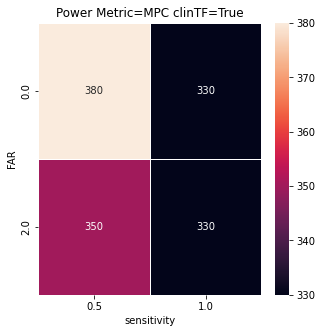

Time = 4416.036698102951


In [25]:
%reload_ext autoreload
%autoreload 2
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import do_simple_case1_sim
do_simple_case1_sim(clinTF=True)


FAR:   0%|          | 0/2 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

N:   0%|          | 0/12 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

N:   0%|          | 0/12 [00:00<?, ?it/s]

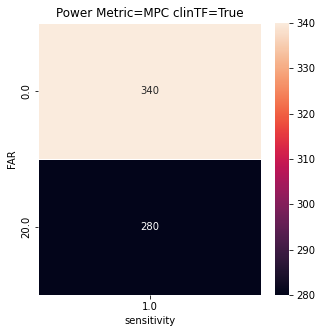

Time = 4124.941466808319


In [7]:
%reload_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import do_simple_case1_sim
#do_simple_case1_sim(figname='MPCclinFALSE',clinTF=False)
do_simple_case1_sim(figname='MPCclinTRUE',clinTF=True,sensLIST = [1],FARlist = [0,20])


FAR:   0%|          | 0/2 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

N:   0%|          | 0/13 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

N:   0%|          | 0/13 [00:00<?, ?it/s]

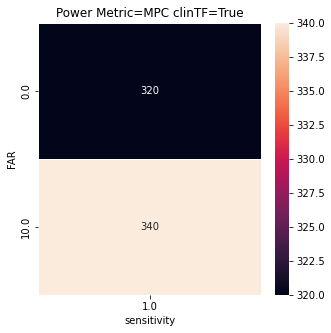

Time = 11193.81279373169


In [10]:
%reload_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import do_simple_case1_sim
#do_simple_case1_sim(figname='MPCclinFALSE',clinTF=False)
do_simple_case1_sim(figname='MPCclinTRUE',clinTF=True,REPS=10000,sensLIST = [1],FARlist = [0,10])


FAR:   0%|          | 0/1 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

N:   0%|          | 0/13 [00:00<?, ?it/s]

N:   0%|          | 0/13 [00:00<?, ?it/s]

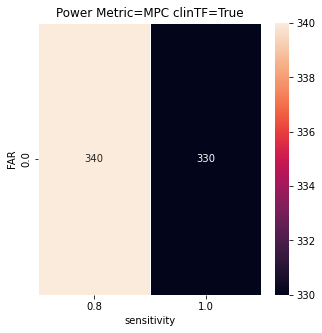

Time = 12918.39755320549


In [13]:
%reload_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import do_simple_case1_sim
#do_simple_case1_sim(figname='MPCclinFALSE',clinTF=False)
do_simple_case1_sim(figname='MPCclinTRUEsens2',clinTF=True,REPS=10000,sensLIST = [1,.8],FARlist = [0])


In [15]:
%reload_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import do_simple_case1_sim
clinTF = True
whatmetric = 'RR50'
#for clinTF in [True,False]:
#for whatmetric in ['RR50','MPC']:
do_simple_case1_sim(figname=f'{whatmetric}_clinTF{clinTF}_big10k',numCPUs=9,REPS=10000,clinTF=clinTF,FARlist=[0,10],sensLIST=[0.5,1],metric_type=whatmetric)


[autoreload of _frozen_importlib failed: Traceback (most recent call last):
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/importlib/__init__.py", line 166, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
AttributeError: module 'importlib._bootstrap' has no attribute '_find_spec'
]
[autoreload of _frozen_importlib_external failed: Traceback (most recent call last):
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/danielgoldenholz/minifor

AttributeError: module 'linecache' has no attribute '_ipython_cache'

In [8]:
%reload_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import build_many_cases
maxTrials = 10000
maxN = 2000
E,O = build_many_cases(numCPUs=9,trials=maxTrials,maxN=maxN,baseline=2,test=3,DRG=0.2)
print('Saving E...')
np.save(f'ePatients{maxTrials}-by-{maxN}.npy',E)
print('Saving O...')
np.save(f'oPatients{maxTrials}-by-{maxN}.npy',O)

  0%|          | 0/20000000 [00:00<?, ?it/s]

Saving E...
Saving O...


In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np

from weargroup import build_many_cases,apply_drug_bulk,make_one_pt_months

from realSim import get_mSF, simulator_base,downsample
from trialSimulator import runSet, applyDrug,makeTrial_defaults,getPC
from trialSimulator import calculate_fisher_exact_p_value, calculate_MPC_p_value
from joblib import Parallel, delayed
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pandas as pd
from numpy.random import default_rng
import scipy.stats as stats

In [40]:



np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  

maxTrials = 10000
maxN = 2000
REPS = maxTrials*maxN
baseline = 2
test = 3 
trialDur = baseline+test
DRG =0.2
numCPUs=9

def make_one_clin():
    sampRATE = 1
    howmanydays = 28*trialDur
    #ediary,trueclin = make_multi_diaries(sampRATE,howmanydays,makeOBS=False)
    trueclin = simulator_base(sampRATE=sampRATE,number_of_days=howmanydays)
    #ediaryM = downsample(ediary,28)
    trueclinM = downsample(trueclin,28)
    return trueclinM

with Parallel(n_jobs=numCPUs, verbose=False) as par:
    EandC = par(delayed(make_one_pt_months)(trialDur) for _ in trange(REPS))
#    EandC = par(delayed(make_one_clin)() for _ in trange(REPS))
arr = np.array(EandC,dtype=int)
EandC = np.reshape(arr,newshape=(maxTrials,maxN,trialDur*2))
E = EandC[:,:,0:trialDur]
E = apply_drug_bulk(E,maxN,efficacy=DRG,baseline=baseline)
C = EandC[:,:,trialDur:]
C = apply_drug_bulk(C,maxN,efficacy=DRG,baseline=baseline)
    
#E = np.reshape(arr,newshape=(maxTrials,maxN,trialDur))
#Ed = apply_drug_bulk(E,maxN,efficacy=DRG,baseline=baseline)

print('Saving E...')
np.save(f'ePatients{maxTrials}-by-{maxN}.npy',E)
print('Saving O...')
np.save(f'oPatients{maxTrials}-by-{maxN}.npy',C)

  0%|          | 0/20000000 [00:00<?, ?it/s]

TypeError: list indices must be integers or slices, not tuple

In [51]:
print('Saving E...')
np.save(f'ePatients{maxTrials}-by-{maxN}.npy',E)
print('Saving O...')
np.save(f'oPatients{maxTrials}-by-{maxN}.npy',C)

Saving E...
Saving O...


In [53]:
O = C.copy()


  0%|          | 0/56 [00:00<?, ?it/s]

1575


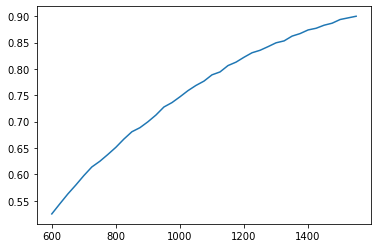

In [19]:
from weargroup import get_pows_given_n


#Ed = apply_drug_bulk(E,maxN,efficacy=0.2,baseline=baseline)

maxTrials = 10000
maxN = 2000
REPS = maxTrials*maxN
baseline = 2
test = 3 
trialDur = baseline+test
DRG =0.2
numCPUs=9

sens = 1
FAR = 0
highestN = 4000
rng = default_rng()
xdata = O.copy()
#account for sensitivity
xdata = np.round(xdata*sens)
#account for FAR
#if FAR>0:
added_sz = np.round(np.random.randn(maxTrials,maxN,trialDur)+28*FAR).astype('int')
added_sz[added_sz<0] =0
xdata += added_sz

B = np.sum(xdata[:,:,:baseline],axis=2) / baseline
T = np.sum(xdata[:,:,baseline:],axis=2) / test
np.seterr(divide='ignore',invalid='ignore')
PC = 100*np.divide((B-T),B)
#print(f'Number of PC nan = {np.sum(np.isnan(PC[:]))}')
RR50 = (PC>=50)+0.0


finalN = highestN
Nlist = np.arange(600,maxN,25)
plist = np.zeros(len(Nlist))
for ni,N in enumerate(tqdm(Nlist)):
    p = get_pows_given_n(maxN,N,maxTrials,PC,mpcTF=True,rng=rng,numCPUs=numCPUs)
    plist[ni] = p
    if p>0.9:
        finalN=N
        break
plt.plot(Nlist[:ni],plist[:ni])
print(finalN)                    

In [2]:
import numpy as np
maxTrials = 10000
maxN = 4000
print(' E...')
E = np.load(f'ePatients{maxTrials}-by-{maxN}.npy')
print(' O...')
O = np.load(f'oPatients{maxTrials}-by-{maxN}.npy')
print('ready.')

 E...
 O...
ready.


sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

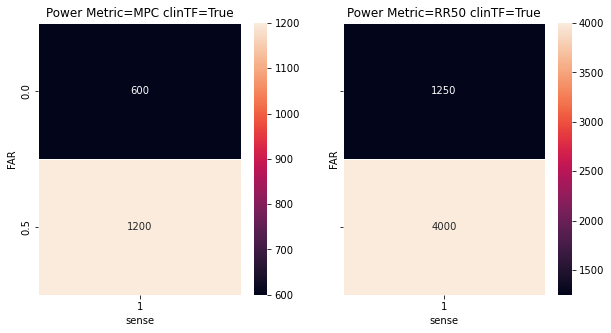

In [72]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
tryAllClin(E,[1],[0,.5])
#tryAllClin(O,[.5,.8,1],[0])


  0%|          | 0/40000000 [00:00<?, ?it/s]

Saving E...
Saving O...


sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

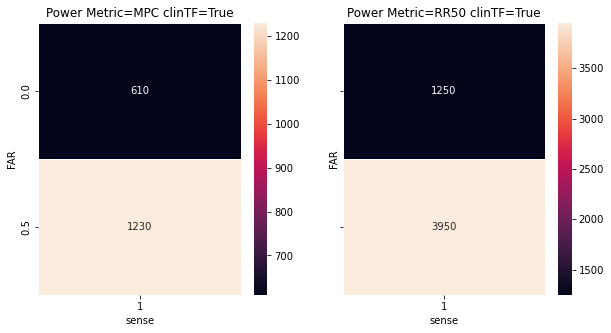

In [73]:
%reload_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import build_many_cases
maxTrials = 10000
maxN = 4000
E,O = build_many_cases(numCPUs=9,trials=maxTrials,maxN=maxN,baseline=2,test=3,DRG=0.2)
print('Saving E...')
np.save(f'ePatients{maxTrials}-by-{maxN}.npy',E)
print('Saving O...')
np.save(f'oPatients{maxTrials}-by-{maxN}.npy',O)




sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

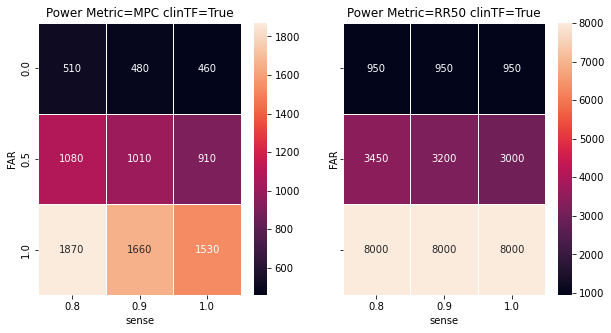

In [74]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
tryAllClin(E,[0.8,.9,1],[0,.5,1],maxPOW=.8)

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

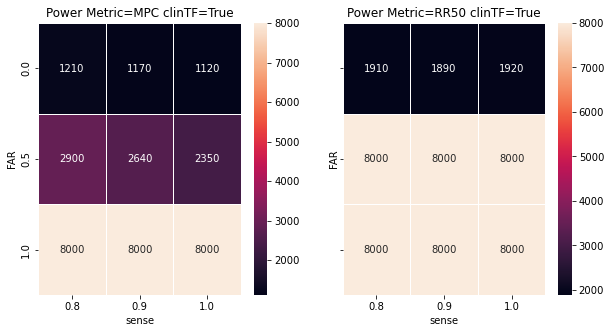

In [75]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
tryAllClin(O,[0.8,.9,1],[0,.5,1],maxPOW=.8)

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

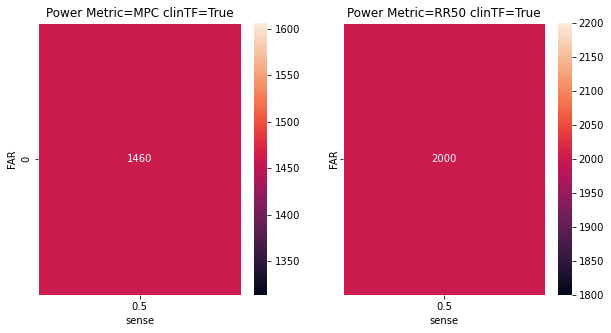

In [76]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
# This represents clinical trials
tryAllClin(O,[0.5],[0],maxPOW=.8)

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

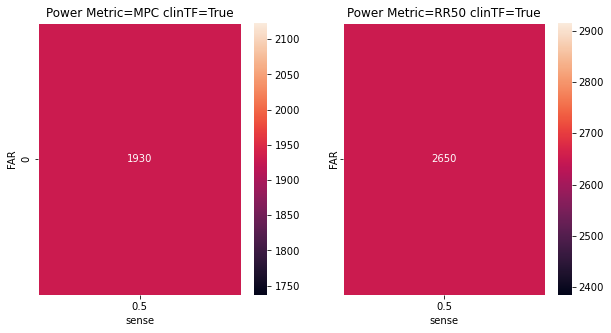

In [77]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
# This represents clinical trials
tryAllClin(O,[0.5],[0],maxPOW=.9)

sens:   0%|          | 0/5 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

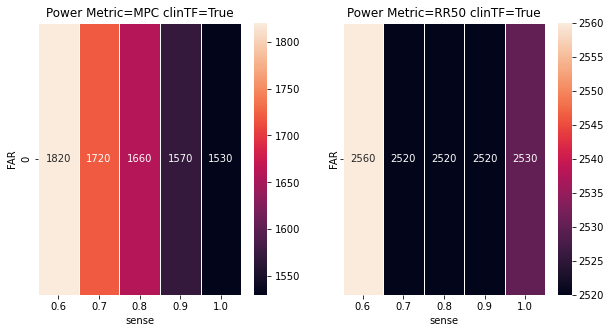

In [78]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
# This represents clinical trials
tryAllClin(O,[.6,.7,.8,.9,1],[0],maxPOW=.9)

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

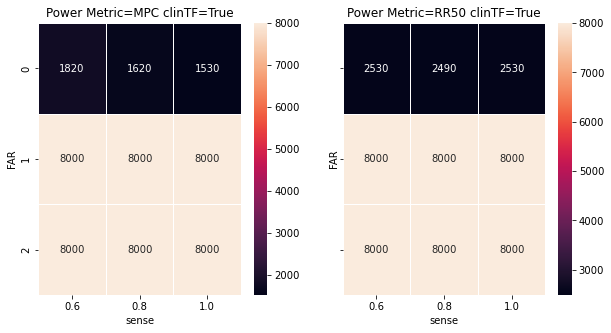

In [79]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
# This represents clinical trials
tryAllClin(O,[.6,.8,1],[0,1,2],maxPOW=.9)

sens:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

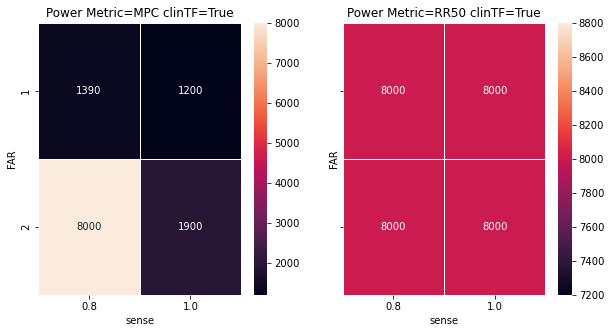

In [86]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.8,1]
FARlist = [1,2]
maxTrials = 10000
maxN = 4000
premake_clin(E,sensLIST,FARlist,f'E-{maxTrials}-by-{maxN}',numCPUs=9)
tryAllClin(maxN,maxTrials,sensLIST,FARlist,f'E-{maxTrials}-by-{maxN}',maxPOW=.9)

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

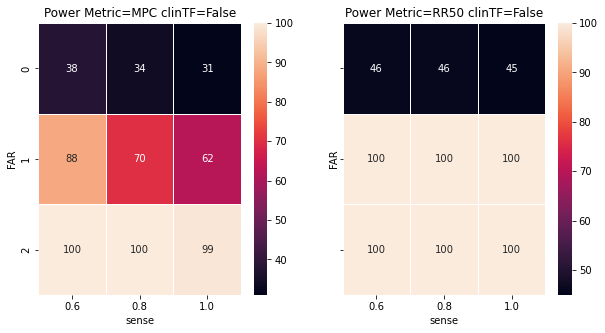

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

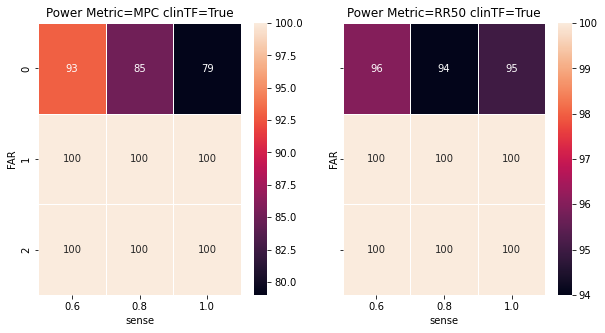

In [90]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [0,1,2]
maxTrials = 10000
maxN = 4000
#premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=False,numCPUs=9)
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=False,maxPOW=.9)
#premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=False,numCPUs=9)
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=True,maxPOW=.9)


the above was 0.9. Will try maxPOW 0.8

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

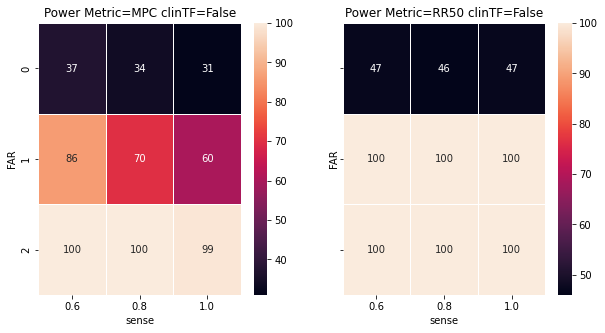

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

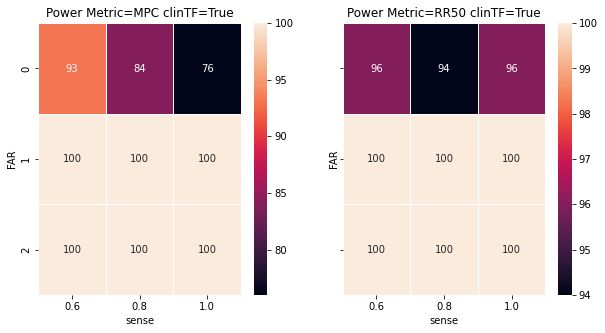

In [91]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [0,1,2]
maxTrials = 10000
maxN = 4000
#premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=False,numCPUs=9)
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=False,maxPOW=.8)
#premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=True,numCPUs=9)
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=True,maxPOW=.8)


The above was built using FAR*sampRATE/4 s.d.
if we lower the s.d, it will look nicer. maybe. Set s.d=1

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

now maxPOW={maxPOW}


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

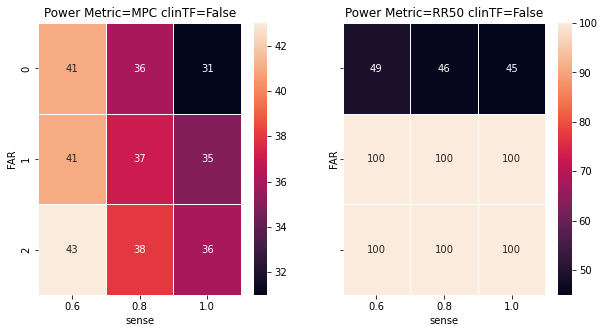

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

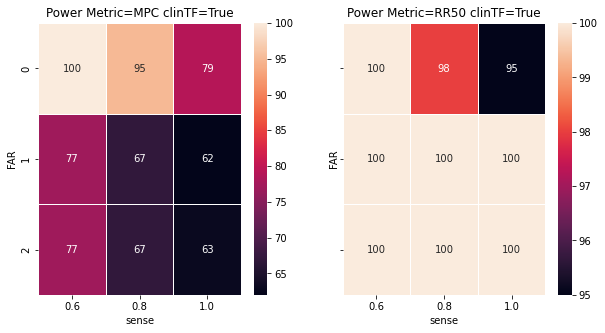

now maxPOW={maxPOW}


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

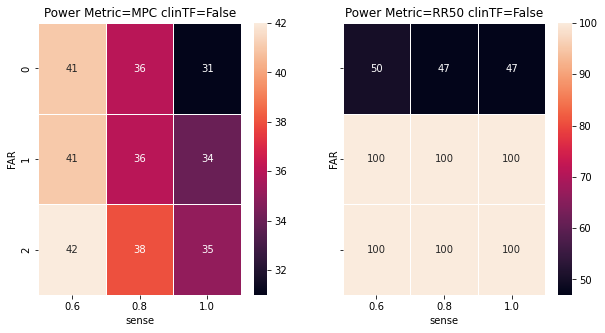

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

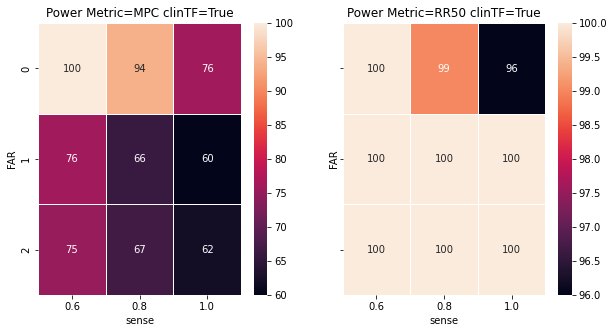

In [95]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [0,1,2]
maxTrials = 10000
maxN = 4000

clinTF = False
premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)
clinTF = True
premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)

maxPOW = 0.9
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,maxPOW=maxPOW)

maxPOW = 0.8
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,maxPOW=maxPOW)



In [3]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [0,1,2]
maxTrials = 10000
maxN = 4000

clinTF = False
premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)
clinTF = True
premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)

maxPOW = 0.9
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinF.csv',maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinT.csv',maxPOW=maxPOW)


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

now maxPOW=0.9


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

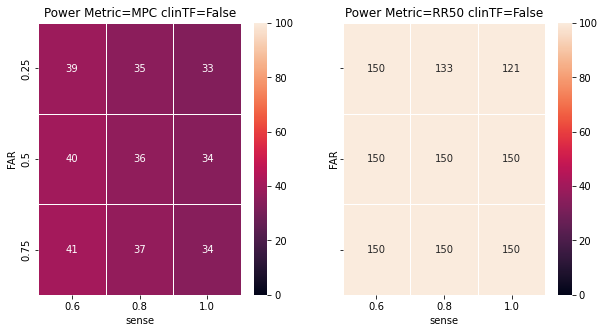

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

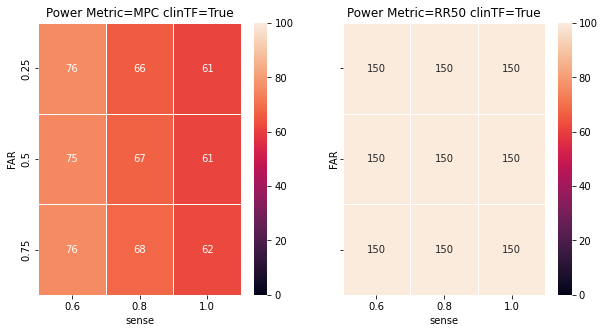

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [.25,.5,.75]
maxTrials = 10000
maxN = 4000

clinTF = False
premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)
clinTF = True
premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)

maxPOW = 0.9
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinFsmallFAR.csv',maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinTsmallFAR.csv',maxPOW=maxPOW)


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

now maxPOW=0.9


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

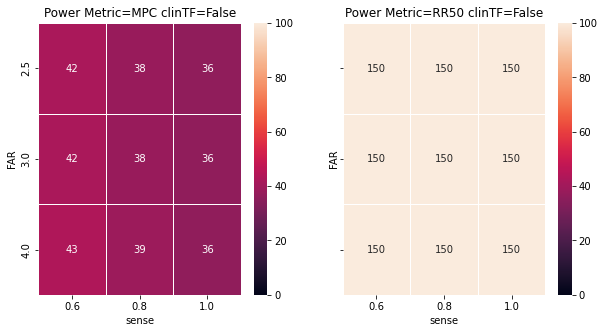

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

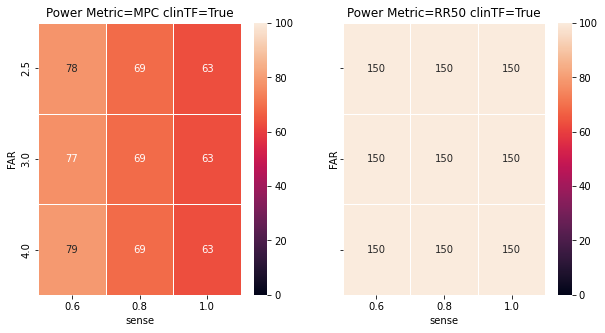

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [2.5,3,4]
maxTrials = 10000
maxN = 4000

clinTF = False
premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)
clinTF = True
premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)

maxPOW = 0.9
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinFbigFAR.csv',maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinTbigFAR.csv',maxPOW=maxPOW)


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

now maxPOW=0.9


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

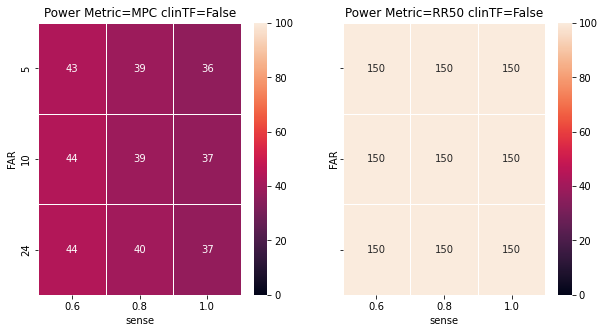

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

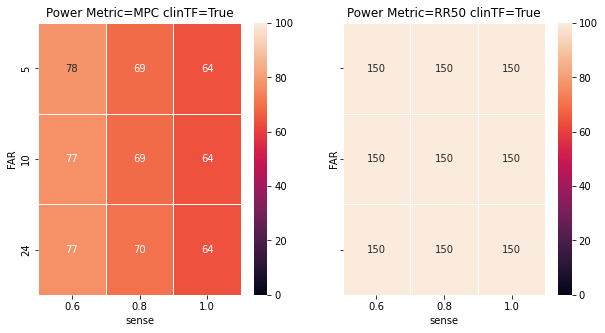

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [5,10,24]
maxTrials = 10000
maxN = 4000

clinTF = False
premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)
clinTF = True
premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)

maxPOW = 0.9
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinFbiggerFAR.csv',maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinTbiggerFAR.csv',maxPOW=maxPOW)


 E...
 O...
ready.


sens:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

now maxPOW=0.9


sens:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

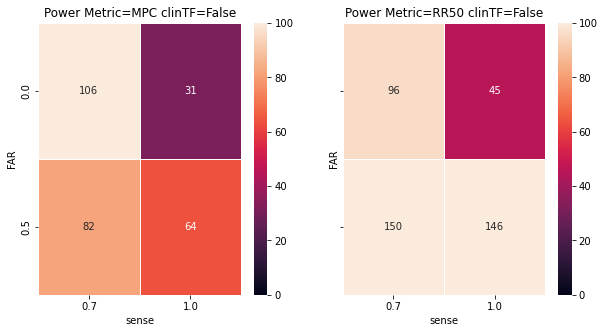

sens:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup import tryAllClin,premake_clin
# This represents clinical trials

maxTrials = 10000
maxN = 4000
print(' E...')
E = np.load(f'ePatients{maxTrials}-by-{maxN}.npy')
print(' O...')
O = np.load(f'oPatients{maxTrials}-by-{maxN}.npy')
print('ready.')

sensLIST = [0.7,1]
FARlist = [0,.5]
maxTrials = 10000
maxN = 4000

clinTF = False
premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)
clinTF = True
premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)

maxPOW = 0.9
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinF.csv',maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinT.csv',maxPOW=maxPOW)

the above used 0.25 for cutdown. below I try 0.1

 E...
 O...
ready.


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

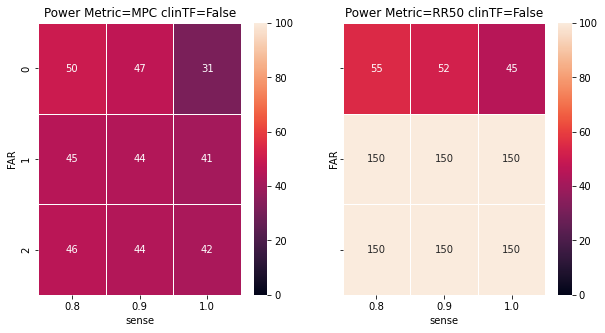

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup import do_a_clin_set

do_a_clin_set(sensLIST=[0.8,.9,1],FARlist=[2,1,0],
              csvFN='grid3',doPremake=True)

the above was cutdown 0.1. This looks bad.


 E...
 O...
ready.


sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

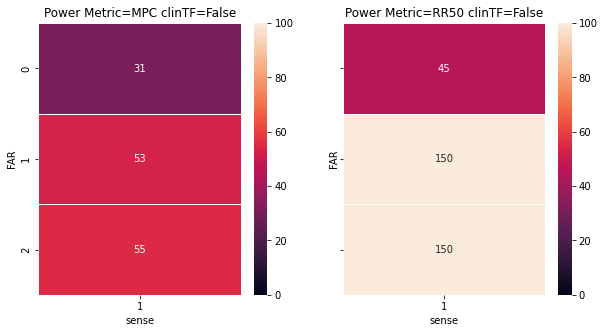

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

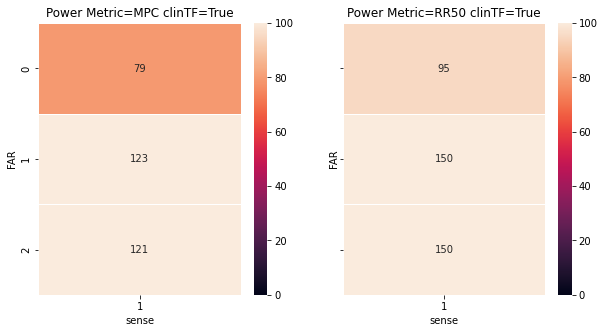

In [6]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup import do_a_clin_set

do_a_clin_set(sensLIST=[1],FARlist=[2,1,0],
              csvFN='grid3',doPremake=True)

nope. This is not working for us.



  0%|          | 0/40000000 [00:00<?, ?it/s]

Saving E...
Saving O...
Done.
 E...
 O...
ready.


sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

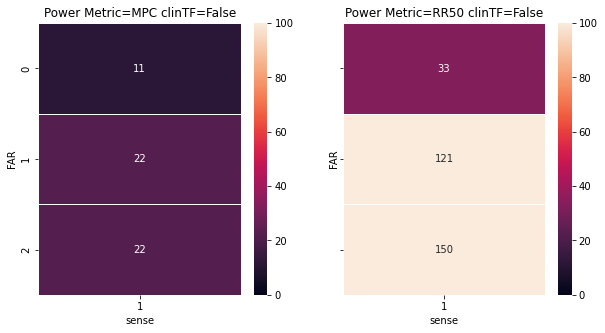

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

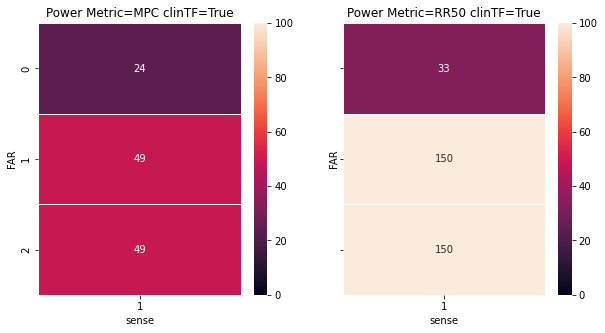

In [7]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup import do_a_clin_set

from weargroup import build_many_cases
maxTrials = 10000
maxN = 4000
DRG = 0.3
filePREFIX = f'Patients30'
E,O = build_many_cases(numCPUs=9,trials=maxTrials,maxN=maxN,baseline=2,test=3,DRG=0.3)
print('Saving E...')
np.save(f'e{filePREFIX}{maxTrials}-by-{maxN}.npy',E)
print('Saving O...')
np.save(f'o{filePREFIX}{maxTrials}-by-{maxN}.npy',O)
print('Done.')

do_a_clin_set(sensLIST=[1],FARlist=[2,1,0],
              csvFN='grid3',doPremake=True,filePREFIX=filePREFIX)

In [12]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import tryManyTrials

obsPows,allPows = tryManyTrials(numCPUs=9,N=100,REPS=9,
    sensLIST=[0.8,1],farLIST=[0])


obs:   0%|          | 0/9 [00:00<?, ?it/s]

doinbg the grid


reps:   0%|          | 0/9 [00:00<?, ?it/s]

reps:   0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import build_a_trial,get_a_patient,findThresh
pow = findThresh(numCPUs=9,REPS=10000,maxN=1000,DRG=0.2,PCB=0,minSz=4,
           baseline=2,test=3,clinTF=True,sensitivity=1,FAR=0,metricMPC_TF=True)
print(pow)


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating PCs = 1114.2660341262817


findthresh:   0%|          | 0/9 [00:00<?, ?it/s]

Thresh N = thisN
Calculating wins = 7.28769326210022
900


In [47]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import build_a_trial,get_a_patient,findThresh
tRR,tMP = findThresh(fn='PC_sens0.5_FAR0_10k_4k.npy',numCPUs=9,REPS=10000,maxN=4000,DRG=0.2,PCB=0,minSz=4,
           baseline=2,test=3,clinTF=True,sensitivity=0.5,FAR=0,metricMPC_TF=True)
print(f'Threshold RR50 = {tRR} Threshold MPC = {tMP}')

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 97.0 minutes
Saving....


findthresh:   0%|          | 0/390 [00:00<?, ?it/s]

Thresh N = thisN
Calculating wins = 4.0 minutes


findthresh:   0%|          | 0/390 [00:00<?, ?it/s]

Thresh N = thisN
Calculating wins = 6.0 minutes
Threshold RR50 = 2760 Threshold MPC = 2590


this seems WAY too high. will repeat, but use a lower max.
On the other hand, since self-report is so imperfect, maybe this is an important point that huge numbers are typically needed.
Conversely, maybe this means that self-report must be higher, since most studies are much smaller and still figure out good drugs.

In [48]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import build_a_trial,get_a_patient,findThresh
tRR,tMP = findThresh(fn='PC_sens0.5_FAR0_10k_2.9k.npy',numCPUs=9,REPS=10000,maxN=2900,DRG=0.2,PCB=0,minSz=4,
           baseline=2,test=3,clinTF=True,sensitivity=0.5,FAR=0,metricMPC_TF=True)
print(f'Threshold RR50 = {tRR} Threshold MPC = {tMP}')

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 72.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Thresh N = {thisN}
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Thresh N = {thisN}
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


In [50]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import build_a_trial,get_a_patient,findThresh
for K in range(6):
    tRR,tMP = findThresh(fn='PC_sens0.5_FAR0_10k_2.9k.npy',numCPUs=9,REPS=10000,maxN=2900,DRG=0.2,PCB=0,minSz=4,
            baseline=2,test=3,clinTF=True,sensitivity=0.5,FAR=0)
    print(f'Threshold RR50 = {tRR} Threshold MPC = {tMP}')

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 71.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 2130
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 1970
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 71.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 2130
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 1970
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 69.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 2130
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 1970
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 69.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 2130
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 1970
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 69.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 2130
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 1970
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 69.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 2130
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 1970
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


The above sets the limt of thresholds. Whatever max is found for RR50
observed, that is the highest we ever have to check after that.
When we only care about MPC, we can use THAT threshold.
These same thresholds should be used for e-seizures.
Tested 7 times, we always got 2130 RR50 and 1970 MPC.

In [51]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import build_a_trial,get_a_patient,findThresh
for sensitivity in [0.7,.8,.9,1]:
    for FAR in [0,.5,1,2]:
        fn = f'PC_sens{sensitivity}_FAR{FAR}_10k_3k.npy'
        tRR,tMP = findThresh(fn=fn,numCPUs=9,REPS=10000,maxN=3000,DRG=0.2,PCB=0,minSz=4,
                baseline=2,test=3,clinTF=True,sensitivity=sensitivity,FAR=FAR)
        print(f'S={sensitivity} F={FAR} Threshold RR50 = {tRR} Threshold MPC = {tMP}')
        

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 61.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2180
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2030
Calculating wins = 1.0 minutes
S=0.7 F=0 Threshold RR50 = 2180 Threshold MPC = 2030


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 33.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2720
Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1640
Calculating wins = 1.0 minutes
S=0.7 F=0.5 Threshold RR50 = 2720 Threshold MPC = 1640


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 38.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1620
Calculating wins = 1.0 minutes
S=0.7 F=1 Threshold RR50 = 2990 Threshold MPC = 1620


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 47.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1600
Calculating wins = 1.0 minutes
S=0.7 F=2 Threshold RR50 = 2990 Threshold MPC = 1600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 57.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2170
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2020
Calculating wins = 1.0 minutes
S=0.8 F=0 Threshold RR50 = 2170 Threshold MPC = 2020


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 34.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2680
Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1650
Calculating wins = 1.0 minutes
S=0.8 F=0.5 Threshold RR50 = 2680 Threshold MPC = 1650


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 38.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1620
Calculating wins = 1.0 minutes
S=0.8 F=1 Threshold RR50 = 2990 Threshold MPC = 1620


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 47.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1610
Calculating wins = 1.0 minutes
S=0.8 F=2 Threshold RR50 = 2990 Threshold MPC = 1610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 54.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2170
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2010
Calculating wins = 1.0 minutes
S=0.9 F=0 Threshold RR50 = 2170 Threshold MPC = 2010


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 34.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2620
Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1660
Calculating wins = 1.0 minutes
S=0.9 F=0.5 Threshold RR50 = 2620 Threshold MPC = 1660


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 39.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2980
Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1630
Calculating wins = 1.0 minutes
S=0.9 F=1 Threshold RR50 = 2980 Threshold MPC = 1630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 48.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1610
Calculating wins = 1.0 minutes
S=0.9 F=2 Threshold RR50 = 2990 Threshold MPC = 1610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 44.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2170
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2010
Calculating wins = 1.0 minutes
S=1 F=0 Threshold RR50 = 2170 Threshold MPC = 2010


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 29.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2560
Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1660
Calculating wins = 1.0 minutes
S=1 F=0.5 Threshold RR50 = 2560 Threshold MPC = 1660


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 34.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2920
Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1630
Calculating wins = 1.0 minutes
S=1 F=1 Threshold RR50 = 2920 Threshold MPC = 1630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 44.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1610
Calculating wins = 1.0 minutes
S=1 F=2 Threshold RR50 = 2990 Threshold MPC = 1610


	RR50						MPC			
	FAR						FAR			
sens	0	0.5	1	2		sens	0	0.5	1	2
0.5	2130					0.5	1970			
0.7	2180	2720	2990	2990		0.7	2030	1640	1620	1600
0.8	2170	2680	2990	2990		0.8	2020	1650	1620	1610
0.9	2170	2620	2980	2990		0.9	2010	1660	1630	1610
1	2170	2560	2920	2990		1	2010	1660	1630	1610

this grid shows that using ONLY variabiliy in FAR between patients and then
adding a constant FAR to patients that way is no good.

In [65]:

%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.5],[0],recalc=False,numCPUs=9,thiscsv='the_obs.csv')
buildSET_of_N([0.7,.8,.9,1],[0],recalc=True,numCPUs=9,thiscsv='the_sens.csv')
buildSET_of_N([1],[.5,1,2],recalc=True,numCPUs=9,thiscsv='the_sens.csv')


Loading...done.
Threshold ...2180. runtime = 1.0 minutes
Threshold ...2030. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  2180  2030
   sensitivity  FAR  RR50   MPC
0          0.5    0  2180  2030


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 62.0 minutes
Saving....
Threshold ...2180. runtime = 1.0 minutes
Threshold ...2020. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    0  2180  2020


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 59.0 minutes
Saving....
Threshold ...2180. runtime = 1.0 minutes
Threshold ...2010. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    0  2180  2010


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

as can be seen above, the code did not help much.
the above code used this

        Xadder = np.zeros(len(Xs))
        for samp in range(len(X)):
            Xadder[samp] += downsampleRATE*(1-0.5*FAR) + FAR*np.sum(np.random.rand(downsampleRATE))
        Xadder = np.max([[np.zeros(len(X))],[Xadder]],axis=0)   
        Xs += Xadder
        

In [66]:

%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.5],[0],recalc=False,numCPUs=9,thiscsv='the_obs.csv')
buildSET_of_N([0.7,.8,.9,1],[0],recalc=True,numCPUs=9,thiscsv='the_sens.csv')
buildSET_of_N([1],[.5,1,2],recalc=True,numCPUs=9,thiscsv='the_sens.csv')


Loading...done.
Threshold ...2180. runtime = 1.0 minutes
Threshold ...2030. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  2180  2030
   sensitivity  FAR  RR50   MPC
0          0.5    0  2180  2030


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 61.0 minutes
Saving....
Threshold ...2180. runtime = 1.0 minutes
Threshold ...2020. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    0  2180  2020


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 58.0 minutes
Saving....
Threshold ...2170. runtime = 1.0 minutes
Threshold ...2020. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    0  2170  2020


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 54.0 minutes
Saving....
Threshold ...2170. runtime = 1.0 minutes
Threshold ...2010. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    0  2170  2010


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.5,.7,.8,.9,1],[0],recalc=False,numCPUs=9,thiscsv='the_obs.csv')
#buildSET_of_N([0.7,.8,.9,1],[0],recalc=True,numCPUs=9,thiscsv='the_sens.csv')


SyntaxError: EOL while scanning string literal (weargroup_v2.py, line 157)

In [5]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.05,.5,1],[0],recalc=True,numCPUs=9,thiscsv='deleteme.csv',clinTF=False,REPS=1000,maxN=600,DRG=0.3)


PC_sens0.05_FAR0_1000x600.npy


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 5.0 minutes
Saving....
Threshold ...510. runtime = 0.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0         0.05    0   510  470
PC_sens0.5_FAR0_1000x600.npy


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...500. runtime = 0.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   500  460
PC_sens1_FAR0_1000x600.npy


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...490. runtime = 0.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   490  440
   sensitivity  FAR  RR50  MPC
0         0.05    0   510  470
0         0.50    0   500  460
0         1.00    0   490  440


In [6]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.05,.5,1],[0],recalc=True,numCPUs=9,thiscsv='deletemeT.csv',clinTF=True,REPS=1000,maxN=2000,DRG=0.3)

PC_sens0.05_FAR0_1000x2000.npy


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 48.0 minutes
Saving....
Threshold ...1320. runtime = 0.0 minutes
Threshold ...1270. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0         0.05    0  1320  1270
PC_sens0.5_FAR0_1000x2000.npy


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 4.0 minutes
Saving....
Threshold ...1320. runtime = 0.0 minutes
Threshold ...1260. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1320  1260
PC_sens1_FAR0_1000x2000.npy


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 3.0 minutes
Saving....
Threshold ...1320. runtime = 0.0 minutes
Threshold ...1260. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    0  1320  1260
   sensitivity  FAR  RR50   MPC
0         0.05    0  1320  1270
0         0.50    0  1320  1260
0         1.00    0  1320  1260


In [3]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.1,1],[0,1],recalc=True,numCPUs=9,thiscsv='deletemeT.csv',clinTF=True,REPS=1000,maxN=1500,DRG=0.3)

trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1040. runtime = 0.0 minutes
Threshold ...980. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.1    0  1040  980


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...1490. runtime = 0.0 minutes
Threshold ...1490. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.1    1  1490  1490


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes
Saving....
Threshold ...1040. runtime = 0.0 minutes
Threshold ...980. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0  1040  980


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...1490. runtime = 0.0 minutes
Threshold ...1190. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1490  1190
   sensitivity  FAR  RR50   MPC
0          0.1    0  1040   980
0          0.1    1  1490  1490
0          1.0    0  1040   980
0          1.0    1  1490  1190


In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.1,1],[0,1],recalc=True,numCPUs=9,thiscsv='deletemeT.csv',clinTF=True,REPS=1000,maxN=800,DRG=0.3)

trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 7.0 minutes
Saving....
Threshold ...640. runtime = 0.0 minutes
Threshold ...580. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.1    0   640  580


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...790. runtime = 0.0 minutes
Threshold ...790. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.1    1   790  790


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...620. runtime = 0.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   620  570


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...790. runtime = 0.0 minutes
Threshold ...750. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   790  750
   sensitivity  FAR  RR50  MPC
0          0.1    0   640  580
0          0.1    1   790  790
0          1.0    0   620  570
0          1.0    1   790  750


In [5]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N


buildSET_of_N([.5],[0],recalc=True,numCPUs=9,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=2000,DRG=0.3)

#buildSET_of_N([0.1,.5,.75,1],[0,.5,1,2],recalc=True,numCPUs=9,thiscsv='bigRun.csv',clinTF=True,REPS=10000,maxN=800,DRG=0.3)

trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 4.0 minutes
Saving....
Threshold ...1310. runtime = 0.0 minutes
Threshold ...1260. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1310  1260
   sensitivity  FAR  RR50   MPC
0          0.5    0  1310  1260


In [6]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=2000,maxN=2000,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=5000,maxN=2000,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=2000,DRG=0.3,mini=mini)

trials:   0%|          | 0/2000 [00:00<?, ?it/s]

Calculating wins = 9.0 minutes
Saving....
Threshold ...1340. runtime = 0.0 minutes
Threshold ...1260. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1340  1260
   sensitivity  FAR  RR50   MPC
0          0.5    0  1340  1260


trials:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...1330. runtime = 0.0 minutes
Threshold ...1270. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1330  1270
   sensitivity  FAR  RR50   MPC
0          0.5    0  1330  1270


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 4.0 minutes
Saving....
Threshold ...1320. runtime = 0.0 minutes
Threshold ...1260. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1320  1260
   sensitivity  FAR  RR50   MPC
0          0.5    0  1320  1260


In [8]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
#buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=1500,DRG=0.3,mini=mini)
buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=1500,DRG=0.3,mini=mini)

trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...1050. runtime = 0.0 minutes
Threshold ...990. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0  1050  990
   sensitivity  FAR  RR50  MPC
0          0.5    0  1050  990


In [9]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
#buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=1500,DRG=0.3,mini=mini)
buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=1500,DRG=0.3,mini=mini)

trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...1060. runtime = 0.0 minutes
Threshold ...1000. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1060  1000
   sensitivity  FAR  RR50   MPC
0          0.5    0  1060  1000


In [10]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
#buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=1500,DRG=0.3,mini=mini)
buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=2000,DRG=0.3,mini=mini)

trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...1320. runtime = 0.0 minutes
Threshold ...1270. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1320  1270
   sensitivity  FAR  RR50   MPC
0          0.5    0  1320  1270


In [12]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
#buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=1500,DRG=0.3,mini=mini)
buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=1200,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=1500,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=2000,DRG=0.3,mini=mini)

trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...350. runtime = 0.0 minutes
Threshold ...230. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   350  230
   sensitivity  FAR  RR50  MPC
0          0.5    0   350  230


In [13]:

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=1500,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=2000,DRG=0.3,mini=mini)

trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...350. runtime = 0.0 minutes
Threshold ...220. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   350  220
   sensitivity  FAR  RR50  MPC
0          0.5    0   350  220


trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...320. runtime = 0.0 minutes
Threshold ...200. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   320  200
   sensitivity  FAR  RR50  MPC
0          0.5    0   320  200


In [15]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
#buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=1500,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=450,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=450,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=2000,maxN=450,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=5000,maxN=450,DRG=0.3,mini=mini)

trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 0.0 minutes
Saving....
Threshold ...380. runtime = 0.0 minutes
Threshold ...240. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   380  240
   sensitivity  FAR  RR50  MPC
0          0.5    0   380  240


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...360. runtime = 0.0 minutes
Threshold ...220. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   360  220
   sensitivity  FAR  RR50  MPC
0          0.5    0   360  220


trials:   0%|          | 0/2000 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes
Saving....
Threshold ...360. runtime = 0.0 minutes
Threshold ...230. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   360  230
   sensitivity  FAR  RR50  MPC
0          0.5    0   360  230


trials:   0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunClinWear.csv',clinTF=True,REPS=10000,maxN=1400,DRG=0.2,mini=mini)

buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunEWear.csv',clinTF=False,REPS=10000,maxN=1400,DRG=0.2,mini=mini)


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   890  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1360. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.5  1390  1360


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    1  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1290. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.5  1390  1290


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    1  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    2  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1180. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9  0.5  1390  1180


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    1  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    2  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 18.0 minutes
Saving....
Threshold ...860. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   860  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1130. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.5  1390  1130


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1390  1390
   sensitivity  FAR  RR50   MPC
0          0.7  0.0   890   530
0          0.7  0.5  1390  1360
0          0.7  1.0  1390  1390
0          0.7  2.0  1390  1390
0          0.8  0.0   880   530
0          0.8  0.5  1390  1290
0          0.8  1.0  1390  1390
0          0.8  2.0  1390  1390
0          0.9  0.0   880   510
0          0.9  0.5  1390  1180
0          0.9  1.0  1390  1390
0          0.9  2.0  1390  1390
0          1.0  0.0   860   520
0          1.0  0.5  1390  1130
0          1.0  1.0  1390  1390
0          1.0  2.0  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   820  460


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...790. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5  1390  790


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...960. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    1  1390  960


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1330. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1390  1330


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...810. runtime = 0.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   810  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...740. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5  1390  740


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...900. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    1  1390  900


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1240. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    2  1390  1240


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   820  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...720. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5  1390  720


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...860. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1  1390  860


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1140. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    2  1390  1140


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...810. runtime = 0.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   810  430


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...680. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1390  680


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...810. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1  1390  810


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1080. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1390  1080
   sensitivity  FAR  RR50   MPC
0          0.7  0.0   820   460
0          0.7  0.5  1390   790
0          0.7  1.0  1390   960
0          0.7  2.0  1390  1330
0          0.8  0.0   810   450
0          0.8  0.5  1390   740
0          0.8  1.0  1390   900
0          0.8  2.0  1390  1240
0          0.9  0.0   820   450
0          0.9  0.5  1390   720
0          0.9  1.0  1390   860
0          0.9  2.0  1390  1140
0          1.0  0.0   810   430
0          1.0  0.5  1390   680
0          1.0  1.0  1390   810
0          1.0  2.0  1390  1080


In [17]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=False,thiscsv='bigRunClinWear.csv',clinTF=True,REPS=10000,maxN=1400,DRG=0.2,mini=mini)

buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=False,thiscsv='bigRunEWear.csv',clinTF=False,REPS=10000,maxN=1400,DRG=0.2,mini=mini)


Loading...done.
Threshold ...890. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   890  530
Loading...done.
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1360. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.5  1390  1360
Loading...done.
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    1  1390  1390
Loading...done.
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1390  1390
Loading...done.
Threshold ...880. runtime = 0.0 minutes
Threshold ...

KeyboardInterrupt: 

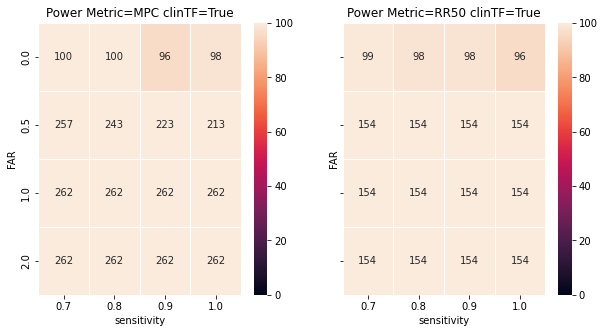

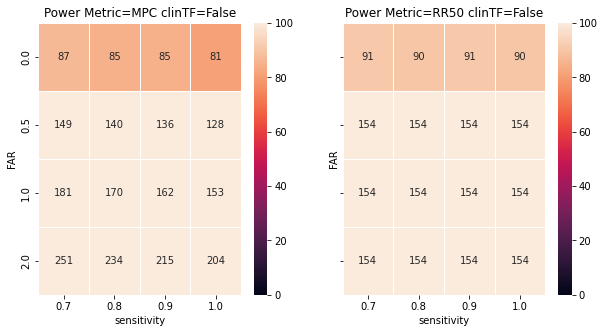

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# this is the plot when inflater was 2

fnList = ['bigRunClinWear.csv','bigRunEWear.csv']
clinList = [True,False]
for ci,clinTF in enumerate(clinList):
    d2=pd.read_csv(fnList[ci])
    fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))     
    maxList = [530, 900]
    mlist=['MPC','RR50']
    for mi,metric_type in enumerate(mlist):
        d3 = d2.copy()
        d3[metric_type] = np.round(100*d2[metric_type] / maxList[mi]).astype('int')
        d3=d3.drop(columns=mlist[1-mi])
        thispow = d3.pivot('FAR','sensitivity',metric_type)
        sns.heatmap(thispow, annot=True,fmt='d',linewidths=0.5, ax=ax[mi],vmin=0,vmax=100)
        ax[mi].set_title(f'Power Metric={metric_type} clinTF={clinTF}')    
    plt.show()


In [50]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunClinWearInf1.csv',clinTF=True,REPS=10000,maxN=1400,DRG=0.2,mini=mini,inflater=1)
#buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunEWearInf1.csv',clinTF=False,REPS=10000,maxN=1400,DRG=0.2,mini=mini,inflater=1)


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1130. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.5  1390  1130


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1360. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    1  1390  1360


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1050. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.5  1390  1050


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1260. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    1  1390  1260


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    2  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 8.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   820  430


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 9.0 minutes
Saving....
Threshold ...840. runtime = 0.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5   840  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 8.0 minutes
Saving....
Threshold ...900. runtime = 0.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   900  460


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 8.0 minutes
Saving....
Threshold ...900. runtime = 0.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2   900  500
   sensitivity  FAR  RR50  MPC
0            1  0.0   820  430
0            1  0.5   840  440
0            1  1.0   900  460
0            1  2.0   900  500


TypeError: 'str' object cannot be interpreted as an integer

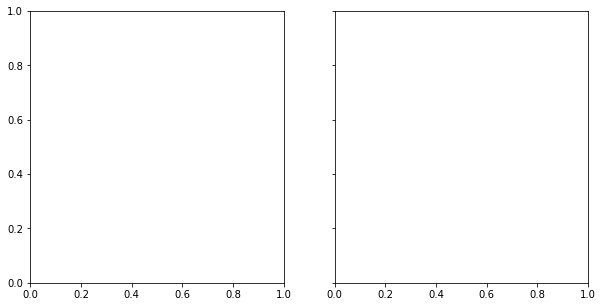

In [52]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
buildSET_of_N([1],[0,.5,1,2],recalc=True,thiscsv='bigRunClinWearInf1.csv',clinTF=False,REPS=10000,maxN=910,DRG=0.2,mini=mini,inflater=1)


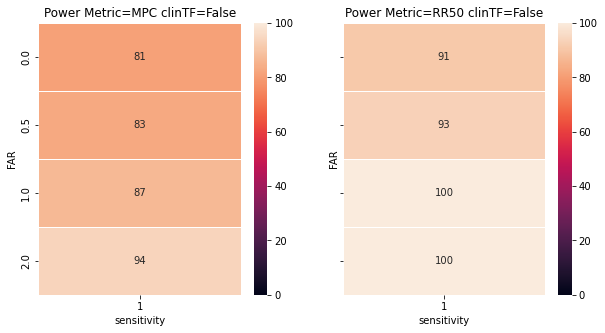

In [54]:
d2=pd.read_csv('bigRunClinWearInf1.csv')
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))     
maxList = [530, 900]
mlist=['MPC','RR50']
for mi,metric_type in enumerate(mlist):
    d3 = d2.copy()
    d3[metric_type] = np.round(100*d2[metric_type] / maxList[mi]).astype('int')
    d3=d3.drop(columns=mlist[1-mi])
    thispow = d3.pivot('FAR','sensitivity',metric_type)
    sns.heatmap(thispow, annot=True,fmt='d',linewidths=0.5, ax=ax[mi],vmin=0,vmax=100)
    ax[mi].set_title(f'Power Metric={metric_type} clinTF={clinTF}')    
plt.show()

In [56]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
buildSET_of_N([1],[0,.5,1,2],recalc=True,thiscsv='bigRunClinTWearInf1.csv',clinTF=True,REPS=10000,maxN=1210,DRG=0.2,mini=mini,inflater=1)


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...860. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   860  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...920. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5   920  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...970. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   970  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1200. runtime = 1.0 minutes
Threshold ...660. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2  1200  660
   sensitivity  FAR  RR50  MPC
0            1  0.0   860  510
0            1  0.5   920  540
0            1  1.0   970  540
0            1  2.0  1200  660


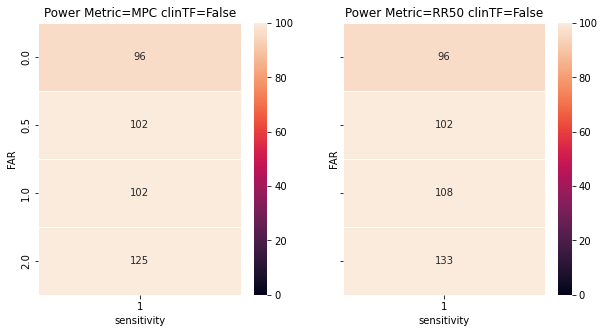

In [57]:
d2=pd.read_csv('bigRunClinTWearInf1.csv')
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))     
maxList = [530, 900]
mlist=['MPC','RR50']
for mi,metric_type in enumerate(mlist):
    d3 = d2.copy()
    d3[metric_type] = np.round(100*d2[metric_type] / maxList[mi]).astype('int')
    d3=d3.drop(columns=mlist[1-mi])
    thispow = d3.pivot('FAR','sensitivity',metric_type)
    sns.heatmap(thispow, annot=True,fmt='d',linewidths=0.5, ax=ax[mi],vmin=0,vmax=100)
    ax[mi].set_title(f'Power Metric={metric_type} clinTF={clinTF}')    
plt.show()

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 26.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   880  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 27.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5   910  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...990. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    1   990  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...1310. runtime = 1.0 minutes
Threshold ...720. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    2  1310  720


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...920. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5   920  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...990. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    1   990  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...1310. runtime = 1.0 minutes
Threshold ...700. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    2  1310  700


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5   910  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...980. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1   980  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...1240. runtime = 1.0 minutes
Threshold ...680. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    2  1240  680


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5   890  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...980. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   980  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...1210. runtime = 1.0 minutes
Threshold ...670. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2  1210  670
   sensitivity  FAR  RR50  MPC
0          0.7  0.0   880  540
0          0.7  0.5   910  550
0          0.7  1.0   990  560
0          0.7  2.0  1310  720
0          0.8  0.0   880  520
0          0.8  0.5   920  540
0          0.8  1.0   990  560
0          0.8  2.0  1310  700
0          0.9  0.0   880  530
0          0.9  0.5   910  530
0          0.9  1.0   980  560
0          0.9  2.0  1240  680
0          1.0  0.0   880  520
0          1.0  0.5   890  520
0          1.0  1.0   980  540
0          1.0  2.0  1210  670
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/9f/mx3t8lrj4719csmgr9pw7n1r0000gr/T/ipykernel_13342/3450349424.py", line 8, in <cell line: 8>
    drawGrid(fn)
  File "/Users/danielgoldenholz/Documents/GitHub/WEARsimulator/weargroup_v2.py", line 194, in drawGrid
    ax[mi].set_title(f'Power Metric={metric_type} clinTF={clinTF}')
NameError: name 'clinTF' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1992, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1118, in st

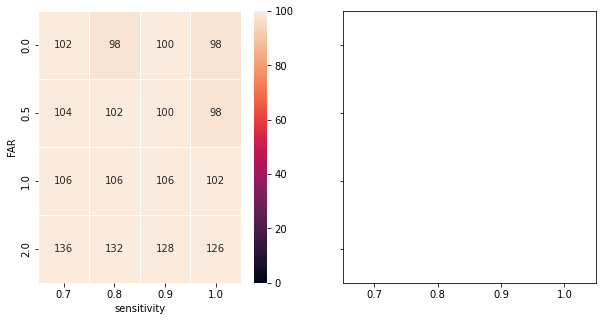

In [60]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
fn = 'bigRunClinT-sandf-Inf1.csv'
buildSET_of_N([0.7,0.8,0.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=True,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=1)
drawGrid(fn)


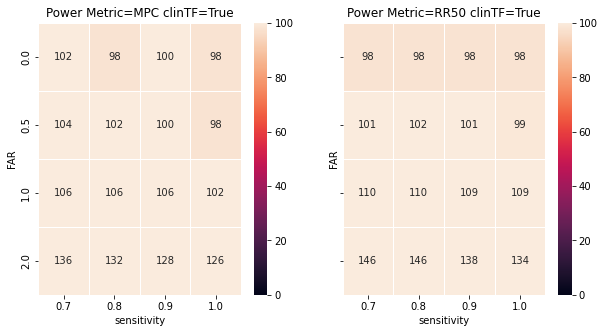

In [61]:
drawGrid(fn,clinTF=True)

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 26.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 28.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5   890  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 26.0 minutes
Saving....
Threshold ...920. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    1   920  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...1010. runtime = 0.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    2  1010  570


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...870. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   870  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5   910  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...930. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    1   930  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...980. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    2   980  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5   890  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...920. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1   920  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...980. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    2   980  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...870. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...900. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5   900  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   890  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...1000. runtime = 0.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2  1000  550
   sensitivity  FAR  RR50  MPC
0          0.7  0.0   880  530
0          0.7  0.5   890  530
0          0.7  1.0   920  540
0          0.7  2.0  1010  570
0          0.8  0.0   870  530
0          0.8  0.5   910  530
0          0.8  1.0   930  540
0          0.8  2.0   980  560
0          0.9  0.0   880  520
0          0.9  0.5   890  530
0          0.9  1.0   920  530
0          0.9  2.0   980  560
0          1.0  0.0   870  510
0          1.0  0.5   900  520
0          1.0  1.0   890  520
0          1.0  2.0  1000  550


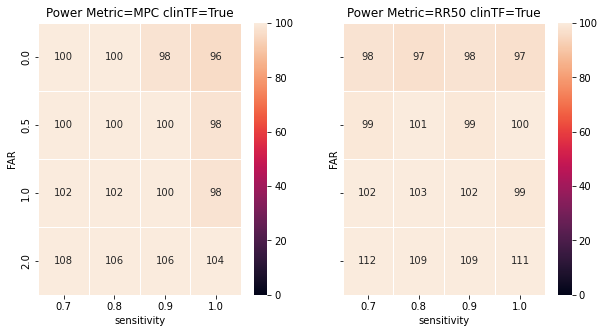

In [62]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
fn = 'bigRunClinT-sandf-Inf0.5.csv'
buildSET_of_N([0.7,0.8,0.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=True,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=0.5)
drawGrid(fn,clinTF=True)

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 28.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1060. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.5  1490  1060


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1200. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    1  1490  1200


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1490. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1490  1490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 26.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...990. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5  1490  990


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1120. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    1  1490  1120


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1400. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    2  1490  1400


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...870. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   870  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...950. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5  1490  950


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1080. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    1  1490  1080


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1320. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    2  1490  1320


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...870. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...920. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1490  920


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1020. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1490  1020


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1250. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1490  1250
   sensitivity  FAR  RR50   MPC
0          0.7  0.0   880   530
0          0.7  0.5  1490  1060
0          0.7  1.0  1490  1200
0          0.7  2.0  1490  1490
0          0.8  0.0   880   520
0          0.8  0.5  1490   990
0          0.8  1.0  1490  1120
0          0.8  2.0  1490  1400
0          0.9  0.0   870   520
0          0.9  0.5  1490   950
0          0.9  1.0  1490  1080
0          0.9  2.0  1490  1320
0          1.0  0.0   870   510
0          1.0  0.5  1490   920
0          1.0  1.0  1490  1020
0          1.0  2.0  1490  1250


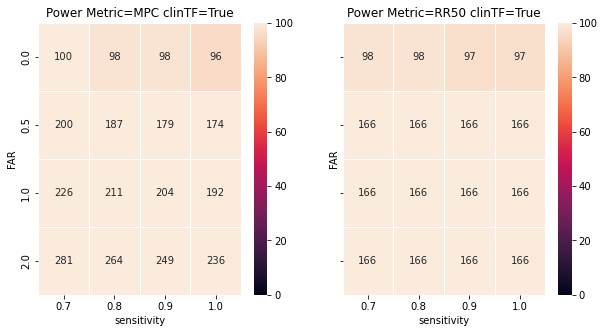

In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
fn = 'tryA_true_inf2_3.csv'
buildSET_of_N([0.7,0.8,0.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=True,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=2/3)
drawGrid(fn,clinTF=True)

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   900  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...975. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5  1495  975


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1065. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    1  1495  1065


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1210. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1495  1210


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...885. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   885  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...930. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5  1495  930


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1005. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    1  1495  1005


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1120. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    2  1495  1120


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...865. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   865  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...900. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5  1495  900


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...980. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1  1495  980


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1055. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    2  1495  1055


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...875. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   875  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...865. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  865


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...930. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1  1495  930


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1015. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1495  1015
   sensitivity  FAR  RR50   MPC
0          0.7  0.0   900   535
0          0.7  0.5  1495   975
0          0.7  1.0  1495  1065
0          0.7  2.0  1495  1210
0          0.8  0.0   885   530
0          0.8  0.5  1495   930
0          0.8  1.0  1495  1005
0          0.8  2.0  1495  1120
0          0.9  0.0   865   515
0          0.9  0.5  1495   900
0          0.9  1.0  1495   980
0          0.9  2.0  1495  1055
0          1.0  0.0   875   515
0          1.0  0.5  1495   865
0          1.0  1.0  1495   930
0          1.0  2.0  1495  1015


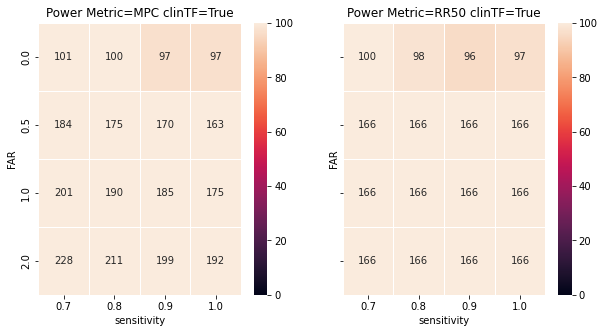

In [3]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
fn = 'tryA_true_inf1_3.csv'
buildSET_of_N([0.7,0.8,0.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=True,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=1/3)
drawGrid(fn,clinTF=True)

In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
clinTF = True
fn = f'tryA_{clinTF}_inf1.csv'
inflater = 1
buildSET_of_N([0.7,0.8,0.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
drawGrid(fn,clinTF=clinTF)
inflater = 4/3
fn = f'tryA_{clinTF}_inf10.csv'
buildSET_of_N([0.7,0.8,0.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
drawGrid(fn,clinTF=clinTF)


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 580, in run
    self.join_executor_internals()
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 812, in join_executor_internals
    self.shutdown_workers()
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 796, in shutdown_workers
    n_children_to_stop += 1
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/backend/synchronize.py", line 113, in __exit__
    return self._semlock.release()
ValueError: semaphore or lock released too many ti

KeyboardInterrupt: 

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 32.0 minutes
Saving....
Threshold ...910. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   910  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  520
   sensitivity  FAR  RR50  MPC
0          0.5    0   910  550
0          1.0    0   870  520


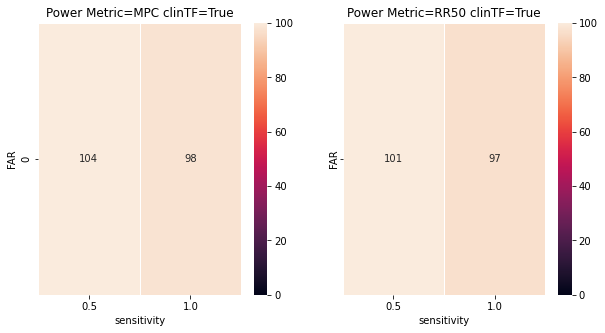

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 18.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   815  490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   795  430
   sensitivity  FAR  RR50  MPC
0          0.5    0   815  490
0          1.0    0   795  430


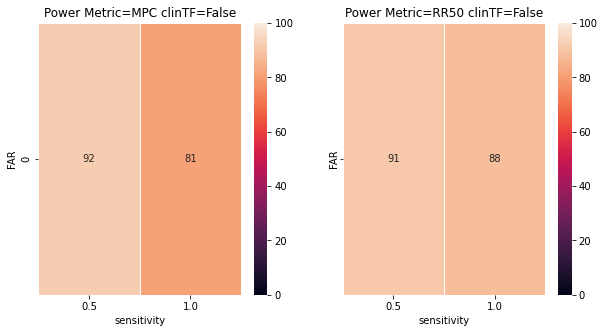

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.5  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1495. runtime = 2.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1495  1495
   sensitivity  FAR  RR50   MPC
0            1  0.5  1495  1495
0            1  1.0  1495  1495
0            1  2.0  1495  1495


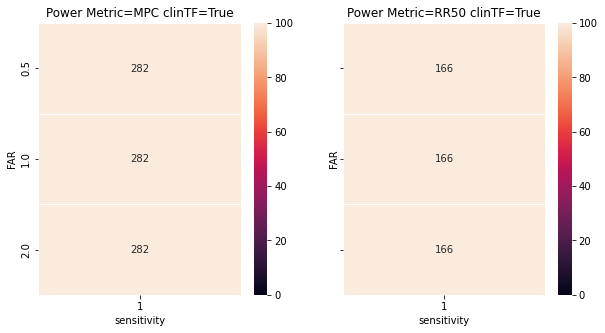

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...965. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  965


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1495  1495
   sensitivity  FAR  RR50   MPC
0            1  0.5  1495   965
0            1  1.0  1495  1495
0            1  2.0  1495  1495


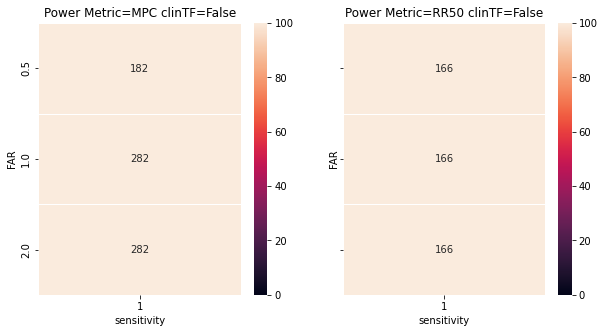

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
inflater = 20/3
for clinTF in [True,False]:
    fn = f'tryRange_{clinTF}_nofar_inf6.66.csv'
    buildSET_of_N([0.5,1],[0],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)
for clinTF in [True,False]:
    fn = f'tryRange_{clinTF}_onlyFar_inf6.66.csv'
    buildSET_of_N([1],[0.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)


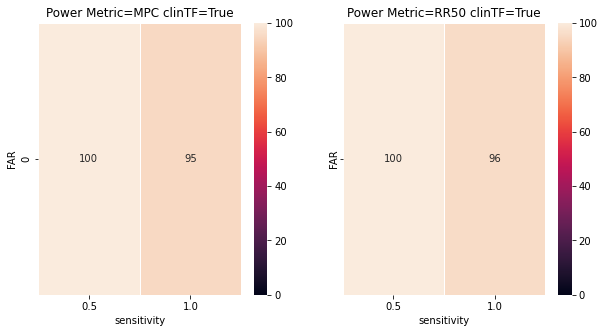

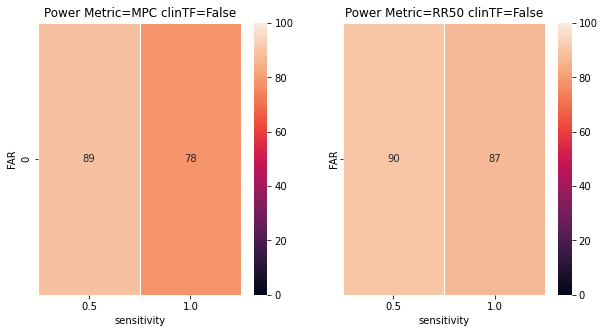

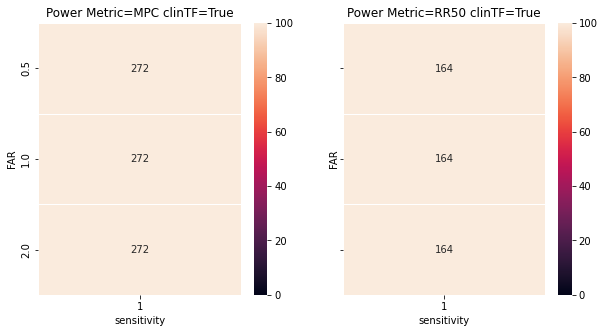

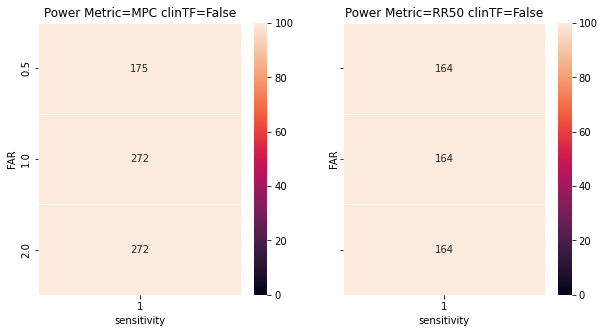

In [3]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
inflater = 20/3
for clinTF in [True,False]:
    fn = f'tryRange_{clinTF}_nofar_inf6.66.csv'
    #buildSET_of_N([0.5,1],[0],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)
for clinTF in [True,False]:
    fn = f'tryRange_{clinTF}_onlyFar_inf6.66.csv'
    #buildSET_of_N([1],[0.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)

The above shows us that inflation 20/3 does not get us far.

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 32.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   890  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   880  510
   sensitivity  FAR  RR50  MPC
0          0.5    0   890  540
0          1.0    0   880  510


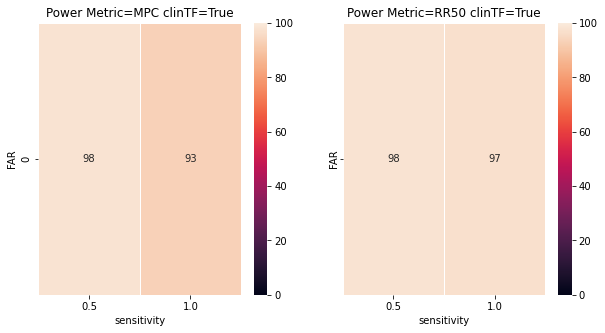

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...825. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   825  490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...425. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   810  425
   sensitivity  FAR  RR50  MPC
0          0.5    0   825  490
0          1.0    0   810  425


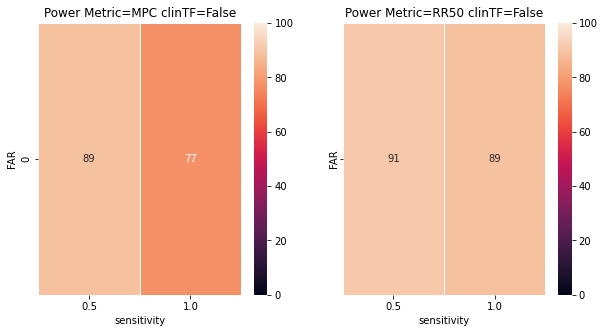

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...900. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  900


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1015. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1495  1015


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1230. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1495  1230
   sensitivity  FAR  RR50   MPC
0            1  0.5  1495   900
0            1  1.0  1495  1015
0            1  2.0  1495  1230


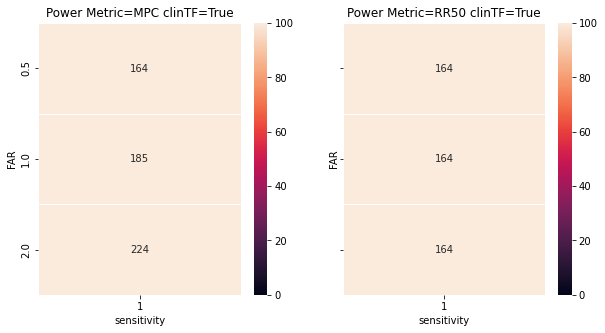

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...595. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  595


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...650. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1  1495  650


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...725. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2  1495  725
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  595
0            1  1.0  1495  650
0            1  2.0  1495  725


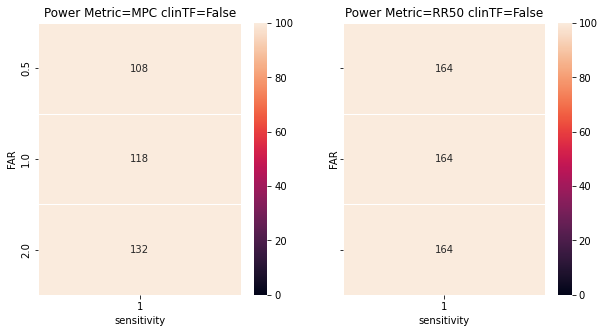

In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
inflater = 2/3
for clinTF in [True,False]:
    fn = f'tryRange_{clinTF}_nofar_inf0.66.csv'
    buildSET_of_N([0.5,1],[0],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)
for clinTF in [True,False]:
    fn = f'tryRange_{clinTF}_onlyFar_inf0.66.csv'
    buildSET_of_N([1],[0.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 31.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   890  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...730. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  730


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1170. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1170


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1215. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.5  1495  1215


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1405. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    1  1495  1405


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 27.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    0   900  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...695. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6  0.1  1495  695


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1065. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.6  0.2  1495  1065


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1120. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.6  0.5  1495  1120


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1280. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.6    1  1495  1280


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.6    2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...875. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   875  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...685. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  685


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...980. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  980


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1055. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.5  1495  1055


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1195. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    1  1495  1195


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...665. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  665


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...955. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  955


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...975. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5  1495  975


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1120. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    1  1495  1120


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    2  1495  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...645. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  645


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...890. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  890


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...945. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5  1495  945


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1060. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    1  1495  1060


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1300. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    2  1495  1300


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...860. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   860  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...630. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...855. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  855


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...910. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  910


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1020. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1495  1020


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1245. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1495  1245
   sensitivity  FAR  RR50   MPC
0          0.5  0.0   890   545
0          0.5  0.1  1495   730
0          0.5  0.2  1495  1170
0          0.5  0.5  1495  1215
0          0.5  1.0  1495  1405
0          0.5  2.0  1495  1495
0          0.6  0.0   900   540
0          0.6  0.1  1495   695
0          0.6  0.2  1495  1065
0          0.6  0.5  1495  1120
0          0.6  1.0  1495  1280
0          0.6  2.0  1495  1495
0          0.7  0.0   875   535
0          0.7  0.1  1495   685
0          0.7  0.2  1495   980
0          0.7  0.5  1495  1055
0          0.7  1.0  1495  1195
0          0.7  2.0  1495  1495
0          0.8  0.0   880   530
0          0.8  0.1  1495   665
0          0.8  0.2  1495   955
0          0.8  0.5  1495   975
0          0.8  1.0  1495  1120
0          0.8  2.0  1495  1390
0          

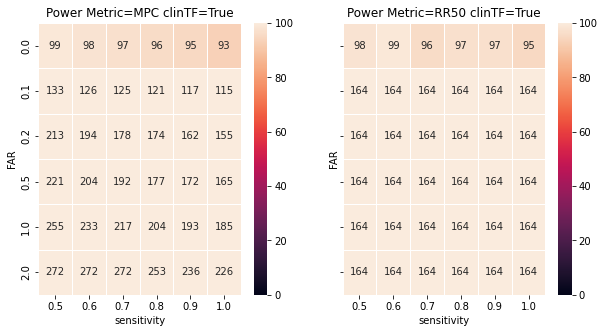

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...830. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   830  495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...595. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  595


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...705. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2  1495  705


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...740. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.5  1495  740


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...840. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    1  1495  840


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...970. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    2  1495  970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    0   805  470


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6  0.1  1495  570


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...655. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6  0.2  1495  655


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...700. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6  0.5  1495  700


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...780. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    1  1495  780


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...900. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    2  1495  900


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   805  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...625. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  625


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...670. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5  1495  670


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...730. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    1  1495  730


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...830. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    2  1495  830


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   815  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...625. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5  1495  625


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...690. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    1  1495  690


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...800. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    2  1495  800


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   805  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...610. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5  1495  610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...655. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1  1495  655


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...770. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    2  1495  770


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...435. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   805  435


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...640. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1  1495  640


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...740. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2  1495  740
   sensitivity  FAR  RR50  MPC
0          0.5  0.0   830  495
0          0.5  0.1  1495  595
0          0.5  0.2  1495  705
0          0.5  0.5  1495  740
0          0.5  1.0  1495  840
0          0.5  2.0  1495  970
0          0.6  0.0   805  470
0          0.6  0.1  1495  570
0          0.6  0.2  1495  655
0          0.6  0.5  1495  700
0          0.6  1.0  1495  780
0          0.6  2.0  1495  900
0          0.7  0.0   805  455
0          0.7  0.1  1495  535
0          0.7  0.2  1495  625
0          0.7  0.5  1495  670
0          0.7  1.0  1495  730
0          0.7  2.0  1495  830
0          0.8  0.0   815  455
0          0.8  0.1  1495  520
0          0.8  0.2  1495  600
0          0.8  0.5  1495  625
0          0.8  1.0  1495  690
0          0.8  2.0  1495  800
0          0.9  0.0   805  440
0       

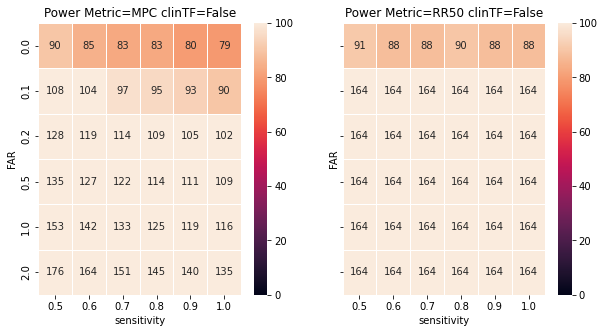

In [5]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
inflater = 2/3
for clinTF in [True,False]:
    fn = f'tryBigRange_{clinTF}_nofar_inf0.66.csv'
    buildSET_of_N([0.5,.6,.7,.8,.9,1],[0,.1,.2,.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 30.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   900  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 28.0 minutes
Saving....
Threshold ...1065. runtime = 1.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1065  570


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...740. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  740


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1060. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1060


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1135. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1135


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...885. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   885  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...1055. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1055  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...685. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  685


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...925. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  925


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...945. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  945


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...1045. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1045  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...660. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  660


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...870. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  870


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...920. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  920


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   870  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...1055. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1055  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...650. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  650


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...845. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  845


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...890. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  890


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1030  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...630. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...805. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  805


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...850. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  850
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   900   545
0          0.5  0.05  1065   570
0          0.5  0.10  1495   740
0          0.5  0.15  1495  1060
0          0.5  0.20  1495  1135
0          0.7  0.00   885   530
0          0.7  0.05  1055   550
0          0.7  0.10  1495   685
0          0.7  0.15  1495   925
0          0.7  0.20  1495   945
0          0.8  0.00   880   530
0          0.8  0.05  1045   545
0          0.8  0.10  1495   660
0          0.8  0.15  1495   870
0          0.8  0.20  1495   920
0          0.9  0.00   870   515
0          0.9  0.05  1055   535
0          0.9  0.10  1495   650
0          0.9  0.15  1495   845
0          0.9  0.20  1495   890
0          1.0  0.00   870   500
0          1.0  0.05  1030   525
0          1.0  0.10  1495   630
0          1.0  0.15  

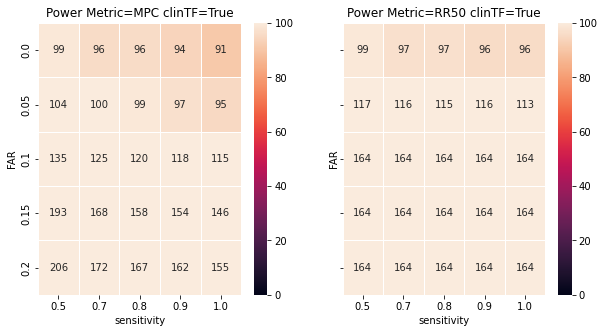

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...830. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   830  490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...505. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1030  505


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...660. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15  1495  660


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...700. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2  1495  700


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   805  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1000. runtime = 1.0 minutes
Threshold ...480. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1000  480


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...605. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  605


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...620. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  620


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   795  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1000. runtime = 1.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1000  470


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  570


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   820  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1020. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1020  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   795  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1015. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1015  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  555
   sensitivity   FAR  RR50  MPC
0          0.5  0.00   830  490
0          0.5  0.05  1030  505
0          0.5  0.10  1495  575
0          0.5  0.15  1495  660
0          0.5  0.20  1495  700
0          0.7  0.00   805  465
0          0.7  0.05  1000  480
0          0.7  0.10  1495  540
0          0.7  0.15  1495  605
0          0.7  0.20  1495  620
0          0.8  0.00   795  455
0          0.8  0.05  1000  470
0          0.8  0.10  1495  525
0          0.8  0.15  1495  570
0          0.8  0.20  1495  590
0          0.9  0.00   820  440
0          0.9  0.05  1020  455
0          0.9  0.10  1495  500
0          0.9  0.15  1495  550
0          0.9  0.20  1495  575
0          1.0  0.00   795  440
0          1.0  0.05  1015  455
0          1.0  0.10  1495  500
0          1.0  0.15  1495  530
0          1.0

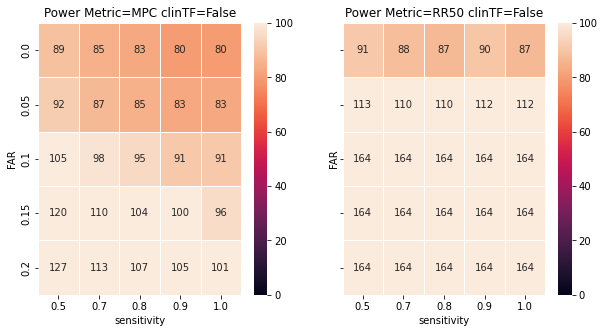

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 30.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   900  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 27.0 minutes
Saving....
Threshold ...1085. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1085  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...730. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  730


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1065. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1065


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1155. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1155


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...895. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   895  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...1080. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1080  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...680. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  680


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...930. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  930


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1000. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.2  1495  1000


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   890  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...1040. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1040  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...665. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  665


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...870. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  870


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...930. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  930


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   870  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...1045. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1045  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...650. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  650


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...840. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  840


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...875. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  875


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 18.0 minutes
Saving....
Threshold ...1045. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1045  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...640. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  640


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...815. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  815


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...855. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  855
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   900   550
0          0.5  0.05  1085   555
0          0.5  0.10  1495   730
0          0.5  0.15  1495  1065
0          0.5  0.20  1495  1155
0          0.7  0.00   895   530
0          0.7  0.05  1080   555
0          0.7  0.10  1495   680
0          0.7  0.15  1495   930
0          0.7  0.20  1495  1000
0          0.8  0.00   890   535
0          0.8  0.05  1040   540
0          0.8  0.10  1495   665
0          0.8  0.15  1495   870
0          0.8  0.20  1495   930
0          0.9  0.00   870   515
0          0.9  0.05  1045   540
0          0.9  0.10  1495   650
0          0.9  0.15  1495   840
0          0.9  0.20  1495   875
0          1.0  0.00   870   515
0          1.0  0.05  1045   535
0          1.0  0.10  1495   640
0          1.0  0.15  

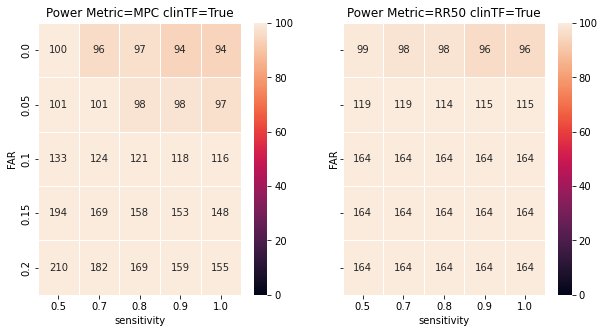

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...830. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   830  490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1030  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...670. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15  1495  670


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...705. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2  1495  705


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   815  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1025. runtime = 1.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1025  470


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...605. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  605


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...630. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   800  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1025. runtime = 1.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1025  470


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   800  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1030  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...505. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  505


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...580. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  580


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   815  430


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1005. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1005  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  555
   sensitivity   FAR  RR50  MPC
0          0.5  0.00   830  490
0          0.5  0.05  1030  510
0          0.5  0.10  1495  590
0          0.5  0.15  1495  670
0          0.5  0.20  1495  705
0          0.7  0.00   815  465
0          0.7  0.05  1025  470
0          0.7  0.10  1495  545
0          0.7  0.15  1495  605
0          0.7  0.20  1495  630
0          0.8  0.00   800  450
0          0.8  0.05  1025  470
0          0.8  0.10  1495  520
0          0.8  0.15  1495  575
0          0.8  0.20  1495  600
0          0.9  0.00   800  440
0          0.9  0.05  1030  465
0          0.9  0.10  1495  505
0          0.9  0.15  1495  555
0          0.9  0.20  1495  580
0          1.0  0.00   815  430
0          1.0  0.05  1005  450
0          1.0  0.10  1495  500
0          1.0  0.15  1495  530
0          1.0

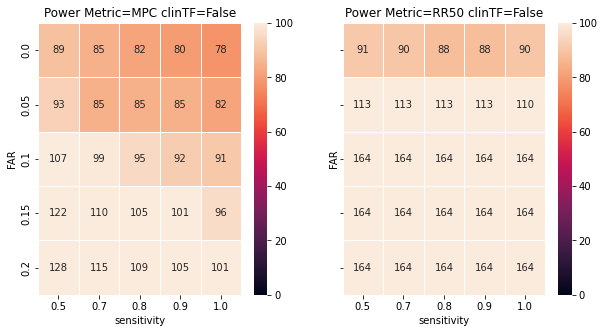

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 30.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   890  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 26.0 minutes
Saving....
Threshold ...1180. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1180  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...730. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  730


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1125. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1125


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1230. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1230


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   890  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...1140. runtime = 1.0 minutes
Threshold ...565. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1140  565


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...670. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  670


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...960. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  960


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1035. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.2  1495  1035


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...1130. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1130  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...660. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  660


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...920. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  920


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...980. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  980


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...1135. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1135  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...650. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  650


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...880. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  880


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...930. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  930


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...855. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   855  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 18.0 minutes
Saving....
Threshold ...1125. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1125  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...610. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...845. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  845


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...890. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  890
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   890   545
0          0.5  0.05  1180   590
0          0.5  0.10  1495   730
0          0.5  0.15  1495  1125
0          0.5  0.20  1495  1230
0          0.7  0.00   890   530
0          0.7  0.05  1140   565
0          0.7  0.10  1495   670
0          0.7  0.15  1495   960
0          0.7  0.20  1495  1035
0          0.8  0.00   880   530
0          0.8  0.05  1130   555
0          0.8  0.10  1495   660
0          0.8  0.15  1495   920
0          0.8  0.20  1495   980
0          0.9  0.00   880   515
0          0.9  0.05  1135   545
0          0.9  0.10  1495   650
0          0.9  0.15  1495   880
0          0.9  0.20  1495   930
0          1.0  0.00   855   510
0          1.0  0.05  1125   540
0          1.0  0.10  1495   610
0          1.0  0.15  

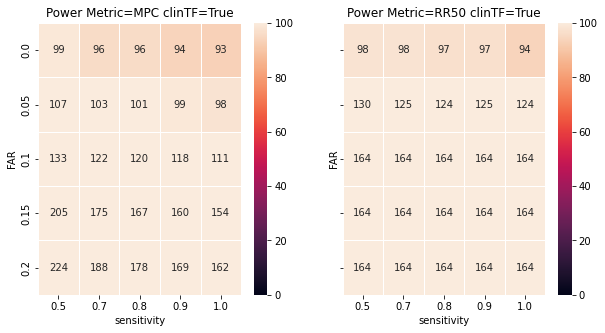

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...825. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   825  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1100. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1100  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...695. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15  1495  695


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...720. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2  1495  720


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   800  460


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1095. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1095  495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...610. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...635. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  635


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   810  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1070. runtime = 1.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1070  470


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...585. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  585


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...610. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   795  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1070. runtime = 1.0 minutes
Threshold ...475. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1070  475


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   815  430


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1075. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1075  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  560
   sensitivity   FAR  RR50  MPC
0          0.5  0.00   825  500
0          0.5  0.05  1100  515
0          0.5  0.10  1495  600
0          0.5  0.15  1495  695
0          0.5  0.20  1495  720
0          0.7  0.00   800  460
0          0.7  0.05  1095  495
0          0.7  0.10  1495  540
0          0.7  0.15  1495  610
0          0.7  0.20  1495  635
0          0.8  0.00   810  450
0          0.8  0.05  1070  470
0          0.8  0.10  1495  520
0          0.8  0.15  1495  585
0          0.8  0.20  1495  610
0          0.9  0.00   795  440
0          0.9  0.05  1070  475
0          0.9  0.10  1495  510
0          0.9  0.15  1495  560
0          0.9  0.20  1495  575
0          1.0  0.00   815  430
0          1.0  0.05  1075  450
0          1.0  0.10  1495  495
0          1.0  0.15  1495  545
0          1.0

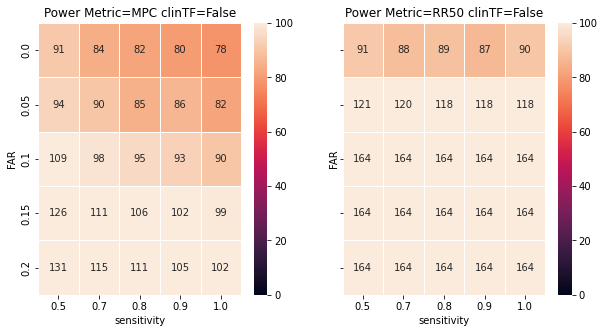

In [6]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
for inflater in [1/3,2/3,2]:
    for clinTF in [True,False]:
        fn = f'tryBigRange2_{clinTF}_nofar_inf{inflater}.csv'
        buildSET_of_N([0.5,.7,.8,.9,1],[0,0.05,.1,.15,.2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
        drawGrid(fn,clinTF=clinTF)
        

In [7]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
for inflater in [.01,10,100]:
    for clinTF in [True,False]:
        fn = f'tryBigRange2_{clinTF}_nofar_inf{inflater}.csv'
        buildSET_of_N([0.5,.7,.8,.9,1],[0,0.05,.1,.15,.2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
        #drawGrid(fn,clinTF=clinTF)

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 31.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   890  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 28.0 minutes
Saving....
Threshold ...1075. runtime = 1.0 minutes
Threshold ...565. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1075  565


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...740. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  740


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1050. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1050


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1060. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1060


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 26.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   900  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...1055. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1055  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...690. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  690


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...915. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  915


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...945. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  945


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...860. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   860  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...1045. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1045  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...665. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  665


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...880. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  880


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...870. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  870


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...885. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   885  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...1050. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1050  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...650. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  650


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...840. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  840


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...830. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  830


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...1025. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1025  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...630. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...795. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  795


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...805. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  805
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   890   535
0          0.5  0.05  1075   565
0          0.5  0.10  1495   740
0          0.5  0.15  1495  1050
0          0.5  0.20  1495  1060
0          0.7  0.00   900   540
0          0.7  0.05  1055   555
0          0.7  0.10  1495   690
0          0.7  0.15  1495   915
0          0.7  0.20  1495   945
0          0.8  0.00   860   525
0          0.8  0.05  1045   545
0          0.8  0.10  1495   665
0          0.8  0.15  1495   880
0          0.8  0.20  1495   870
0          0.9  0.00   885   520
0          0.9  0.05  1050   530
0          0.9  0.10  1495   650
0          0.9  0.15  1495   840
0          0.9  0.20  1495   830
0          1.0  0.00   870   500
0          1.0  0.05  1025   525
0          1.0  0.10  1495   630
0          1.0  0.15  

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 18.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   815  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1010. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1010  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...595. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  595


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...675. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15  1495  675


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...680. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2  1495  680


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   810  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1005. runtime = 1.0 minutes
Threshold ...480. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1005  480


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...595. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  595


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...615. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  615


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   795  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1030  460


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...565. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  565


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...445. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   805  445


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1020. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1020  460


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...565. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  565


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...435. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   810  435


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1020. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1020  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  545
   sensitivity   FAR  RR50  MPC
0          0.5  0.00   815  500
0          0.5  0.05  1010  510
0          0.5  0.10  1495  595
0          0.5  0.15  1495  675
0          0.5  0.20  1495  680
0          0.7  0.00   810  465
0          0.7  0.05  1005  480
0          0.7  0.10  1495  545
0          0.7  0.15  1495  595
0          0.7  0.20  1495  615
0          0.8  0.00   795  450
0          0.8  0.05  1030  460
0          0.8  0.10  1495  530
0          0.8  0.15  1495  565
0          0.8  0.20  1495  590
0          0.9  0.00   805  445
0          0.9  0.05  1020  460
0          0.9  0.10  1495  510
0          0.9  0.15  1495  555
0          0.9  0.20  1495  565
0          1.0  0.00   810  435
0          1.0  0.05  1020  450
0          1.0  0.10  1495  495
0          1.0  0.15  1495  540
0          1.0

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 31.0 minutes
Saving....
Threshold ...895. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   895  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...1250. runtime = 1.0 minutes
Threshold ...605. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1250  605


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...965. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  965


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   890  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...1215. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1215  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...850. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  850


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1270. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.7  0.15  1495  1270


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   870  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...1210. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1210  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...820. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  820


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1200. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.8  0.15  1495  1200


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...1185. runtime = 1.0 minutes
Threshold ...565. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1185  565


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...790. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  790


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1120. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.9  0.15  1495  1120


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1465. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9  0.2  1495  1465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...865. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   865  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...1165. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1165  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...770. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  770


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1060. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0            1  0.15  1495  1060


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1370. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.2  1495  1370
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   895   545
0          0.5  0.05  1250   605
0          0.5  0.10  1495   965
0          0.5  0.15  1495  1495
0          0.5  0.20  1495  1495
0          0.7  0.00   890   540
0          0.7  0.05  1215   590
0          0.7  0.10  1495   850
0          0.7  0.15  1495  1270
0          0.7  0.20  1495  1495
0          0.8  0.00   870   525
0          0.8  0.05  1210   575
0          0.8  0.10  1495   820
0          0.8  0.15  1495  1200
0          0.8  0.20  1495  1495
0          0.9  0.00   880   525
0          0.9  0.05  1185   565
0          0.9  0.10  1495   790
0          0.9  0.15  1495  1120
0          0.9  0.20  1495  1465
0          1.0  0.00   865   510
0          1.0  0.05  1165   550
0          1.0  0.10  1495   770
0          1.0  0.1

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   810  490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1140. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1140  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...675. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  675


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...865. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15  1495  865


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1035. runtime = 3.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1035


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   795  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1170. runtime = 1.0 minutes
Threshold ...505. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1170  505


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...750. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  750


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...875. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  875


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...445. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   800  445


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1120. runtime = 1.0 minutes
Threshold ...475. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1120  475


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...690. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  690


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...820. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  820


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...445. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   815  445


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1105. runtime = 1.0 minutes
Threshold ...480. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1105  480


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...675. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  675


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...770. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  770


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   820  430


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1100. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1100  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...635. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  635


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...725. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  725
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   810   490
0          0.5  0.05  1140   530
0          0.5  0.10  1495   675
0          0.5  0.15  1495   865
0          0.5  0.20  1495  1035
0          0.7  0.00   795   455
0          0.7  0.05  1170   505
0          0.7  0.10  1495   600
0          0.7  0.15  1495   750
0          0.7  0.20  1495   875
0          0.8  0.00   800   445
0          0.8  0.05  1120   475
0          0.8  0.10  1495   590
0          0.8  0.15  1495   690
0          0.8  0.20  1495   820
0          0.9  0.00   815   445
0          0.9  0.05  1105   480
0          0.9  0.10  1495   560
0          0.9  0.15  1495   675
0          0.9  0.20  1495   770
0          1.0  0.00   820   430
0          1.0  0.05  1100   465
0          1.0  0.10  1495   535
0          1.0  0.15  

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 30.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   890  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.05  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...910. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   910  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.7  0.05  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.7  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.8  0.05  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.8  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   870  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.9  0.05  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.9  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...875. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   875  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1450. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0            1  0.05  1495  1450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0            1  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.2  1495  1495
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   890   545
0          0.5  0.05  1495  1495
0          0.5  0.10  1495  1495
0          0.5  0.15  1495  1495
0          0.5  0.20  1495  1495
0          0.7  0.00   910   540
0          0.7  0.05  1495  1495
0          0.7  0.10  1495  1495
0          0.7  0.15  1495  1495
0          0.7  0.20  1495  1495
0          0.8  0.00   880   520
0          0.8  0.05  1495  1495
0          0.8  0.10  1495  1495
0          0.8  0.15  1495  1495
0          0.8  0.20  1495  1495
0          0.9  0.00   870   510
0          0.9  0.05  1495  1495
0          0.9  0.10  1495  1495
0          0.9  0.15  1495  1495
0          0.9  0.20  1495  1495
0          1.0  0.00   875   515
0          1.0  0.05  1495  1450
0          1.0  0.10  1495  1495
0          1.0  0.1

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   820  490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1150. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.05  1495  1150


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   810  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...970. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1495  970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.7  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   795  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...885. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1495  885


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.8  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   810  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...830. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1495  830


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 47.0 minutes
Saving....
Threshold ...

/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


1495. runtime = 18.0 minutes
Threshold ...1395. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9  0.1  1495  1395


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...

/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


1495. runtime = 14.0 minutes
Threshold ...1495. runtime = 2.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.9  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 110.0 minutes
Saving....
Threshold ...1495. runtime = 16.0 minutes
Threshold ...1495. runtime = 12.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 99.0 minutes
Saving....
Threshold ...810. runtime = 8.0 minutes
Threshold ...435. runtime = 2.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   810  435


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...810. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1495  810


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1320. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.1  1495  1320


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0            1  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.2  1495  1495
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   820   490
0          0.5  0.05  1495  1150
0          0.5  0.10  1495  1495
0          0.5  0.15  1495  1495
0          0.5  0.20  1495  1495
0          0.7  0.00   810   465
0          0.7  0.05  1495   970
0          0.7  0.10  1495  1495
0          0.7  0.15  1495  1495
0          0.7  0.20  1495  1495
0          0.8  0.00   795   450
0          0.8  0.05  1495   885
0          0.8  0.10  1495  1495
0          0.8  0.15  1495  1495
0          0.8  0.20  1495  1495
0          0.9  0.00   810   440
0          0.9  0.05  1495   830
0          0.9  0.10  1495  1395
0          0.9  0.15  1495  1495
0          0.9  0.20  1495  1495
0          1.0  0.00   810   435
0          1.0  0.05  1495   810
0          1.0  0.10  1495  1320
0          1.0  0.1

Inflater = 0


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 33.0 minutes
Saving....
Threshold ...895. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   895  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 27.0 minutes
Saving....
Threshold ...1060. runtime = 1.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1060  570


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...725. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  725


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1045. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1045


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1080. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1080


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...895. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   895  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...1050. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1050  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...675. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  675


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...910. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  910


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...950. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  950


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...865. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   865  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...1045. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1045  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...665. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  665


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...880. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  880


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...885. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  885


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   870  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1030  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...640. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  640


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...810. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  810


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...840. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  840


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...860. runtime = 1.0 minutes
Threshold ...505. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   860  505


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...1045. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1045  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...630. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...810. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  810


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...820. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  820
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   895   535
0          0.5  0.05  1060   570
0          0.5  0.10  1495   725
0          0.5  0.15  1495  1045
0          0.5  0.20  1495  1080
0          0.7  0.00   895   540
0          0.7  0.05  1050   540
0          0.7  0.10  1495   675
0          0.7  0.15  1495   910
0          0.7  0.20  1495   950
0          0.8  0.00   865   525
0          0.8  0.05  1045   555
0          0.8  0.10  1495   665
0          0.8  0.15  1495   880
0          0.8  0.20  1495   885
0          0.9  0.00   870   515
0          0.9  0.05  1030   530
0          0.9  0.10  1495   640
0          0.9  0.15  1495   810
0          0.9  0.20  1495   840
0          1.0  0.00   860   505
0          1.0  0.05  1045   530
0          1.0  0.10  1495   630
0          1.0  0.15  

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   815  495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1010. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1010  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...670. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15  1495  670


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...695. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2  1495  695


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   815  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1025. runtime = 1.0 minutes
Threshold ...475. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1025  475


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...610. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   800  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1010. runtime = 1.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1010  470


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...605. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  605


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   800  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1030  460


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...505. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  505


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...435. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   800  435


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1000. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1000  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  545
   sensitivity   FAR  RR50  MPC
0          0.5  0.00   815  495
0          0.5  0.05  1010  510
0          0.5  0.10  1495  590
0          0.5  0.15  1495  670
0          0.5  0.20  1495  695
0          0.7  0.00   815  465
0          0.7  0.05  1025  475
0          0.7  0.10  1495  555
0          0.7  0.15  1495  600
0          0.7  0.20  1495  610
0          0.8  0.00   800  455
0          0.8  0.05  1010  470
0          0.8  0.10  1495  520
0          0.8  0.15  1495  575
0          0.8  0.20  1495  605
0          0.9  0.00   800  440
0          0.9  0.05  1030  460
0          0.9  0.10  1495  505
0          0.9  0.15  1495  540
0          0.9  0.20  1495  575
0          1.0  0.00   800  435
0          1.0  0.05  1000  440
0          1.0  0.10  1495  500
0          1.0  0.15  1495  540
0          1.0

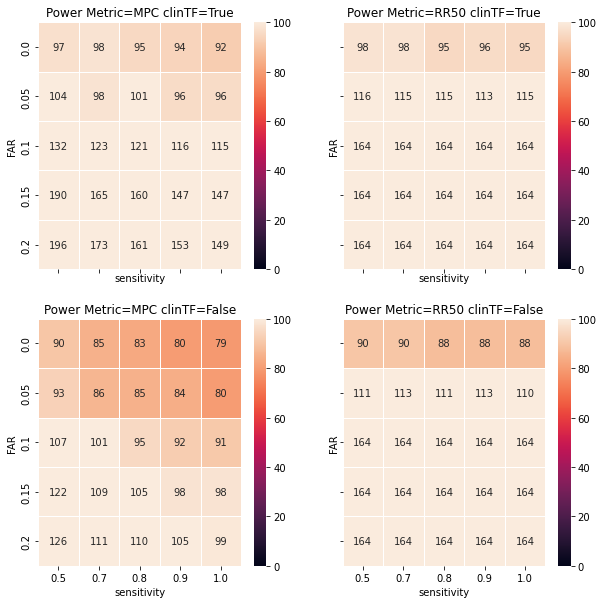

Inflater = 1


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 30.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   900  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 27.0 minutes
Saving....
Threshold ...1105. runtime = 1.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1105  570


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...725. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  725


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1070. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1070


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1150. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1150


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   880  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...1080. runtime = 1.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1080  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...690. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  690


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...940. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  940


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1010. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.2  1495  1010


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...1080. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1080  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...660. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  660


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...900. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  900


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...935. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  935


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...855. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   855  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...1080. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1080  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...660. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  660


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...855. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  855


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...900. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  900


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...860. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   860  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 18.0 minutes
Saving....
Threshold ...1060. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1060  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...635. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  635


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...810. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  810


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...870. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  870
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   900   550
0          0.5  0.05  1105   570
0          0.5  0.10  1495   725
0          0.5  0.15  1495  1070
0          0.5  0.20  1495  1150
0          0.7  0.00   880   525
0          0.7  0.05  1080   560
0          0.7  0.10  1495   690
0          0.7  0.15  1495   940
0          0.7  0.20  1495  1010
0          0.8  0.00   880   520
0          0.8  0.05  1080   540
0          0.8  0.10  1495   660
0          0.8  0.15  1495   900
0          0.8  0.20  1495   935
0          0.9  0.00   855   510
0          0.9  0.05  1080   550
0          0.9  0.10  1495   660
0          0.9  0.15  1495   855
0          0.9  0.20  1495   900
0          1.0  0.00   860   520
0          1.0  0.05  1060   535
0          1.0  0.10  1495   635
0          1.0  0.15  

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...485. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   815  485


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1065. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1065  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...685. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15  1495  685


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...710. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2  1495  710


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   810  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1050. runtime = 1.0 minutes
Threshold ...475. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1050  475


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...610. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...640. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  640


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   805  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1040. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1040  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...580. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  580


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...605. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  605


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...445. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   810  445


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1040. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1040  460


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...580. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  580


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   810  430


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1035. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1035  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  570
   sensitivity   FAR  RR50  MPC
0          0.5  0.00   815  485
0          0.5  0.05  1065  515
0          0.5  0.10  1495  590
0          0.5  0.15  1495  685
0          0.5  0.20  1495  710
0          0.7  0.00   810  455
0          0.7  0.05  1050  475
0          0.7  0.10  1495  545
0          0.7  0.15  1495  610
0          0.7  0.20  1495  640
0          0.8  0.00   805  450
0          0.8  0.05  1040  455
0          0.8  0.10  1495  525
0          0.8  0.15  1495  580
0          0.8  0.20  1495  605
0          0.9  0.00   810  445
0          0.9  0.05  1040  460
0          0.9  0.10  1495  510
0          0.9  0.15  1495  555
0          0.9  0.20  1495  580
0          1.0  0.00   810  430
0          1.0  0.05  1035  450
0          1.0  0.10  1495  500
0          1.0  0.15  1495  540
0          1.0

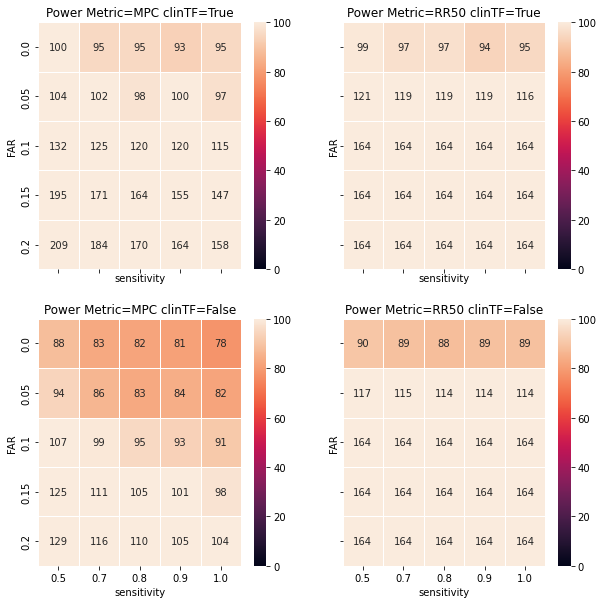

In [8]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
for inflater in [0,1]:
    print(f'Inflater = {inflater}')
    fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))   
    for ci,clinTF in enumerate([True,False]):
        fn = f'tryBigRange2_{clinTF}_nofar_inf{inflater}.csv'
        buildSET_of_N([0.5,.7,.8,.9,1],[0,0.05,.1,.15,.2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
        drawGrid(fn,clinTF=clinTF,ax=ax[ci,:])
        
    plt.show()

Inflater = 0


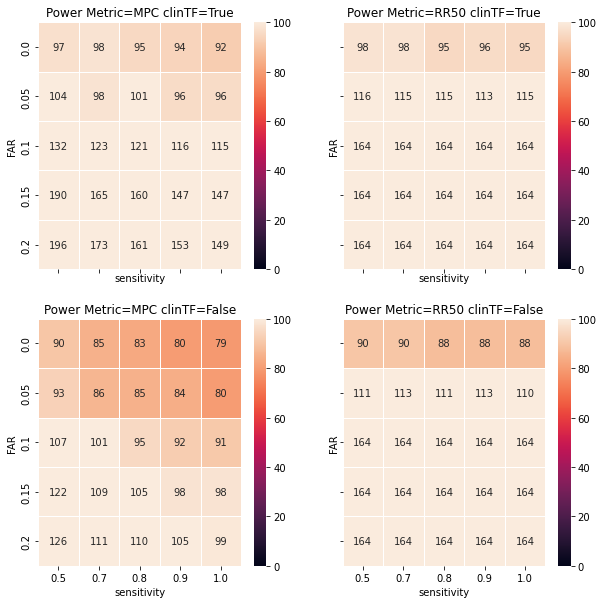

Inflater = 1


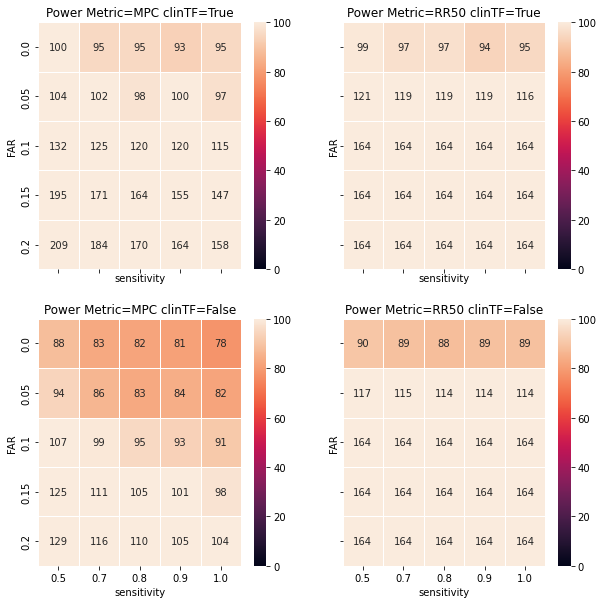

In [9]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
for inflater in [0,1]:
    print(f'Inflater = {inflater}')
    fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))   
    for ci,clinTF in enumerate([True,False]):
        fn = f'tryBigRange2_{clinTF}_nofar_inf{inflater}.csv'
        #buildSET_of_N([0.5,.7,.8,.9,1],[0,0.05,.1,.15,.2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
        drawGrid(fn,clinTF=clinTF,ax=ax[ci,:])
        
    plt.show()

sensitivity:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

[[ 9. 31. 13. 26.]
 [ 7. 33.  8. 31.]]
[[ 3. 37.  3. 37.]
 [ 3. 37.  3. 37.]]


sens  FAR  p1c  p2c    r1c    r2c  p1e  p2e    r1e    r2e
0     1    0  0.0  1.0  0.200  0.800  0.0  1.0  0.263  0.713
0     1   10  0.0  1.0  0.075  0.925  0.0  1.0  0.075  0.925

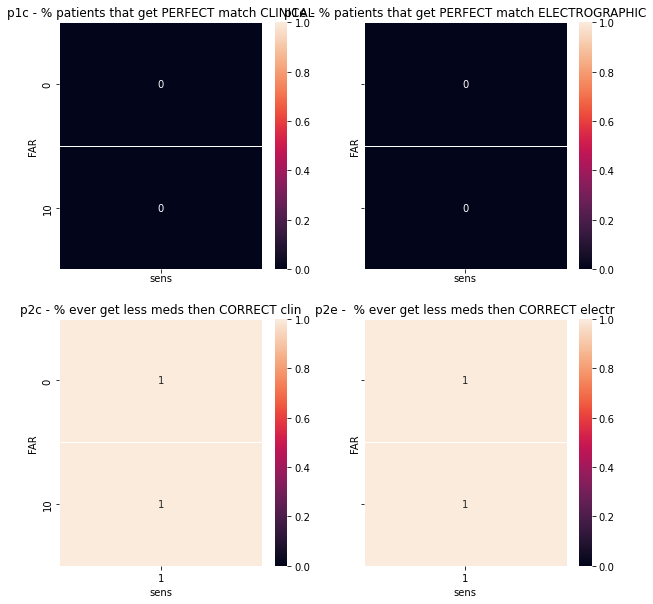

In [48]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt
from weargroup_v2 import simulate_clinic

#simulate_clinic(sensLIST=[0.5,1],FARlist=[0,.05,.1],N=100,yrs=10,numCPUs=9)
#simulate_clinic(sensLIST=[0.5,1],FARlist=[0,.1,1,10],N=1000,yrs=10,numCPUs=9)
simulate_clinic(sensLIST=[1],FARlist=[0,10],N=2,yrs=10,numCPUs=9)


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/danielgoldenholz/Documents/GitHub/WEARsimulator/weargroup_v2.py:387: RuntimeWarning: invalid value encountered in true_divide
  Xt = trueX.copy()
/Users/danielgoldenholz/Documents/GitHub/WEARsimulator/weargroup_v2.py:388: RuntimeWarning: invalid value encountered in true_divide
  


[474 108 182  32  22]


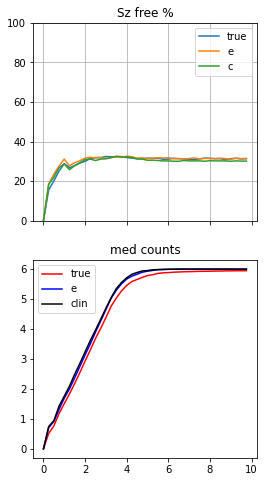

In [54]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt
from weargroup_v2 import show_me_one
show_me_one(sens=.5,FAR=0.1,N=1000,yrs=10,numCPUs=9)
 

In [118]:
successLIST = [0,.46,.28,.24,.15,0.14,0.14]
#successLIST = [0,.72,.18,.07,.02,0.01,0.01]
szFreeChances = np.zeros((1000,7))
for i in range(1000):
    szFreeChances[i,:] = np.less(np.random.random(6+1),successLIST)
np.mean(szFreeChances,axis=0)

BINS = [np.arange(15),np.arange(6)]
print(BINS)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([0, 1, 2, 3, 4, 5])]


sensitivity:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

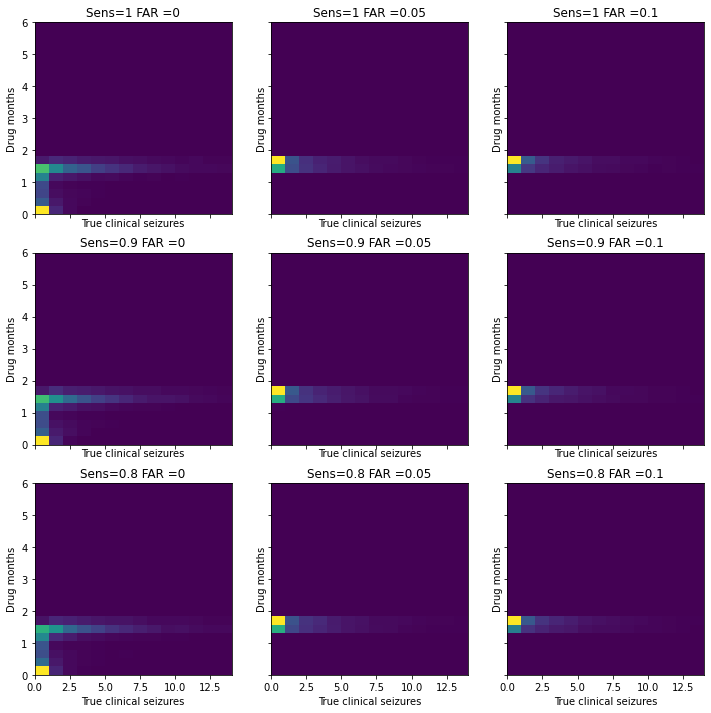

   sens   FAR  szfree  meanDrug    meanSz
0   1.0  0.00  0.6284  2.312403  1.045583
0   1.0  0.05  0.6306  2.114432  1.564804
0   1.0  0.10  0.6367  2.119767  1.578563
0   0.9  0.00  0.6293  2.342494  1.042477
0   0.9  0.05  0.6249  2.190733  1.564056
0   0.9  0.10  0.6430  2.139514  1.579366
0   0.8  0.00  0.6216  2.310760  1.035234
0   0.8  0.05  0.6315  2.136879  1.565552
0   0.8  0.10  0.6350  2.207634  1.581447


In [3]:
%reload_ext autoreload
%autoreload 2
from weargroup_v2 import do_some_sets
do_some_sets(inflater=10)


sensitivity:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

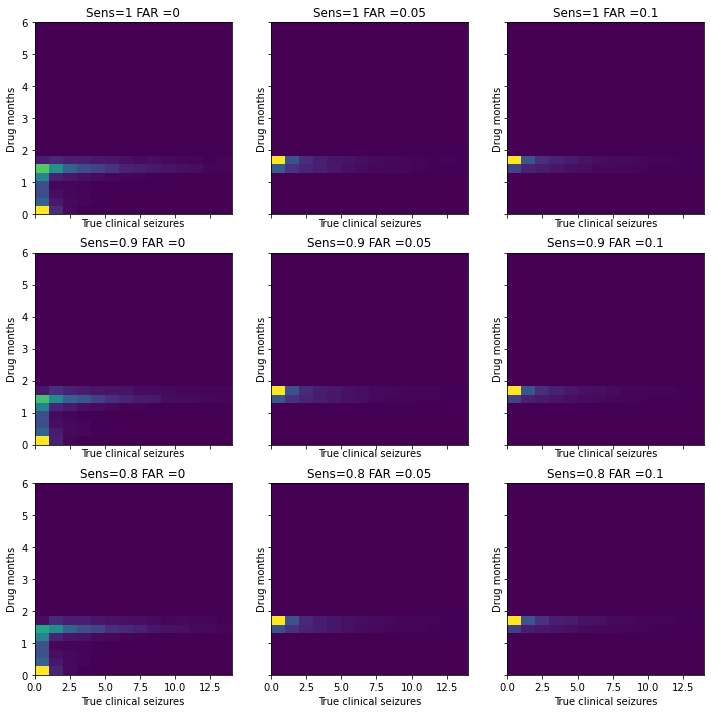

   sens   FAR  szfree  meanDrug    meanSz
0   1.0  0.00  0.6300  2.305819  1.045309
0   1.0  0.05  0.6344  2.166221  1.583738
0   1.0  0.10  0.6289  2.182805  1.599069
0   0.9  0.00  0.6280  2.239153  1.036631
0   0.9  0.05  0.6334  2.174779  1.584222
0   0.9  0.10  0.6306  2.083180  1.600719
0   0.8  0.00  0.6227  2.358627  1.030443
0   0.8  0.05  0.6325  2.166847  1.587297
0   0.8  0.10  0.6395  2.128068  1.603692


In [4]:
%reload_ext autoreload
%autoreload 2
from weargroup_v2 import do_some_sets
do_some_sets(inflater=2/3)

sensitivity:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

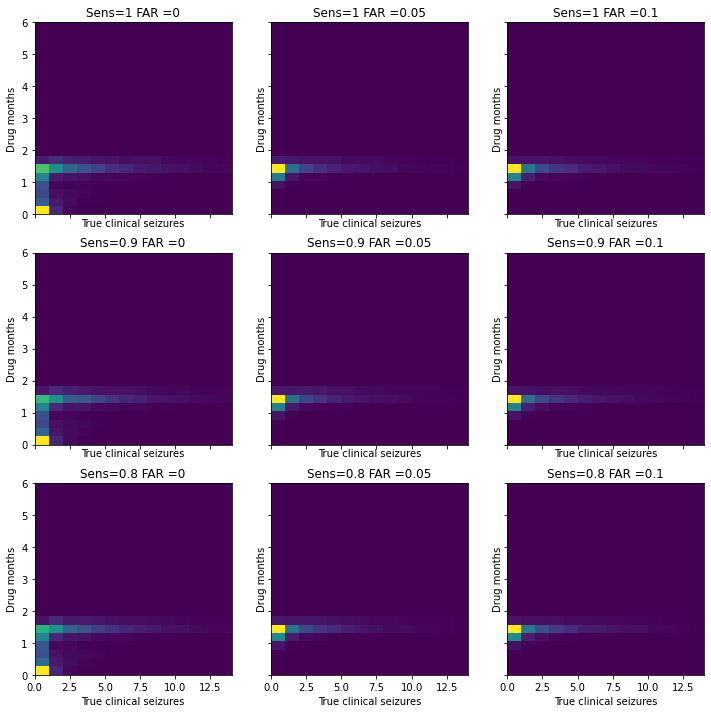

   sens   FAR  szfree  meanDrug    meanSz
0   1.0  0.00  0.6265  2.270173  1.043450
0   1.0  0.05  0.6407  2.230175  1.421448
0   1.0  0.10  0.6365  2.287953  1.410083
0   0.9  0.00  0.6322  2.339542  1.036853
0   0.9  0.05  0.6325  2.256131  1.419751
0   0.9  0.10  0.6341  2.257412  1.407942
0   0.8  0.00  0.6164  2.271548  1.026194
0   0.8  0.05  0.6364  2.292457  1.414018
0   0.8  0.10  0.6265  2.323212  1.405147


In [5]:
%reload_ext autoreload
%autoreload 2
from weargroup_v2 import do_some_sets
do_some_sets(inflater=100)

sensitivity:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

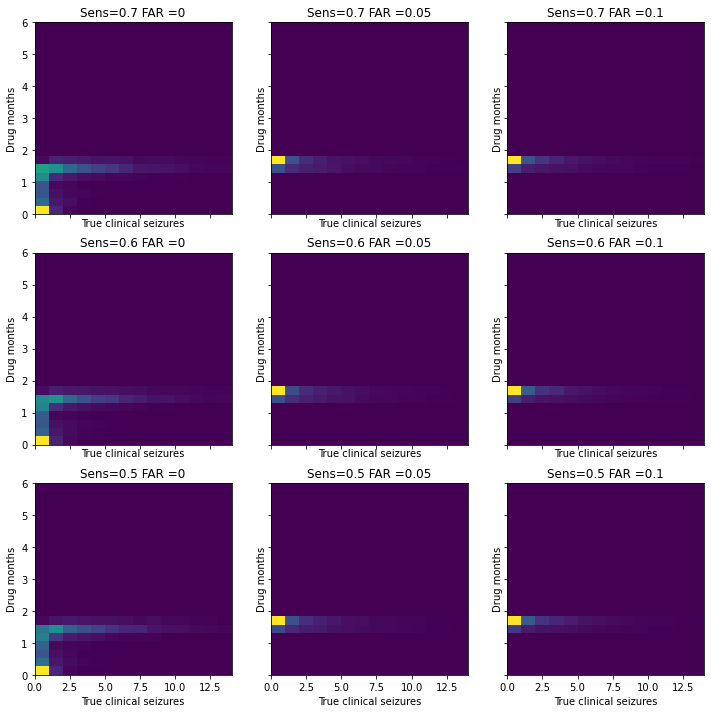

   sens   FAR  szfree  meanDrug    meanSz
0   0.7  0.00  0.6227  2.288106  1.015537
0   0.7  0.05  0.6295  2.146537  1.588801
0   0.7  0.10  0.6387  2.113988  1.603545
0   0.6  0.00  0.6268  2.301829  1.005927
0   0.6  0.05  0.6315  2.137076  1.589935
0   0.6  0.10  0.6284  2.064507  1.605928
0   0.5  0.00  0.6192  2.351363  0.989166
0   0.5  0.05  0.6382  2.155767  1.592622
0   0.5  0.10  0.6322  2.097527  1.608711


In [8]:
%reload_ext autoreload
%autoreload 2
from weargroup_v2 import do_some_sets
do_some_sets(inflater=2/3,sLIST=[.7,.6,.5],fLIST=[0,.05,.1])

sensitivity:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

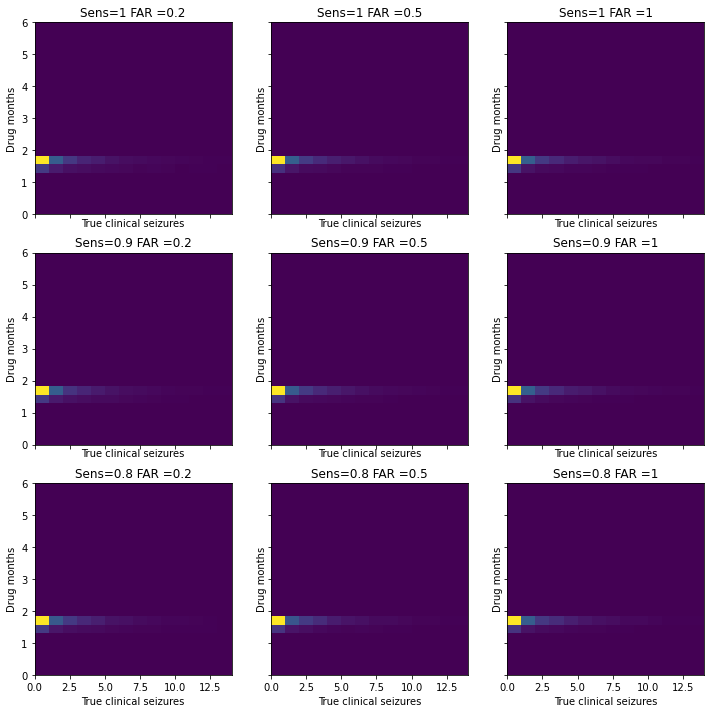

   sens  FAR  szfree  meanDrug    meanSz
0   1.0  0.2  0.6273  2.085511  1.611933
0   1.0  0.5  0.6413  2.061702  1.621658
0   1.0  1.0  0.6306  2.013652  1.623783
0   0.9  0.2  0.6380  2.107028  1.612089
0   0.9  0.5  0.6356  2.035416  1.621577
0   0.9  1.0  0.6398  2.017078  1.624724
0   0.8  0.2  0.6337  2.046975  1.615293
0   0.8  0.5  0.6295  2.020505  1.621596
0   0.8  1.0  0.6433  2.050686  1.624733


sensitivity:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

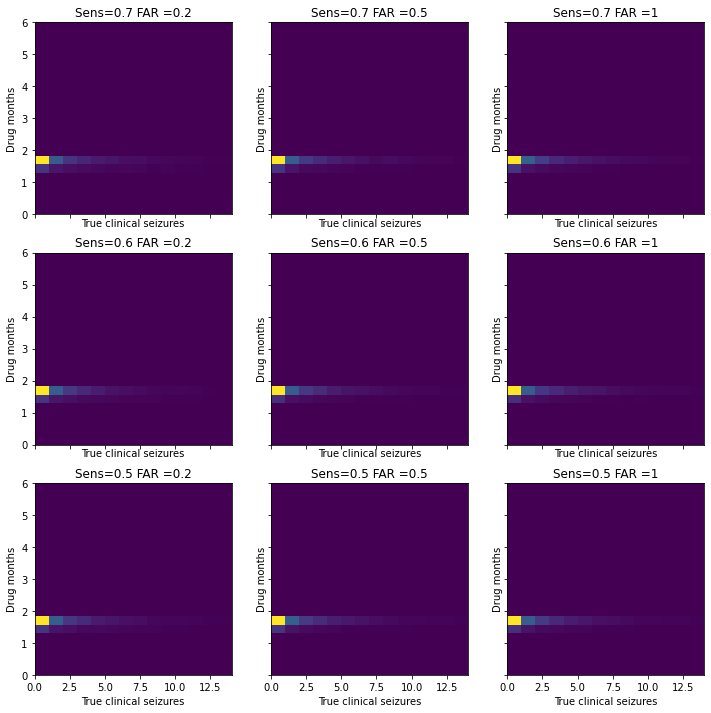

   sens  FAR  szfree  meanDrug    meanSz
0   0.7  0.2  0.6309  2.054843  1.615643
0   0.7  0.5  0.6429  2.070796  1.622948
0   0.7  1.0  0.6361  2.053774  1.624052
0   0.6  0.2  0.6438  2.037338  1.617163
0   0.6  0.5  0.6343  2.038288  1.623917
0   0.6  1.0  0.6393  2.084126  1.625087
0   0.5  0.2  0.6341  2.049172  1.619558
0   0.5  0.5  0.6341  2.033797  1.624399
0   0.5  1.0  0.6419  2.003343  1.624679


In [9]:
%reload_ext autoreload
%autoreload 2
from weargroup_v2 import do_some_sets
do_some_sets(inflater=2/3,sLIST=[1,.9,.8],fLIST=[.2,.5,1])
do_some_sets(inflater=2/3,sLIST=[.7,.6,.5],fLIST=[.2,.5,1])

In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
from weargroup_v2 import do_some_sets
N=10000
#df = do_some_sets(inflater=2/3,sLIST=[1,.9,.8],fLIST=[0,.05,.1],N=N,NOFIG=True)
df = do_some_sets(inflater=2/3,sLIST=[1,.9,.8,.7,.6,.5],fLIST=[0,.05,.1,.2,.5,1],N=N,NOFIG=True)


sensitivity:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/6 [00:00<?, ?it/s]

   sens   FAR  szfree  meanDrug    meanSz
0   1.0  0.00  0.6299  2.288205  1.044054
0   1.0  0.05  0.6368  2.302320  1.423035
0   1.0  0.10  0.6280  2.283313  1.050927
0   1.0  0.20  0.6351  2.278595  1.110866
0   1.0  0.50  0.6418  2.243586  1.269607
0   1.0  1.00  0.6255  2.272812  1.314379
0   0.9  0.00  0.6273  2.247579  1.030053
0   0.9  0.05  0.6333  2.205824  1.416633
0   0.9  0.10  0.6307  2.264223  1.039429
0   0.9  0.20  0.6307  2.277845  1.108286
0   0.9  0.50  0.6302  2.295545  1.270483
0   0.9  1.00  0.6325  2.368705  1.312869
0   0.8  0.00  0.6359  2.304438  1.028334
0   0.8  0.05  0.6349  2.184973  1.412642
0   0.8  0.10  0.6319  2.330773  1.028118
0   0.8  0.20  0.6294  2.335251  1.102869
0   0.8  0.50  0.6284  2.291187  1.264438
0   0.8  1.00  0.6362  2.310156  1.301177
0   0.7  0.00  0.6230  2.294062  1.010056
0   0.7  0.05  0.6329  2.320892  1.410971
0   0.7  0.10  0.6356  2.329795  1.009754
0   0.7  0.20  0.6387  2.354740  1.088648
0   0.7  0.50  0.6320  2.318846  1

In [6]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
from weargroup_v2 import do_some_sets
N=10000
df = do_some_sets(inflater=2/3,sLIST=[.5],fLIST=[0],N=N,NOFIG=True,fn='clinObsOnly.csv',clinTF=True)

sensitivity:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

   sens  FAR  szfree  meanDrug    meanSz
0   0.5    0  0.6215  2.305381  0.983228


In [7]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
from weargroup_v2 import do_some_sets
N=10000
df = do_some_sets(inflater=2/3,sLIST=[.5,.6,.7,.8,.9,1],fLIST=[0,.05,.1,.2,.5,1,2,10],N=N,NOFIG=True,fn='clin-fullsetClinTrueInf0.66.csv',clinTF=True)
df = do_some_sets(inflater=2/3,sLIST=[.5,.6,.7,.8,.9,1],fLIST=[0,.05,.1,.2,.5,1,2,10],N=N,NOFIG=True,fn='clin-fullsetClinFalseInf0.66.csv',clinTF=False)
df = do_some_sets(inflater=10,sLIST=[1],fLIST=[0,.05,.1,.2,.5,1,2,10],N=N,NOFIG=True,fn='clin-farsetClinTrueInf10.csv',clinTF=True)
df = do_some_sets(inflater=100,sLIST=[1],fLIST=[0,.05,.1,.2,.5,1,2,10],N=N,NOFIG=True,fn='clin-farsetClinTrueInf100.csv',clinTF=True)



sensitivity:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

   sens    FAR  szfree  meanDrug    meanSz
0   0.5   0.00  0.6173  2.367223  0.990198
0   0.5   0.05  0.6335  2.297527  1.400969
0   0.5   0.10  0.6281  2.349222  0.982527
0   0.5   0.20  0.6281  2.356994  1.062181
0   0.5   0.50  0.6399  2.266596  1.223647
0   0.5   1.00  0.6339  2.273843  1.272636
0   0.5   2.00  0.6376  2.366993  1.276948
0   0.5  10.00  0.6386  2.564550  1.221079
0   0.6   0.00  0.6287  2.291018  0.997534
0   0.6   0.05  0.6297  2.297407  1.406476
0   0.6   0.10  0.6201  2.311078  1.015173
0   0.6   0.20  0.6349  2.315818  1.073878
0   0.6   0.50  0.6304  2.322167  1.247211
0   0.6   1.00  0.6229  2.304395  1.287256
0   0.6   2.00  0.6325  2.382610  1.290385
0   0.6  10.00  0.6275  2.515140  1.235218
0   0.7   0.00  0.6207  2.257163  1.016597
0   0.7   0.05  0.6368  2.210678  1.410133
0   0.7   0.10  0.6216  2.335760  1.020853
0   0.7   0.20  0.6206  2.276526  1.091961
0   0.7   0.50  0.6334  2.291413  1.253231
0   0.7   1.00  0.6355  2.319836  1.294613
0   0.7   2

sensitivity:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

   sens    FAR  szfree  meanDrug    meanSz
0   0.5   0.00  0.6421  5.272617  1.093152
0   0.5   0.05  0.6395  5.107124  1.437612
0   0.5   0.10  0.6394  5.158570  1.090871
0   0.5   0.20  0.6321  5.226407  1.165132
0   0.5   0.50  0.6421  5.140239  1.305793
0   0.5   1.00  0.6301  5.310568  1.351302
0   0.5   2.00  0.6340  5.241510  1.353948
0   0.5  10.00  0.6400  5.527978  1.288905
0   0.6   0.00  0.6293  5.260617  1.114739
0   0.6   0.05  0.6313  5.175258  1.443081
0   0.6   0.10  0.6352  5.171095  1.108182
0   0.6   0.20  0.6355  5.292534  1.175304
0   0.6   0.50  0.6368  5.178820  1.316902
0   0.6   1.00  0.6297  5.211365  1.358353
0   0.6   2.00  0.6256  5.153262  1.364158
0   0.6  10.00  0.6396  5.511118  1.303312
0   0.7   0.00  0.6349  5.315747  1.112191
0   0.7   0.05  0.6298  5.083169  1.446520
0   0.7   0.10  0.6318  5.345203  1.126683
0   0.7   0.20  0.6367  5.270344  1.174400
0   0.7   0.50  0.6367  5.227304  1.330459
0   0.7   1.00  0.6349  5.126881  1.362391
0   0.7   2

sensitivity:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

   sens    FAR  szfree  meanDrug    meanSz
0     1   0.00  0.6261  2.330475  1.055983
0     1   0.05  0.6270  2.273043  1.387933
0     1   0.10  0.6378  2.276448  1.316147
0     1   0.20  0.6355  2.268971  1.306475
0     1   0.50  0.6318  2.341239  1.275099
0     1   1.00  0.6355  2.548148  1.244082
0     1   2.00  0.6400  2.634359  1.207866
0     1  10.00  0.6370  2.892515  1.153200


sensitivity:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

   sens    FAR  szfree  meanDrug    meanSz
0     1   0.00  0.6275  2.287060  1.045209
0     1   0.05  0.6367  2.280063  1.322564
0     1   0.10  0.6364  2.405434  1.274156
0     1   0.20  0.6230  2.531607  1.230286
0     1   0.50  0.6328  2.704738  1.180568
0     1   1.00  0.6240  2.864080  1.157183
0     1   2.00  0.6279  2.986932  1.143438
0     1  10.00  0.6186  2.991213  1.135725


In [8]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
from weargroup_v2 import do_some_sets
N=10000
df = do_some_sets(inflater=0,sLIST=[1],fLIST=[0,.05,.1,.2,.5,1,2,10],N=N,NOFIG=True,fn='clin-farsetClinTrueInf0.csv',clinTF=True)
df = do_some_sets(inflater=1,sLIST=[1],fLIST=[0,.05,.1,.2,.5,1,2,10],N=N,NOFIG=True,fn='clin-farsetClinTrueInf1.csv',clinTF=True)


sensitivity:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

   sens    FAR  szfree  meanDrug    meanSz
0     1   0.00  0.6221  2.318032  1.048448
0     1   0.05  0.6280  2.256822  1.046905
0     1   0.10  0.6249  2.301116  1.056646
0     1   0.20  0.6294  2.296896  1.045102
0     1   0.50  0.6265  2.320312  1.053192
0     1   1.00  0.6293  2.294281  1.048082
0     1   2.00  0.6265  2.282243  1.042099
0     1  10.00  0.6312  2.292314  1.040839


sensitivity:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/8 [00:00<?, ?it/s]

   sens    FAR  szfree  meanDrug    meanSz
0     1   0.00  0.6160  2.300550  1.055652
0     1   0.05  0.6404  2.193082  1.423551
0     1   0.10  0.6372  2.274983  1.066191
0     1   0.20  0.6302  2.298274  1.201596
0     1   0.50  0.6370  2.205343  1.304094
0     1   1.00  0.6338  2.252800  1.323488
0     1   2.00  0.6345  2.344986  1.315686
0     1  10.00  0.6324  2.513573  1.241623


In [5]:
# THIS IS CLINIC CASE
%reload_ext autoreload
%autoreload 2
import pandas as pd
from weargroup_v2 import do_some_sets
N=10000
df = do_some_sets(inflater=100,sLIST=[1,.9,.8,.7,.6,.5],fLIST=[0,.05,.1,.2,.5,1],N=N,NOFIG=True)
df2 = do_some_sets(inflater=2/3,sLIST=[0.5],fLIST=[0,10,100],N=N,NOFIG=True)



sensitivity:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/6 [00:00<?, ?it/s]

FAR:   0%|          | 0/6 [00:00<?, ?it/s]

   sens   FAR  szfree  meanDrug    meanSz
0   1.0  0.00  0.6269  2.269124  1.048145
0   1.0  0.05  0.6361  2.313853  1.322179
0   1.0  0.10  0.6317  2.386070  1.275667
0   1.0  0.20  0.6367  2.424603  1.230838
0   1.0  0.50  0.6299  2.724713  1.181641
0   1.0  1.00  0.6356  2.870911  1.153714
0   0.9  0.00  0.6245  2.328917  1.045062
0   0.9  0.05  0.6293  2.294492  1.320762
0   0.9  0.10  0.6367  2.397866  1.266298
0   0.9  0.20  0.6336  2.521691  1.224992
0   0.9  0.50  0.6405  2.762082  1.177242
0   0.9  1.00  0.6246  2.844842  1.154797
0   0.8  0.00  0.6221  2.279667  1.029502
0   0.8  0.05  0.6339  2.301972  1.309314
0   0.8  0.10  0.6361  2.416022  1.258037
0   0.8  0.20  0.6415  2.503611  1.218797
0   0.8  0.50  0.6321  2.755493  1.170433
0   0.8  1.00  0.6338  2.960226  1.152054
0   0.7  0.00  0.6183  2.307550  1.021521
0   0.7  0.05  0.6341  2.350834  1.304593
0   0.7  0.10  0.6405  2.419241  1.246407
0   0.7  0.20  0.6404  2.559065  1.211204
0   0.7  0.50  0.6302  2.789130  1

sensitivity:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

   sens  FAR  szfree  meanDrug    meanSz
0   0.5    0  0.6130  2.363413  0.991664
0   0.5   10  0.6311  2.536772  1.218317
0   0.5  100  0.6311  2.879851  1.149562


sensitivity: 100%|██████████| 6/6 [01:27<00:00, 14.64s/it]


   sens  FAR  szfree  meanDrug    meanSz
0   0.5    0  0.6179  3.871795  1.111111
0   0.6    0  0.6229  3.923077  1.102564
0   0.7    0  0.6219  3.974359  1.076923
0   0.8    0  0.6152  4.051282  1.085470
0   0.9    0  0.6256  4.051282  1.085470
0   1.0    0  0.6239  4.128205  1.076923


sensitivity: 100%|██████████| 6/6 [01:22<00:00, 13.81s/it]


   sens       FAR  szfree  meanDrug    meanSz
0   0.5  0.011111  0.6229  3.846154  1.102564
0   0.6  0.011111  0.6252  3.948718  1.102564
0   0.7  0.011111  0.6213  4.000000  1.076923
0   0.8  0.011111  0.6227  4.051282  1.059829
0   0.9  0.011111  0.6273  4.076923  1.051282
0   1.0  0.011111  0.6253  4.102564  1.094017


sensitivity: 100%|██████████| 6/6 [01:20<00:00, 13.38s/it]


   sens       FAR  szfree  meanDrug    meanSz
0   0.5  0.022222  0.6119  3.897436  1.145299
0   0.6  0.022222  0.6250  3.974359  1.102564
0   0.7  0.022222  0.6333  3.974359  1.076923
0   0.8  0.022222  0.6256  4.051282  1.085470
0   0.9  0.022222  0.6339  4.076923  1.042735
0   1.0  0.022222  0.6283  4.102564  1.068376


sensitivity: 100%|██████████| 6/6 [01:19<00:00, 13.23s/it]


   sens       FAR  szfree  meanDrug    meanSz
0   0.5  0.033333  0.6172  3.871795  1.094017
0   0.6  0.033333  0.6125  3.974359  1.115385
0   0.7  0.033333  0.6267  4.025641  1.136752
0   0.8  0.033333  0.6347  4.051282  1.076923
0   0.9  0.033333  0.6371  4.051282  1.042735
0   1.0  0.033333  0.6278  4.102564  1.068376


sensitivity: 100%|██████████| 6/6 [01:19<00:00, 13.30s/it]


   sens       FAR  szfree  meanDrug    meanSz
0   0.5  0.044444  0.6238  3.846154  1.068376
0   0.6  0.044444  0.6219  3.923077  1.094017
0   0.7  0.044444  0.6216  4.025641  1.085470
0   0.8  0.044444  0.6297  4.025641  1.076923
0   0.9  0.044444  0.6361  4.076923  1.042735
0   1.0  0.044444  0.6330  4.076923  1.051282


sensitivity: 100%|██████████| 6/6 [01:20<00:00, 13.40s/it]


   sens       FAR  szfree  meanDrug    meanSz
0   0.5  0.055556  0.6220  3.846154  1.106838
0   0.6  0.055556  0.6256  3.948718  1.102564
0   0.7  0.055556  0.6186  4.000000  1.094017
0   0.8  0.055556  0.6278  4.025641  1.076923
0   0.9  0.055556  0.6232  4.076923  1.094017
0   1.0  0.055556  0.6233  4.102564  1.059829


sensitivity: 100%|██████████| 6/6 [01:20<00:00, 13.37s/it]

   sens       FAR  szfree  meanDrug    meanSz
0   0.5  0.066667  0.6269  3.820513  1.136752
0   0.6  0.066667  0.6230  3.948718  1.102564
0   0.7  0.066667  0.6175  4.000000  1.059829
0   0.8  0.066667  0.6245  4.051282  1.085470
0   0.9  0.066667  0.6293  4.076923  1.068376
0   1.0  0.066667  0.6332  4.102564  1.068376


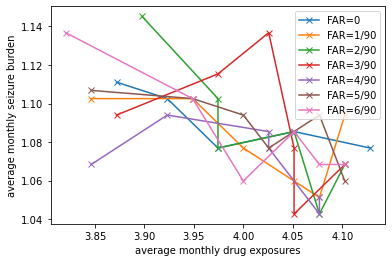

In [19]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
from weargroup_v2 import do_some_sets,sim1clinic
import matplotlib.pyplot as plt
N=10000

fLIST = [0]
df = do_some_sets(inflater=2/3,sLIST=[0.5,.6,.7,.8,.9,1],fLIST=fLIST,N=N,NOFIG=True,fn='',clinTF=True)
plt.plot(df.meanDrug,df.meanSz,'x-',label='FAR=0')
fLIST = [1/90]
df = do_some_sets(inflater=2/3,sLIST=[0.5,.6,.7,.8,.9,1],fLIST=fLIST,N=N,NOFIG=True,fn='',clinTF=True)
plt.plot(df.meanDrug,df.meanSz,'x-',label='FAR=1/90')
fLIST = [2/90]
df = do_some_sets(inflater=2/3,sLIST=[0.5,.6,.7,.8,.9,1],fLIST=fLIST,N=N,NOFIG=True,fn='',clinTF=True)
plt.plot(df.meanDrug,df.meanSz,'x-',label='FAR=2/90')
fLIST = [3/90]
df = do_some_sets(inflater=2/3,sLIST=[0.5,.6,.7,.8,.9,1],fLIST=fLIST,N=N,NOFIG=True,fn='',clinTF=True)
plt.plot(df.meanDrug,df.meanSz,'x-',label='FAR=3/90')
fLIST = [4/90]
df = do_some_sets(inflater=2/3,sLIST=[0.5,.6,.7,.8,.9,1],fLIST=fLIST,N=N,NOFIG=True,fn='',clinTF=True)
plt.plot(df.meanDrug,df.meanSz,'x-',label='FAR=4/90')
fLIST = [5/90]
df = do_some_sets(inflater=2/3,sLIST=[0.5,.6,.7,.8,.9,1],fLIST=fLIST,N=N,NOFIG=True,fn='',clinTF=True)
plt.plot(df.meanDrug,df.meanSz,'x-',label='FAR=5/90')
fLIST = [6/90]
df = do_some_sets(inflater=2/3,sLIST=[0.5,.6,.7,.8,.9,1],fLIST=fLIST,N=N,NOFIG=True,fn='',clinTF=True)
plt.plot(df.meanDrug,df.meanSz,'x-',label='FAR=6/90')

plt.xlabel('average monthly drug exposures')
plt.ylabel('average monthly seizure burden')
plt.legend()
plt.show()


In [6]:
# INJURY CASE

%reload_ext autoreload
%autoreload 2
from weargroup_v2 import run_injury_case
import numpy as np
import pandas as pd

xf = pd.DataFrame()
for sens in np.linspace(0.5,1,6):
    for clinTF in [True,False]:
        x = run_injury_case(sens=sens,FAR=0,N=10000,numCPUs=9,clinTF=clinTF)
        xf = pd.concat([xf,x])
xf.to_csv('Injury_case.csv',index=False)

100%|██████████| 10000/10000 [42:28<00:00,  3.92it/s]


   clinTF  sens  rate  detected%  noInjury  total    mean
0    True   0.5     3         50      7452   2913  0.2913


100%|██████████| 10000/10000 [41:31<00:00,  4.01it/s]


   clinTF  sens  rate  detected%  noInjury   total     mean
0    True   0.5   300         49        14  229093  22.9093


100%|██████████| 10000/10000 [41:29<00:00,  4.02it/s]


   clinTF  sens  rate  detected%  noInjury  total    mean
0   False   0.5     3         49      7450   2923  0.2923


100%|██████████| 10000/10000 [41:44<00:00,  3.99it/s]


   clinTF  sens  rate  detected%  noInjury   total     mean
0   False   0.5   300         50        25  229247  22.9247


100%|██████████| 10000/10000 [41:39<00:00,  4.00it/s]


   clinTF  sens  rate  detected%  noInjury  total    mean
0    True   0.6     3         60      7436   2946  0.2946


100%|██████████| 10000/10000 [41:37<00:00,  4.00it/s]


   clinTF  sens  rate  detected%  noInjury   total     mean
0    True   0.6   300         59        26  227647  22.7647


100%|██████████| 10000/10000 [41:28<00:00,  4.02it/s]


   clinTF  sens  rate  detected%  noInjury  total    mean
0   False   0.6     3         60      7458   2964  0.2964


100%|██████████| 10000/10000 [41:30<00:00,  4.02it/s]


   clinTF  sens  rate  detected%  noInjury   total     mean
0   False   0.6   300         60        29  230137  23.0137


100%|██████████| 10000/10000 [41:29<00:00,  4.02it/s]


   clinTF  sens  rate  detected%  noInjury  total    mean
0    True   0.7     3         67      7490   2891  0.2891


100%|██████████| 10000/10000 [41:25<00:00,  4.02it/s]


   clinTF  sens  rate  detected%  noInjury   total     mean
0    True   0.7   300         69        26  229394  22.9394


100%|██████████| 10000/10000 [41:29<00:00,  4.02it/s]


   clinTF  sens  rate  detected%  noInjury  total    mean
0   False   0.7     3         68      7394   2989  0.2989


100%|██████████| 10000/10000 [41:32<00:00,  4.01it/s]


   clinTF  sens  rate  detected%  noInjury   total   mean
0   False   0.7   300         69        21  229300  22.93


100%|██████████| 10000/10000 [41:42<00:00,  4.00it/s]


   clinTF  sens  rate  detected%  noInjury  total    mean
0    True   0.8     3         79      7376   3058  0.3058


100%|██████████| 10000/10000 [41:29<00:00,  4.02it/s]


   clinTF  sens  rate  detected%  noInjury   total    mean
0    True   0.8   300         80        25  228850  22.885


100%|██████████| 10000/10000 [41:35<00:00,  4.01it/s]


   clinTF  sens  rate  detected%  noInjury  total    mean
0   False   0.8     3         78      7478   2897  0.2897


100%|██████████| 10000/10000 [41:19<00:00,  4.03it/s]


   clinTF  sens  rate  detected%  noInjury   total     mean
0   False   0.8   300         80        24  228922  22.8922


100%|██████████| 10000/10000 [42:38<00:00,  3.91it/s]


   clinTF  sens  rate  detected%  noInjury  total   mean
0    True   0.9     3         90      7453   2950  0.295


100%|██████████| 10000/10000 [43:29<00:00,  3.83it/s]


   clinTF  sens  rate  detected%  noInjury   total     mean
0    True   0.9   300         90        17  230069  23.0069


100%|██████████| 10000/10000 [43:22<00:00,  3.84it/s]


   clinTF  sens  rate  detected%  noInjury  total    mean
0   False   0.9     3         89      7453   2945  0.2945


100%|██████████| 10000/10000 [43:34<00:00,  3.82it/s]


   clinTF  sens  rate  detected%  noInjury   total     mean
0   False   0.9   300         90        22  228924  22.8924


100%|██████████| 10000/10000 [07:08<00:00, 23.36it/s]


   clinTF  sens  rate  detected%  noInjury  total    mean
0    True   1.0     3        100      7458   2949  0.2949


100%|██████████| 10000/10000 [07:04<00:00, 23.55it/s]


   clinTF  sens  rate  detected%  noInjury   total     mean
0    True   1.0   300        100        19  229572  22.9572


100%|██████████| 10000/10000 [07:05<00:00, 23.48it/s]


   clinTF  sens  rate  detected%  noInjury  total    mean
0   False   1.0     3        100      7450   2989  0.2989


100%|██████████| 10000/10000 [07:10<00:00, 23.24it/s]


   clinTF  sens  rate  detected%  noInjury   total     mean
0   False   1.0   300        100        26  229532  22.9532


clinTF  sens  rate  detected%  noInjury   total     mean
0    True   0.5     3         50      7452    2913   0.2913
0    True   0.5   300         49        14  229093  22.9093
0   False   0.5     3         49      7450    2923   0.2923
0   False   0.5   300         50        25  229247  22.9247
0    True   0.6     3         60      7436    2946   0.2946
0    True   0.6   300         59        26  227647  22.7647
0   False   0.6     3         60      7458    2964   0.2964
0   False   0.6   300         60        29  230137  23.0137
0    True   0.7     3         67      7490    2891   0.2891
0    True   0.7   300         69        26  229394  22.9394
0   False   0.7     3         68      7394    2989   0.2989
0   False   0.7   300         69        21  229300  22.9300
0    True   0.8     3         79      7376    3058   0.3058
0    True   0.8   300         80        25  228850  22.8850
0   False   0.8     3         78      7478    2897   0.2897
0   False   0.8   300         80        24  228922  22.8922
0    True   0.9     3         90      7453    2950   0.2950
0    True   0.9   300         90        17  230069  23.0069
0   False   0.9     3         89      7453    2945   0.2945
0   False   0.9   300         90        22  228924  22.8924
0    True   1.0     3        100      7458    2949   0.2949
0    True   1.0   300        100        19  229572  22.9572
0   False   1.0     3        100      7450    2989   0.2989
0   False   1.0   300        100        26  229532  22.9532

In [55]:
%reload_ext autoreload
%autoreload 2
from weargroup_v2 import do_all_injury_cases

do_all_injury_cases()


100%|██████████| 10000/10000 [44:43<00:00,  3.73it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.5    0     4         50      6297   4637  0.4637


100%|██████████| 10000/10000 [41:47<00:00,  3.99it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.5    0   296         50        23  226868  22.6868


100%|██████████| 10000/10000 [43:18<00:00,  3.85it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.5    0     4         50      6196   4658  0.4658


100%|██████████| 10000/10000 [41:16<00:00,  4.04it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.5    0   296         50        17  227825  22.7825


100%|██████████| 10000/10000 [41:37<00:00,  4.00it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total   mean
0    True   0.6    0     4         60      6230   4680  0.468


100%|██████████| 10000/10000 [41:36<00:00,  4.00it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.6    0   296         59        19  227409  22.7409


100%|██████████| 10000/10000 [41:27<00:00,  4.02it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.6    0     4         59      6197   4786  0.4786


100%|██████████| 10000/10000 [41:46<00:00,  3.99it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.6    0   296         59        22  226275  22.6275


100%|██████████| 10000/10000 [41:33<00:00,  4.01it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.7    0     4         70      6231   4689  0.4689


100%|██████████| 10000/10000 [41:29<00:00,  4.02it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.7    0   296         70        16  226467  22.6467


100%|██████████| 10000/10000 [41:25<00:00,  4.02it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.7    0     4         70      6278   4641  0.4641


100%|██████████| 10000/10000 [41:37<00:00,  4.00it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.7    0   296         70        25  226905  22.6905


100%|██████████| 10000/10000 [41:24<00:00,  4.03it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total  mean
0    True   0.8    0     4         80      6286   4600  0.46


100%|██████████| 10000/10000 [41:33<00:00,  4.01it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.8    0   296         80        24  227669  22.7669


100%|██████████| 10000/10000 [41:40<00:00,  4.00it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.8    0     4         80      6307   4521  0.4521


100%|██████████| 10000/10000 [41:36<00:00,  4.01it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.8    0   296         80        22  227324  22.7324


100%|██████████| 10000/10000 [41:17<00:00,  4.04it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.9    0     4         89      6222   4671  0.4671


100%|██████████| 10000/10000 [42:19<00:00,  3.94it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.9    0   296         89        22  227915  22.7915


100%|██████████| 10000/10000 [44:26<00:00,  3.75it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.9    0     4         89      6255   4676  0.4676


100%|██████████| 10000/10000 [44:39<00:00,  3.73it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.9    0   296         90        20  226487  22.6487


100%|██████████| 10000/10000 [07:26<00:00, 22.37it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   1.0    0     4        100      6227   4704  0.4704


100%|██████████| 10000/10000 [06:59<00:00, 23.82it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total    mean
0    True   1.0    0   296        100        20  225170  22.517


100%|██████████| 10000/10000 [07:06<00:00, 23.46it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   1.0    0     4        100      6251   4623  0.4623


100%|██████████| 10000/10000 [06:55<00:00, 24.09it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   1.0    0   296        100        22  225383  22.5383
   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.5    0     4         50      6297    4637   0.4637
0    True   0.5    0   296         50        23  226868  22.6868
0   False   0.5    0     4         50      6196    4658   0.4658
0   False   0.5    0   296         50        17  227825  22.7825
0    True   0.6    0     4         60      6230    4680   0.4680
0    True   0.6    0   296         59        19  227409  22.7409
0   False   0.6    0     4         59      6197    4786   0.4786
0   False   0.6    0   296         59        22  226275  22.6275
0    True   0.7    0     4         70      6231    4689   0.4689
0    True   0.7    0   296         70        16  226467  22.6467
0   False   0.7    0     4         70      6278    4641   0.4641
0   False   0.7    0   296         70        25  226905  22.6905
0    True   0.8    0     

In [3]:
%reload_ext autoreload
%autoreload 2
from weargroup_v2 import run_injury_case
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

xf = pd.DataFrame()
for fi,FAR in enumerate(tqdm([0,.5,1,2])):
    for si,sens in enumerate(tqdm(np.linspace(0.5,1,6))):
        for clinTF in [True,False]:
            x = run_injury_case(sens=sens,FAR=FAR,N=10000,numCPUs=9,clinTF=clinTF)
            xf = pd.concat([xf,x])
            xf.to_csv('injuryCSV.csv',index=False)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.5    0     3         50      7439   2884  0.2884


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.5    0   300         49        14  229736  22.9736


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.5    0     3         51      7476   2906  0.2906


   clinTF  sens  FAR  rate  detected%  noInjury   total   mean
0   False   0.5    0   300         50        30  229400  22.94


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.6    0     3         61      7434   2952  0.2952
























































































































































































































































































































































































































































































































































 29%|██▉       | 2879/10000 [4:07:56<10:13:15,  5.17s/it]


























































































































































































































































































































































































































   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.6    0   300         59        25  228798  22.8798


100%|██████████| 10000/10000 [45:58<00:00,  3.63it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.6    0     3         61      7477   2924  0.2924


100%|██████████| 10000/10000 [44:17<00:00,  3.76it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.6    0   300         60        14  229233  22.9233


100%|██████████| 10000/10000 [43:55<00:00,  3.79it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.7    0     3         70      7375   3045  0.3045


100%|██████████| 10000/10000 [42:55<00:00,  3.88it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.7    0   300         70        27  229172  22.9172


100%|██████████| 10000/10000 [43:29<00:00,  3.83it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total  mean
0   False   0.7    0     3         69      7389   3000   0.3


100%|██████████| 10000/10000 [41:57<00:00,  3.97it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.7    0   300         69        23  228267  22.8267


100%|██████████| 10000/10000 [41:56<00:00,  3.97it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.8    0     3         80      7471   2913  0.2913


100%|██████████| 10000/10000 [43:20<00:00,  3.85it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.8    0   300         79        22  229295  22.9295


100%|██████████| 10000/10000 [44:04<00:00,  3.78it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.8    0     3         80      7446   2936  0.2936


100%|██████████| 10000/10000 [44:31<00:00,  3.74it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total    mean
0   False   0.8    0   300         79        15  228740  22.874


100%|██████████| 10000/10000 [42:02<00:00,  3.96it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.9    0     3         90      7441   2937  0.2937


100%|██████████| 10000/10000 [41:43<00:00,  4.00it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.9    0   300         89        21  229181  22.9181


100%|██████████| 10000/10000 [41:37<00:00,  4.00it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.9    0     3         89      7458   2915  0.2915


100%|██████████| 10000/10000 [41:45<00:00,  3.99it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.9    0   300         90        20  228512  22.8512


100%|██████████| 10000/10000 [06:51<00:00, 24.28it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   1.0    0     3        100      7480   2906  0.2906


100%|██████████| 10000/10000 [06:48<00:00, 24.47it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   1.0    0   300        100        21  227917  22.7917


100%|██████████| 10000/10000 [06:50<00:00, 24.39it/s]


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   1.0    0     3        100      7498   2898  0.2898


100%|██████████| 10000/10000 [06:49<00:00, 24.41it/s]


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   1.0    0   300        100         8  228965  22.8965


  0%|          | 0/6 [00:00<?, ?it/s]

   clinTF  sens  FAR  rate  detected%  noInjury  total   mean
0    True   0.5  0.5     3         50      7438   2930  0.293


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.5  0.5   300         50        15  229505  22.9505


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.5  0.5     3         49      7421   2948  0.2948


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.5  0.5   300         49        15  229073  22.9073


   clinTF  sens  FAR  rate  detected%  noInjury  total   mean
0    True   0.6  0.5     3         60      7479   2890  0.289


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.6  0.5   300         60        21  229533  22.9533


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.6  0.5     3         58      7421   2969  0.2969


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.6  0.5   300         60        23  228261  22.8261


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.7  0.5     3         69      7399   2997  0.2997


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.7  0.5   300         69        16  230128  23.0128


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.7  0.5     3         69      7491   2875  0.2875


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.7  0.5   300         69        27  229162  22.9162


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.8  0.5     3         80      7486   2902  0.2902


   clinTF  sens  FAR  rate  detected%  noInjury   total    mean
0    True   0.8  0.5   300         80        27  230850  23.085


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.8  0.5     3         80      7498   2841  0.2841


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.8  0.5   300         79        22  228384  22.8384


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.9  0.5     3         89      7396   2995  0.2995


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.9  0.5   300         90        20  229066  22.9066


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.9  0.5     3         90      7428   2959  0.2959


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.9  0.5   300         89        23  229991  22.9991


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   1.0  0.5     3        100      7526   2831  0.2831


   clinTF  sens  FAR  rate  detected%  noInjury   total   mean
0    True   1.0  0.5   300        100        24  229200  22.92


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   1.0  0.5     3        100      7535   2834  0.2834


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   1.0  0.5   300        100        23  229921  22.9921


  0%|          | 0/6 [00:00<?, ?it/s]

   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.5    1     3         49      7473   2933  0.2933


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.5    1   300         49        20  229895  22.9895


   clinTF  sens  FAR  rate  detected%  noInjury  total   mean
0   False   0.5    1     3         51      7444   2940  0.294


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.5    1   300         50        19  229528  22.9528


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.6    1     3         60      7450   2967  0.2967


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.6    1   300         59         6  229568  22.9568


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.6    1     3         58      7502   2867  0.2867


   clinTF  sens  FAR  rate  detected%  noInjury   total    mean
0   False   0.6    1   300         59        26  228630  22.863


   clinTF  sens  FAR  rate  detected%  noInjury  total  mean
0    True   0.7    1     3         70      7484   2900  0.29


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.7    1   300         70        20  229381  22.9381


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.7    1     3         69      7447   2939  0.2939


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.7    1   300         70        23  228637  22.8637


   clinTF  sens  FAR  rate  detected%  noInjury  total   mean
0    True   0.8    1     3         80      7465   2870  0.287


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.8    1   300         80        23  229334  22.9334


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.8    1     3         80      7417   2988  0.2988


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.8    1   300         79        21  229208  22.9208


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.9    1     3         89      7429   2963  0.2963


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.9    1   300         90        24  229422  22.9422


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.9    1     3         90      7454   2973  0.2973


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.9    1   300         89        21  229102  22.9102


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   1.0    1     3        100      7469   2896  0.2896


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   1.0    1   300        100        26  228367  22.8367


   clinTF  sens  FAR  rate  detected%  noInjury  total   mean
0   False   1.0    1     3        100      7508   2860  0.286


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   1.0    1   300        100        22  229152  22.9152


  0%|          | 0/6 [00:00<?, ?it/s]

   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.5    2     3         49      7516   2847  0.2847


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.5    2   300         49        16  229347  22.9347


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.5    2     3         49      7489   2825  0.2825


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.5    2   300         49        33  227546  22.7546


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.6    2     3         59      7398   3004  0.3004


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.6    2   300         59        29  229171  22.9171


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.6    2     3         59      7522   2849  0.2849


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.6    2   300         59        20  229713  22.9713


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.7    2     3         71      7467   2874  0.2874


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.7    2   300         69        20  228517  22.8517


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.7    2     3         69      7456   2933  0.2933


   clinTF  sens  FAR  rate  detected%  noInjury   total    mean
0   False   0.7    2   300         69        32  228250  22.825


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.8    2     3         81      7468   2932  0.2932


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.8    2   300         80        22  229689  22.9689


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   0.8    2     3         79      7450   2911  0.2911


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.8    2   300         79        25  229278  22.9278


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   0.9    2     3         90      7448   2948  0.2948


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   0.9    2   300         89        17  229309  22.9309


   clinTF  sens  FAR  rate  detected%  noInjury  total   mean
0   False   0.9    2     3         90      7459   2920  0.292


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   0.9    2   300         89        24  229899  22.9899


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0    True   1.0    2     3        100      7470   2918  0.2918


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0    True   1.0    2   300        100        18  229288  22.9288


   clinTF  sens  FAR  rate  detected%  noInjury  total    mean
0   False   1.0    2     3        100      7458   2929  0.2929


   clinTF  sens  FAR  rate  detected%  noInjury   total     mean
0   False   1.0    2   300        100        22  229557  22.9557


array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,  1.51238472,
        1.63626648,  0.90708372,  0.24876133, -0.46953475, -0.9167813 ,
       -1.7464522 , -1.67394117, -1.86343963, -1.71885888, -2.16016877,
       -2.3494477 , -1.63847753, -0.97466191, -0.61543457, -0.62372838,
        0.10837757,  0.39319133,  0.95575395,  0.8897424 ,  1.38997286,
        1.17586411,  0.58457078,  0.54230674,  0.88203707,  0.82252343,
        0.19909175,  0.20775464,  0.44799954,  0.80354594,  1.06386367,
        1.52694989,  2.17698   ,  1.66830371,  0.9316607 ,  1.12960544,
        1.37206437,  1.43603361,  0.7211692 ,  0.70749667,  0.65578708,
        0.32291534, -0.5108758 ,  0.04324166,  0.68504381,  0.94154371,
        1.25733779,  1.09866872,  1.37293526,  0.68701742, -0.01656533,
        0.23821896,  0.6889195 ,  0.3415094 , -0.01930485, -0.37823432,
       -0.64294201, -0.86192239, -1.02894693, -1.0274717 , -0.08

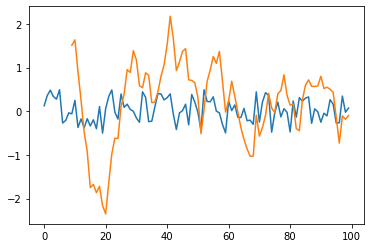

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
x = np.random.random(100)-0.5
df = pd.DataFrame({'x':x})
r = df.x.rolling(10).sum()
plt.plot(df.x)
plt.plot(r)
K=np.array(r)
K

In [63]:
x = np.random.random(100)
w = np.where(x>0.8)
w[0]

array([ 0,  3,  5,  6,  7,  8, 15, 19, 20, 25, 27, 29, 32, 34, 42, 44, 47,
       54, 60, 63, 72, 75, 78, 80, 83, 84, 85, 96, 99])

In [10]:
import numpy as np
x = np.arange(11)
w = np.where(x>4)
w[0]

array([ 5,  6,  7,  8,  9, 10])

In [87]:
import numpy as np
import pandas as pd
x = np.random.random(10)
z = pd.DataFrame({'x':x})
m = np.array(z['x'].rolling(3).sum())
m2 = m.squeeze()
print(x)
print(m2)
print(m2.shape)

[0.66628981 0.14838663 0.83759913 0.73531713 0.63617913 0.88136998
 0.96802447 0.27013699 0.81301238 0.79644973]
[       nan        nan 1.65227557 1.72130289 2.2090954  2.25286625
 2.48557359 2.11953145 2.05117384 1.8795991 ]
(10,)


In [100]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import run_cluster_cases
X = run_cluster_cases(sens=1,FAR=0,N=10,numCPUs=9,clinTF=True)


100%|██████████| 10/10 [00:00<00:00, 10729.86it/s]


   clinTF  sens  FAR  szCountWithout  szCountWith  drugCount
0     1.0   1.0  0.0           162.0        161.0        4.0
1     1.0   1.0  0.0             9.0          9.0        0.0
2     1.0   1.0  0.0           121.0        121.0        1.0
3     1.0   1.0  0.0           333.0        330.0       12.0
4     1.0   1.0  0.0           285.0        284.0       10.0
5     1.0   1.0  0.0            17.0         17.0        0.0
6     1.0   1.0  0.0           168.0        168.0        1.0
7     1.0   1.0  0.0            15.0         15.0        0.0
8     1.0   1.0  0.0           185.0        185.0        3.0
9     1.0   1.0  0.0            13.0         13.0        0.0


clinTF  sens  FAR  szCountWithout  szCountWith  drugCount
0     1.0   1.0  0.0           162.0        161.0        4.0
1     1.0   1.0  0.0             9.0          9.0        0.0
2     1.0   1.0  0.0           121.0        121.0        1.0
3     1.0   1.0  0.0           333.0        330.0       12.0
4     1.0   1.0  0.0           285.0        284.0       10.0
5     1.0   1.0  0.0            17.0         17.0        0.0
6     1.0   1.0  0.0           168.0        168.0        1.0
7     1.0   1.0  0.0            15.0         15.0        0.0
8     1.0   1.0  0.0           185.0        185.0        3.0
9     1.0   1.0  0.0            13.0         13.0        0.0

Inflater = 0.6666666666666666


trials: 100%|██████████| 10000/10000 [31:31<00:00,  5.29it/s]


Calculating wins = 32.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   900  535


trials: 100%|██████████| 10000/10000 [36:45<00:00,  4.53it/s]


Calculating wins = 37.0 minutes
Saving....
Threshold ...860. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05   860  535


trials: 100%|██████████| 10000/10000 [34:30<00:00,  4.83it/s]


Calculating wins = 35.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1   890  545


trials: 100%|██████████| 10000/10000 [36:52<00:00,  4.52it/s]


Calculating wins = 37.0 minutes
Saving....
Threshold ...865. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15   865  540


trials: 100%|██████████| 10000/10000 [36:04<00:00,  4.62it/s]


Calculating wins = 36.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2   890  535


trials: 100%|██████████| 10000/10000 [25:52<00:00,  6.44it/s]


Calculating wins = 26.0 minutes
Saving....
Threshold ...885. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   885  520


trials: 100%|██████████| 10000/10000 [30:08<00:00,  5.53it/s]


Calculating wins = 30.0 minutes
Saving....
Threshold ...845. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05   845  520


trials: 100%|██████████| 10000/10000 [28:28<00:00,  5.85it/s]


Calculating wins = 29.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1   900  535


trials: 100%|██████████| 10000/10000 [30:03<00:00,  5.54it/s]


Calculating wins = 30.0 minutes
Saving....
Threshold ...865. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15   865  535


trials: 100%|██████████| 10000/10000 [29:24<00:00,  5.67it/s]


Calculating wins = 29.0 minutes
Saving....
Threshold ...875. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2   875  530


trials: 100%|██████████| 10000/10000 [23:51<00:00,  6.99it/s]


Calculating wins = 24.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   890  530


trials: 100%|██████████| 10000/10000 [27:48<00:00,  5.99it/s]


Calculating wins = 28.0 minutes
Saving....
Threshold ...850. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05   850  530


trials: 100%|██████████| 10000/10000 [26:15<00:00,  6.35it/s]


Calculating wins = 26.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1   880  525


trials: 100%|██████████| 10000/10000 [27:58<00:00,  5.96it/s]


Calculating wins = 28.0 minutes
Saving....
Threshold ...860. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15   860  520


trials: 100%|██████████| 10000/10000 [27:25<00:00,  6.08it/s]


Calculating wins = 27.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2   880  520


trials: 100%|██████████| 10000/10000 [22:11<00:00,  7.51it/s]


Calculating wins = 22.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  520


trials: 100%|██████████| 10000/10000 [26:14<00:00,  6.35it/s]


Calculating wins = 26.0 minutes
Saving....
Threshold ...850. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05   850  525


trials: 100%|██████████| 10000/10000 [24:34<00:00,  6.78it/s]


Calculating wins = 25.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1   880  520


trials: 100%|██████████| 10000/10000 [26:19<00:00,  6.33it/s]


Calculating wins = 26.0 minutes
Saving....
Threshold ...860. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15   860  530


trials: 100%|██████████| 10000/10000 [25:08<00:00,  6.63it/s]


Calculating wins = 25.0 minutes
Saving....
Threshold ...875. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2   875  520


trials: 100%|██████████| 10000/10000 [19:18<00:00,  8.63it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  515


trials: 100%|██████████| 10000/10000 [23:53<00:00,  6.98it/s]


Calculating wins = 24.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05   820  510


trials: 100%|██████████| 10000/10000 [21:28<00:00,  7.76it/s]


Calculating wins = 22.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1   870  515


trials: 100%|██████████| 10000/10000 [22:51<00:00,  7.29it/s]


Calculating wins = 23.0 minutes
Saving....
Threshold ...850. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15   850  510


trials: 100%|██████████| 10000/10000 [22:15<00:00,  7.49it/s]


Calculating wins = 22.0 minutes
Saving....
Threshold ...865. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2   865  515
   sensitivity   FAR  RR50  MPC
0          0.5  0.00   900  535
0          0.5  0.05   860  535
0          0.5  0.10   890  545
0          0.5  0.15   865  540
0          0.5  0.20   890  535
0          0.7  0.00   885  520
0          0.7  0.05   845  520
0          0.7  0.10   900  535
0          0.7  0.15   865  535
0          0.7  0.20   875  530
0          0.8  0.00   890  530
0          0.8  0.05   850  530
0          0.8  0.10   880  525
0          0.8  0.15   860  520
0          0.8  0.20   880  520
0          0.9  0.00   880  520
0          0.9  0.05   850  525
0          0.9  0.10   880  520
0          0.9  0.15   860  530
0          0.9  0.20   875  520
0          1.0  0.00   870  515
0          1.0  0.05   820  510
0          1.0  0.10   870  515
0          1.0  0.15   850  510
0          1.0 

trials: 100%|██████████| 10000/10000 [16:51<00:00,  9.88it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...850. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   850  490


trials: 100%|██████████| 10000/10000 [19:57<00:00,  8.35it/s]


Calculating wins = 20.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05   800  500


trials: 100%|██████████| 10000/10000 [18:39<00:00,  8.93it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...840. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1   840  495


trials: 100%|██████████| 10000/10000 [19:50<00:00,  8.40it/s]


Calculating wins = 20.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15   805  495


trials: 100%|██████████| 10000/10000 [19:28<00:00,  8.56it/s]


Calculating wins = 20.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2   815  490


trials: 100%|██████████| 10000/10000 [14:25<00:00, 11.55it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   800  455


trials: 100%|██████████| 10000/10000 [16:42<00:00,  9.97it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...745. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05   745  460


trials: 100%|██████████| 10000/10000 [15:53<00:00, 10.48it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...830. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1   830  460


trials: 100%|██████████| 10000/10000 [16:53<00:00,  9.87it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...750. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15   750  460


trials: 100%|██████████| 10000/10000 [16:29<00:00, 10.10it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2   805  465


trials: 100%|██████████| 10000/10000 [13:40<00:00, 12.18it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   805  455


trials: 100%|██████████| 10000/10000 [15:51<00:00, 10.51it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...750. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05   750  455


trials: 100%|██████████| 10000/10000 [15:14<00:00, 10.93it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1   820  460


trials: 100%|██████████| 10000/10000 [15:47<00:00, 10.55it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...775. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15   775  455


trials: 100%|██████████| 10000/10000 [15:30<00:00, 10.74it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2   810  455


trials: 100%|██████████| 10000/10000 [13:15<00:00, 12.57it/s]


Calculating wins = 13.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   800  440


trials: 100%|██████████| 10000/10000 [15:07<00:00, 11.02it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...760. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05   760  440


trials: 100%|██████████| 10000/10000 [14:26<00:00, 11.54it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...840. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1   840  440


trials: 100%|██████████| 10000/10000 [15:03<00:00, 11.07it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...770. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15   770  440


trials: 100%|██████████| 10000/10000 [14:56<00:00, 11.15it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2   810  450


trials: 100%|██████████| 10000/10000 [11:58<00:00, 13.91it/s]


Calculating wins = 12.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   800  430


trials: 100%|██████████| 10000/10000 [14:08<00:00, 11.78it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...745. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05   745  430


trials: 100%|██████████| 10000/10000 [13:32<00:00, 12.31it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1   820  430


trials: 100%|██████████| 10000/10000 [14:17<00:00, 11.67it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...770. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15   770  430


trials: 100%|██████████| 10000/10000 [13:48<00:00, 12.06it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2   810  440
   sensitivity   FAR  RR50  MPC
0          0.5  0.00   850  490
0          0.5  0.05   800  500
0          0.5  0.10   840  495
0          0.5  0.15   805  495
0          0.5  0.20   815  490
0          0.7  0.00   800  455
0          0.7  0.05   745  460
0          0.7  0.10   830  460
0          0.7  0.15   750  460
0          0.7  0.20   805  465
0          0.8  0.00   805  455
0          0.8  0.05   750  455
0          0.8  0.10   820  460
0          0.8  0.15   775  455
0          0.8  0.20   810  455
0          0.9  0.00   800  440
0          0.9  0.05   760  440
0          0.9  0.10   840  440
0          0.9  0.15   770  440
0          0.9  0.20   810  450
0          1.0  0.00   800  430
0          1.0  0.05   745  430
0          1.0  0.10   820  430
0          1.0  0.15   770  430
0          1.0 

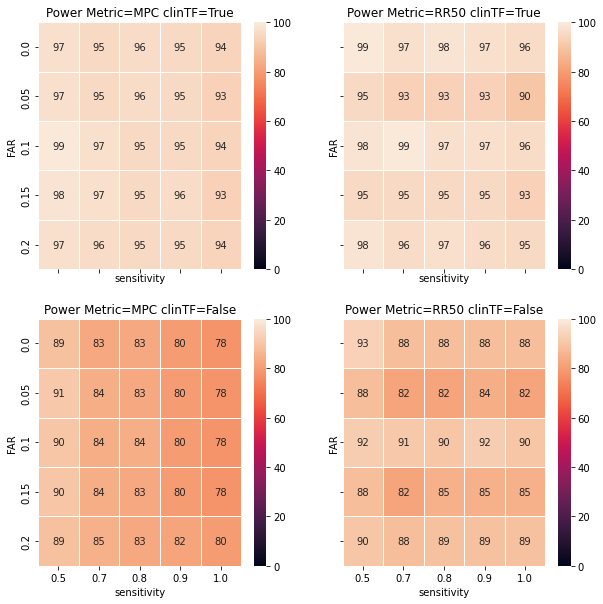

In [31]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
theREPS = 10000
for inflater in [2/3]:
    print(f'Inflater = {inflater}')
    fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))   
    for ci,clinTF in enumerate([True,False]):
    #for ci,clinTF in enumerate([True]):
        
        fn = f'accountNow_{clinTF}_inf{inflater}.csv'
        buildSET_of_N([.5,.7,.8,.9,1],[0,0.05,.1,.15,.2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=theREPS,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
        
        drawGrid(fn,clinTF=clinTF,ax=ax[ci,:])
        
    plt.show()

Inflater = 0.6666666666666666


trials: 100%|██████████| 10000/10000 [31:23<00:00,  5.31it/s]


Calculating wins = 31.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   900  545


trials: 100%|██████████| 10000/10000 [33:10<00:00,  5.02it/s]


Calculating wins = 33.0 minutes
Saving....
Threshold ...920. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.5   920  545


trials: 100%|██████████| 10000/10000 [32:55<00:00,  5.06it/s]


Calculating wins = 33.0 minutes
Saving....
Threshold ...945. runtime = 1.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    1   945  570


trials: 100%|██████████| 10000/10000 [31:06<00:00,  5.36it/s]


Calculating wins = 31.0 minutes
Saving....
Threshold ...1125. runtime = 1.0 minutes
Threshold ...660. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    2  1125  660


trials: 100%|██████████| 10000/10000 [25:02<00:00,  6.66it/s]


Calculating wins = 25.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   890  540


trials: 100%|██████████| 10000/10000 [27:19<00:00,  6.10it/s]


Calculating wins = 27.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5   900  540


trials: 100%|██████████| 10000/10000 [27:04<00:00,  6.16it/s]


Calculating wins = 27.0 minutes
Saving....
Threshold ...920. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    1   920  550


trials: 100%|██████████| 10000/10000 [25:55<00:00,  6.43it/s]


Calculating wins = 26.0 minutes
Saving....
Threshold ...1080. runtime = 1.0 minutes
Threshold ...620. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    2  1080  620


trials: 100%|██████████| 10000/10000 [22:14<00:00,  7.50it/s]


Calculating wins = 22.0 minutes
Saving....
Threshold ...885. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   885  520


trials: 100%|██████████| 10000/10000 [24:49<00:00,  6.72it/s]


Calculating wins = 25.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5   890  515


trials: 100%|██████████| 10000/10000 [24:57<00:00,  6.68it/s]


Calculating wins = 25.0 minutes
Saving....
Threshold ...930. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1   930  545


trials: 100%|██████████| 10000/10000 [23:00<00:00,  7.24it/s]


Calculating wins = 23.0 minutes
Saving....
Threshold ...1055. runtime = 1.0 minutes
Threshold ...615. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    2  1055  615


trials: 100%|██████████| 10000/10000 [19:07<00:00,  8.71it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  515


trials: 100%|██████████| 10000/10000 [21:23<00:00,  7.79it/s]


Calculating wins = 21.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5   880  520


trials: 100%|██████████| 10000/10000 [21:08<00:00,  7.88it/s]


Calculating wins = 21.0 minutes
Saving....
Threshold ...905. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   905  530


trials: 100%|██████████| 10000/10000 [20:39<00:00,  8.07it/s]


Calculating wins = 21.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2  1030  600
   sensitivity  FAR  RR50  MPC
0          0.5  0.0   900  545
0          0.5  0.5   920  545
0          0.5  1.0   945  570
0          0.5  2.0  1125  660
0          0.7  0.0   890  540
0          0.7  0.5   900  540
0          0.7  1.0   920  550
0          0.7  2.0  1080  620
0          0.9  0.0   885  520
0          0.9  0.5   890  515
0          0.9  1.0   930  545
0          0.9  2.0  1055  615
0          1.0  0.0   870  515
0          1.0  0.5   880  520
0          1.0  1.0   905  530
0          1.0  2.0  1030  600


trials: 100%|██████████| 10000/10000 [17:22<00:00,  9.59it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...825. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   825  495


trials: 100%|██████████| 10000/10000 [18:59<00:00,  8.77it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...830. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.5   830  500


trials: 100%|██████████| 10000/10000 [18:55<00:00,  8.81it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...865. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    1   865  510


trials: 100%|██████████| 10000/10000 [18:38<00:00,  8.94it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...960. runtime = 1.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    2   960  570


trials: 100%|██████████| 10000/10000 [14:37<00:00, 11.40it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   805  465


trials: 100%|██████████| 10000/10000 [16:13<00:00, 10.28it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5   810  460


trials: 100%|██████████| 10000/10000 [16:30<00:00, 10.09it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...475. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    1   820  475


trials: 100%|██████████| 10000/10000 [16:15<00:00, 10.26it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...910. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    2   910  525


trials: 100%|██████████| 10000/10000 [13:17<00:00, 12.54it/s]


Calculating wins = 13.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   810  440


trials: 100%|██████████| 10000/10000 [14:45<00:00, 11.29it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5   810  440


trials: 100%|██████████| 10000/10000 [14:49<00:00, 11.24it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1   820  450


trials: 100%|██████████| 10000/10000 [14:42<00:00, 11.33it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    2   880  495


trials: 100%|██████████| 10000/10000 [12:06<00:00, 13.77it/s]


Calculating wins = 12.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   805  430


trials: 100%|██████████| 10000/10000 [13:35<00:00, 12.27it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5   820  440


trials: 100%|██████████| 10000/10000 [13:27<00:00, 12.38it/s]


Calculating wins = 13.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   820  455


trials: 100%|██████████| 10000/10000 [13:18<00:00, 12.52it/s]


Calculating wins = 13.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2   880  490
   sensitivity  FAR  RR50  MPC
0          0.5  0.0   825  495
0          0.5  0.5   830  500
0          0.5  1.0   865  510
0          0.5  2.0   960  570
0          0.7  0.0   805  465
0          0.7  0.5   810  460
0          0.7  1.0   820  475
0          0.7  2.0   910  525
0          0.9  0.0   810  440
0          0.9  0.5   810  440
0          0.9  1.0   820  450
0          0.9  2.0   880  495
0          1.0  0.0   805  430
0          1.0  0.5   820  440
0          1.0  1.0   820  455
0          1.0  2.0   880  490


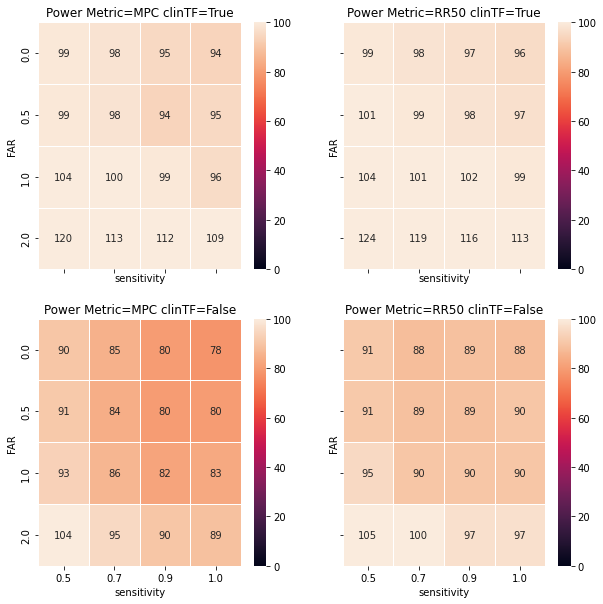

In [32]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
theREPS = 10000
for inflater in [2/3]:
    print(f'Inflater = {inflater}')
    fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))   
    for ci,clinTF in enumerate([True,False]):
    #for ci,clinTF in enumerate([True]):
        
        fn = f'accountNow-Bigger_{clinTF}_inf{inflater}.csv'
        buildSET_of_N([.5,.7,.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=theREPS,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
        
        drawGrid(fn,clinTF=clinTF,ax=ax[ci,:])
        
    plt.show()

In [33]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import make_full_RCT_sets
make_full_RCT_sets(drawingOn=False,prefix='testFAR0',sensLIST=[.4,.5,.6,.7,.8,.9,1],farLIST=[0],inflater=[2/3],mini=False)
    

Inflater = 0.6666666666666666


trials: 100%|██████████| 10000/10000 [19:11<00:00,  8.68it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...1125. runtime = 1.0 minutes
Threshold ...710. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4    0  1125  710


trials: 100%|██████████| 10000/10000 [17:17<00:00,  9.64it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...1070. runtime = 1.0 minutes
Threshold ...650. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0  1070  650


trials: 100%|██████████| 10000/10000 [18:46<00:00,  8.88it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...980. runtime = 1.0 minutes
Threshold ...580. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    0   980  580


trials: 100%|██████████| 10000/10000 [19:27<00:00,  8.56it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...945. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   945  575


trials: 100%|██████████| 10000/10000 [20:11<00:00,  8.26it/s]


Calculating wins = 20.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   890  540


trials: 100%|██████████| 10000/10000 [21:59<00:00,  7.58it/s]


Calculating wins = 22.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  520


trials: 100%|██████████| 10000/10000 [21:06<00:00,  7.90it/s]


Calculating wins = 21.0 minutes
Saving....
Threshold ...855. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   855  515
   sensitivity  FAR  RR50  MPC
0          0.4    0  1125  710
0          0.5    0  1070  650
0          0.6    0   980  580
0          0.7    0   945  575
0          0.8    0   890  540
0          0.9    0   880  520
0          1.0    0   855  515


trials: 100%|██████████| 10000/10000 [13:21<00:00, 12.47it/s]


Calculating wins = 13.0 minutes
Saving....
Threshold ...925. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4    0   925  545


trials: 100%|██████████| 10000/10000 [12:27<00:00, 13.37it/s]


Calculating wins = 12.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   880  510


trials: 100%|██████████| 10000/10000 [12:36<00:00, 13.21it/s]


Calculating wins = 13.0 minutes
Saving....
Threshold ...855. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    0   855  490


trials: 100%|██████████| 10000/10000 [13:08<00:00, 12.69it/s]


Calculating wins = 13.0 minutes
Saving....
Threshold ...840. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   840  460


trials: 100%|██████████| 10000/10000 [13:33<00:00, 12.29it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   815  450


trials: 100%|██████████| 10000/10000 [13:29<00:00, 12.36it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...445. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   805  445


trials: 100%|██████████| 10000/10000 [12:19<00:00, 13.52it/s]


Calculating wins = 12.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...420. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   795  420
   sensitivity  FAR  RR50  MPC
0          0.4    0   925  545
0          0.5    0   880  510
0          0.6    0   855  490
0          0.7    0   840  460
0          0.8    0   815  450
0          0.9    0   805  445
0          1.0    0   795  420


Inflater = 0.6666666666666666


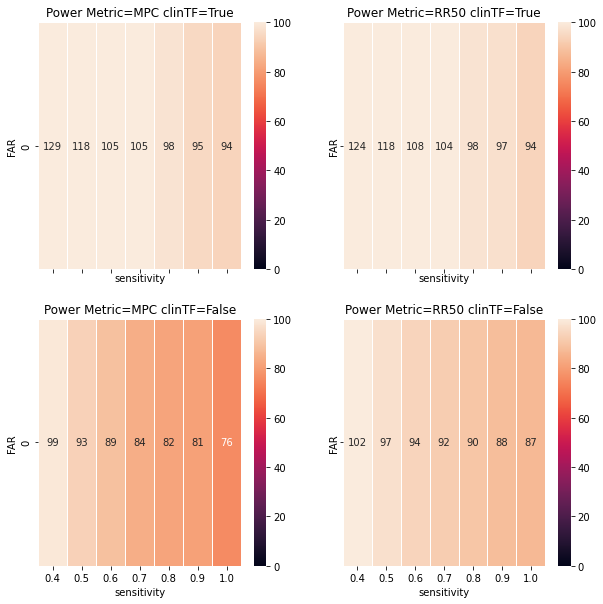

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import make_full_RCT_sets
make_full_RCT_sets(drawingOn=True,prefix='testFAR0',sensLIST=[.4,.5,.6,.7,.8,.9,1],farLIST=[0],inflater=[2/3],mini=False)
# this is what happens if accountForFAR=True,accountForSens=True

In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import make_full_RCT_sets
make_full_RCT_sets(drawingOn=False,prefix='testFAR0-noSensAcc',sensLIST=[.4,.5,.6,.7,.8,.9,1],farLIST=[0],inflater=[2/3],mini=False,accountForFAR=True,accountForSens=False)
make_full_RCT_sets(drawingOn=True,prefix='testFAR0-noSensAcc',sensLIST=[.4,.5,.6,.7,.8,.9,1],farLIST=[0],inflater=[2/3],mini=False,accountForFAR=True,accountForSens=False)
# this is what happens if accountForFAR=True,accountForSens=False


Inflater = 0.6666666666666666


trials: 100%|██████████| 10000/10000 [37:43<00:00,  4.42it/s]


Calculating wins = 38.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4    0   880  545


trials: 100%|██████████| 10000/10000 [32:51<00:00,  5.07it/s]


Calculating wins = 33.0 minutes
Saving....
Threshold ...895. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   895  530


trials:  39%|███▉      | 3924/10000 [11:29<16:58,  5.97it/s]Process LokyProcess-9:
Traceback (most recent call last):
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 483, in _process_worker
    gc.collect()
KeyboardInterrupt
Process LokyProcess-8:
Traceback (most recent call last):
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/danielgoldenholz/minif

KeyboardInterrupt: 

Even before finishing, it becomes VERY clear that the accounting for sensitivity is a BAD idea.

Inflater = 0.6666666666666666










trials:  39%|███▉      | 3941/10000 [4:25:46<6:48:37,  4.05s/it]

































































































































































































































































































































































































































































































































































































































































































































































































































































































































































Calculating wins = 38.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4    0   910  560


trials: 100%|██████████| 10000/10000 [44:11<00:00,  3.77it/s]


Calculating wins = 44.0 minutes
Saving....
Threshold ...860. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.4  0.05   860  540


trials: 100%|██████████| 10000/10000 [42:16<00:00,  3.94it/s]


Calculating wins = 42.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4  0.2   890  540


trials: 100%|██████████| 10000/10000 [38:58<00:00,  4.28it/s]


Calculating wins = 39.0 minutes
Saving....
Threshold ...900. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4  0.5   900  540


trials: 100%|██████████| 10000/10000 [40:09<00:00,  4.15it/s]


Calculating wins = 40.0 minutes
Saving....
Threshold ...940. runtime = 0.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4    1   940  570


trials: 100%|██████████| 10000/10000 [37:27<00:00,  4.45it/s]


Calculating wins = 38.0 minutes
Saving....
Threshold ...1130. runtime = 0.0 minutes
Threshold ...670. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4    2  1130  670


trials: 100%|██████████| 10000/10000 [26:28<00:00,  6.30it/s]


Calculating wins = 27.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1490. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.4    6  1490  1490


trials: 100%|██████████| 10000/10000 [31:02<00:00,  5.37it/s]


Calculating wins = 31.0 minutes
Saving....
Threshold ...900. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   900  540


trials: 100%|██████████| 10000/10000 [36:46<00:00,  4.53it/s]


Calculating wins = 37.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05   880  530


trials: 100%|██████████| 10000/10000 [35:53<00:00,  4.64it/s]


Calculating wins = 36.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2   890  540


trials: 100%|██████████| 10000/10000 [33:50<00:00,  4.93it/s]


Calculating wins = 34.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.5   910  540


trials: 100%|██████████| 10000/10000 [33:25<00:00,  4.99it/s]


Calculating wins = 33.0 minutes
Saving....
Threshold ...940. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    1   940  560


trials: 100%|██████████| 10000/10000 [31:57<00:00,  5.21it/s]


Calculating wins = 32.0 minutes
Saving....
Threshold ...1100. runtime = 0.0 minutes
Threshold ...670. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    2  1100  670


trials: 100%|██████████| 10000/10000 [24:35<00:00,  6.78it/s]


Calculating wins = 25.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1490. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    6  1490  1490


trials: 100%|██████████| 10000/10000 [27:38<00:00,  6.03it/s]


Calculating wins = 28.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    0   880  550


trials: 100%|██████████| 10000/10000 [32:59<00:00,  5.05it/s]


Calculating wins = 33.0 minutes
Saving....
Threshold ...860. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.6  0.05   860  530


trials: 100%|██████████| 10000/10000 [31:29<00:00,  5.29it/s]


Calculating wins = 32.0 minutes
Saving....
Threshold ...900. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6  0.2   900  540


trials: 100%|██████████| 10000/10000 [30:12<00:00,  5.52it/s]


Calculating wins = 30.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6  0.5   890  530


trials: 100%|██████████| 10000/10000 [29:38<00:00,  5.62it/s]


Calculating wins = 30.0 minutes
Saving....
Threshold ...950. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    1   950  560


trials: 100%|██████████| 10000/10000 [28:15<00:00,  5.90it/s]


Calculating wins = 28.0 minutes
Saving....
Threshold ...1080. runtime = 0.0 minutes
Threshold ...640. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    2  1080  640


trials: 100%|██████████| 10000/10000 [22:44<00:00,  7.33it/s]


Calculating wins = 23.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1490. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.6    6  1490  1490


trials: 100%|██████████| 10000/10000 [25:13<00:00,  6.61it/s]


Calculating wins = 25.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   890  530


trials: 100%|██████████| 10000/10000 [29:20<00:00,  5.68it/s]


Calculating wins = 29.0 minutes
Saving....
Threshold ...850. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05   850  530


trials: 100%|██████████| 10000/10000 [30:18<00:00,  5.50it/s]


Calculating wins = 30.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2   880  530


trials: 100%|██████████| 10000/10000 [30:16<00:00,  5.51it/s]


Calculating wins = 30.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5   910  540


trials: 100%|██████████| 10000/10000 [30:12<00:00,  5.52it/s]


Calculating wins = 30.0 minutes
Saving....
Threshold ...930. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    1   930  560


trials: 100%|██████████| 10000/10000 [27:26<00:00,  6.07it/s]


Calculating wins = 27.0 minutes
Saving....
Threshold ...1080. runtime = 0.0 minutes
Threshold ...630. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    2  1080  630


trials: 100%|██████████| 10000/10000 [22:06<00:00,  7.54it/s]


Calculating wins = 22.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    6  1490  1390


trials: 100%|██████████| 10000/10000 [23:16<00:00,  7.16it/s]


Calculating wins = 23.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   890  520


trials: 100%|██████████| 10000/10000 [27:42<00:00,  6.02it/s]


Calculating wins = 28.0 minutes
Saving....
Threshold ...850. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05   850  520


trials: 100%|██████████| 10000/10000 [26:59<00:00,  6.18it/s]


Calculating wins = 27.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2   880  520


trials: 100%|██████████| 10000/10000 [25:53<00:00,  6.44it/s]


Calculating wins = 26.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5   910  540


trials: 100%|██████████| 10000/10000 [26:52<00:00,  6.20it/s]


Calculating wins = 27.0 minutes
Saving....
Threshold ...940. runtime = 0.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    1   940  550


trials: 100%|██████████| 10000/10000 [25:47<00:00,  6.46it/s]


Calculating wins = 26.0 minutes
Saving....
Threshold ...1040. runtime = 0.0 minutes
Threshold ...620. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    2  1040  620


trials: 100%|██████████| 10000/10000 [21:58<00:00,  7.59it/s]


Calculating wins = 22.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1310. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    6  1490  1310


trials: 100%|██████████| 10000/10000 [24:02<00:00,  6.93it/s]


Calculating wins = 24.0 minutes
Saving....
Threshold ...870. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   870  510


trials: 100%|██████████| 10000/10000 [28:27<00:00,  5.86it/s]


Calculating wins = 29.0 minutes
Saving....
Threshold ...850. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05   850  510


trials: 100%|██████████| 10000/10000 [27:31<00:00,  6.05it/s]


Calculating wins = 28.0 minutes
Saving....
Threshold ...870. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2   870  520


trials: 100%|██████████| 10000/10000 [25:24<00:00,  6.56it/s]


Calculating wins = 25.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5   880  520


trials: 100%|██████████| 10000/10000 [25:41<00:00,  6.49it/s]


Calculating wins = 26.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1   910  550


trials: 100%|██████████| 10000/10000 [25:03<00:00,  6.65it/s]


Calculating wins = 25.0 minutes
Saving....
Threshold ...1030. runtime = 0.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    2  1030  600


trials: 100%|██████████| 10000/10000 [21:41<00:00,  7.68it/s]


Calculating wins = 22.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1230. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    6  1490  1230


trials: 100%|██████████| 10000/10000 [19:45<00:00,  8.44it/s]


Calculating wins = 20.0 minutes
Saving....
Threshold ...860. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   860  520


trials: 100%|██████████| 10000/10000 [23:44<00:00,  7.02it/s]


Calculating wins = 24.0 minutes
Saving....
Threshold ...840. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05   840  520


trials: 100%|██████████| 10000/10000 [23:24<00:00,  7.12it/s]


Calculating wins = 23.0 minutes
Saving....
Threshold ...860. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2   860  510


trials: 100%|██████████| 10000/10000 [21:29<00:00,  7.75it/s]


Calculating wins = 22.0 minutes
Saving....
Threshold ...870. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5   870  510


trials: 100%|██████████| 10000/10000 [22:15<00:00,  7.49it/s]


Calculating wins = 22.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   910  540


trials: 100%|██████████| 10000/10000 [21:31<00:00,  7.75it/s]


Calculating wins = 22.0 minutes
Saving....
Threshold ...1020. runtime = 0.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2  1020  600


trials: 100%|██████████| 10000/10000 [18:35<00:00,  8.96it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1170. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    6  1490  1170
   sensitivity   FAR  RR50   MPC
0          0.4  0.00   910   560
0          0.4  0.05   860   540
0          0.4  0.20   890   540
0          0.4  0.50   900   540
0          0.4  1.00   940   570
0          0.4  2.00  1130   670
0          0.4  6.00  1490  1490
0          0.5  0.00   900   540
0          0.5  0.05   880   530
0          0.5  0.20   890   540
0          0.5  0.50   910   540
0          0.5  1.00   940   560
0          0.5  2.00  1100   670
0          0.5  6.00  1490  1490
0          0.6  0.00   880   550
0          0.6  0.05   860   530
0          0.6  0.20   900   540
0          0.6  0.50   890   530
0          0.6  1.00   950   560
0          0.6  2.00  1080   640
0          0.6  6.00  1490  1490
0          0.7  0.00   890   530
0          0.7  0.05   850   530
0          0.7  0.2

trials: 100%|██████████| 10000/10000 [19:40<00:00,  8.47it/s]


Calculating wins = 20.0 minutes
Saving....
Threshold ...850. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4    0   850  510


trials: 100%|██████████| 10000/10000 [23:34<00:00,  7.07it/s]


Calculating wins = 24.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.4  0.05   820  510


trials: 100%|██████████| 10000/10000 [23:33<00:00,  7.08it/s]


Calculating wins = 24.0 minutes
Saving....
Threshold ...850. runtime = 0.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4  0.2   850  500


trials: 100%|██████████| 10000/10000 [23:23<00:00,  7.13it/s]


Calculating wins = 23.0 minutes
Saving....
Threshold ...850. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4  0.5   850  510


trials: 100%|██████████| 10000/10000 [22:37<00:00,  7.37it/s]


Calculating wins = 23.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4    1   910  530


trials: 100%|██████████| 10000/10000 [20:47<00:00,  8.02it/s]


Calculating wins = 21.0 minutes
Saving....
Threshold ...1020. runtime = 0.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.4    2  1020  590


trials: 100%|██████████| 10000/10000 [18:07<00:00,  9.19it/s]


Calculating wins = 18.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1120. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.4    6  1490  1120


trials: 100%|██████████| 10000/10000 [16:57<00:00,  9.83it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...830. runtime = 0.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   830  500


trials: 100%|██████████| 10000/10000 [20:18<00:00,  8.21it/s]


Calculating wins = 20.0 minutes
Saving....
Threshold ...780. runtime = 0.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05   780  500


trials: 100%|██████████| 10000/10000 [20:12<00:00,  8.25it/s]


Calculating wins = 20.0 minutes
Saving....
Threshold ...840. runtime = 0.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2   840  500


trials: 100%|██████████| 10000/10000 [19:29<00:00,  8.55it/s]


Calculating wins = 20.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.5   820  490


trials: 100%|██████████| 10000/10000 [19:23<00:00,  8.60it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...850. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    1   850  510


trials: 100%|██████████| 10000/10000 [18:47<00:00,  8.87it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...990. runtime = 0.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    2   990  570


trials: 100%|██████████| 10000/10000 [17:00<00:00,  9.80it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1000. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    6  1490  1000


trials: 100%|██████████| 10000/10000 [15:39<00:00, 10.64it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...810. runtime = 0.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    0   810  470


trials: 100%|██████████| 10000/10000 [18:55<00:00,  8.81it/s]


Calculating wins = 19.0 minutes
Saving....
Threshold ...780. runtime = 0.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.6  0.05   780  470


trials: 100%|██████████| 10000/10000 [17:53<00:00,  9.32it/s]


Calculating wins = 18.0 minutes
Saving....
Threshold ...810. runtime = 0.0 minutes
Threshold ...480. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6  0.2   810  480


trials: 100%|██████████| 10000/10000 [17:31<00:00,  9.51it/s]


Calculating wins = 18.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...480. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6  0.5   820  480


trials: 100%|██████████| 10000/10000 [17:45<00:00,  9.38it/s]


Calculating wins = 18.0 minutes
Saving....
Threshold ...840. runtime = 0.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    1   840  500


trials: 100%|██████████| 10000/10000 [16:53<00:00,  9.87it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...940. runtime = 0.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    2   940  550


trials: 100%|██████████| 10000/10000 [16:11<00:00, 10.30it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...930. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    6  1490  930


trials: 100%|██████████| 10000/10000 [14:56<00:00, 11.16it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...800. runtime = 0.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   800  450


trials: 100%|██████████| 10000/10000 [17:10<00:00,  9.70it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...760. runtime = 0.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05   760  470


trials: 100%|██████████| 10000/10000 [16:39<00:00, 10.00it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...800. runtime = 0.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2   800  470


trials: 100%|██████████| 10000/10000 [16:07<00:00, 10.33it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...810. runtime = 0.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5   810  470


trials: 100%|██████████| 10000/10000 [16:46<00:00,  9.93it/s]


Calculating wins = 17.0 minutes
Saving....
Threshold ...830. runtime = 0.0 minutes
Threshold ...480. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    1   830  480


trials: 100%|██████████| 10000/10000 [16:01<00:00, 10.40it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...920. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    2   920  530


trials: 100%|██████████| 10000/10000 [15:23<00:00, 10.83it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...870. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    6  1490  870


trials: 100%|██████████| 10000/10000 [13:56<00:00, 11.96it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   820  460


trials: 100%|██████████| 10000/10000 [16:25<00:00, 10.15it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...760. runtime = 0.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05   760  450


trials: 100%|██████████| 10000/10000 [15:58<00:00, 10.44it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...810. runtime = 0.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2   810  460


trials: 100%|██████████| 10000/10000 [15:22<00:00, 10.84it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...800. runtime = 0.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5   800  450


trials: 100%|██████████| 10000/10000 [15:38<00:00, 10.65it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    1   820  460


trials: 100%|██████████| 10000/10000 [15:33<00:00, 10.71it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...900. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    2   900  520


trials: 100%|██████████| 10000/10000 [15:04<00:00, 11.05it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...1420. runtime = 1.0 minutes
Threshold ...820. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    6  1420  820


trials: 100%|██████████| 10000/10000 [13:22<00:00, 12.46it/s]


Calculating wins = 13.0 minutes
Saving....
Threshold ...810. runtime = 0.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   810  440


trials: 100%|██████████| 10000/10000 [15:41<00:00, 10.63it/s]


Calculating wins = 16.0 minutes
Saving....
Threshold ...760. runtime = 0.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05   760  440


trials: 100%|██████████| 10000/10000 [15:03<00:00, 11.07it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...810. runtime = 0.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2   810  450


trials: 100%|██████████| 10000/10000 [14:36<00:00, 11.41it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...810. runtime = 0.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5   810  450


trials: 100%|██████████| 10000/10000 [14:38<00:00, 11.38it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1   820  450


trials: 100%|██████████| 10000/10000 [15:03<00:00, 11.07it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    2   880  490


trials: 100%|██████████| 10000/10000 [14:50<00:00, 11.23it/s]


Calculating wins = 15.0 minutes
Saving....
Threshold ...1360. runtime = 1.0 minutes
Threshold ...780. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    6  1360  780


trials: 100%|██████████| 10000/10000 [12:06<00:00, 13.76it/s]


Calculating wins = 12.0 minutes
Saving....
Threshold ...810. runtime = 0.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   810  430


trials: 100%|██████████| 10000/10000 [13:59<00:00, 11.91it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...740. runtime = 0.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05   740  430


trials: 100%|██████████| 10000/10000 [14:01<00:00, 11.88it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...800. runtime = 0.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2   800  440


trials: 100%|██████████| 10000/10000 [13:25<00:00, 12.42it/s]


Calculating wins = 13.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5   820  430


trials: 100%|██████████| 10000/10000 [13:23<00:00, 12.44it/s]


Calculating wins = 13.0 minutes
Saving....
Threshold ...830. runtime = 0.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   830  440


trials: 100%|██████████| 10000/10000 [13:50<00:00, 12.04it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2   890  490


trials: 100%|██████████| 10000/10000 [14:11<00:00, 11.74it/s]


Calculating wins = 14.0 minutes
Saving....
Threshold ...1320. runtime = 1.0 minutes
Threshold ...730. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    6  1320  730
   sensitivity   FAR  RR50   MPC
0          0.4  0.00   850   510
0          0.4  0.05   820   510
0          0.4  0.20   850   500
0          0.4  0.50   850   510
0          0.4  1.00   910   530
0          0.4  2.00  1020   590
0          0.4  6.00  1490  1120
0          0.5  0.00   830   500
0          0.5  0.05   780   500
0          0.5  0.20   840   500
0          0.5  0.50   820   490
0          0.5  1.00   850   510
0          0.5  2.00   990   570
0          0.5  6.00  1490  1000
0          0.6  0.00   810   470
0          0.6  0.05   780   470
0          0.6  0.20   810   480
0          0.6  0.50   820   480
0          0.6  1.00   840   500
0          0.6  2.00   940   550
0          0.6  6.00  1490   930
0          0.7  0.00   800   450
0          0.7  0.05   760   470
0          0.7  0.20  

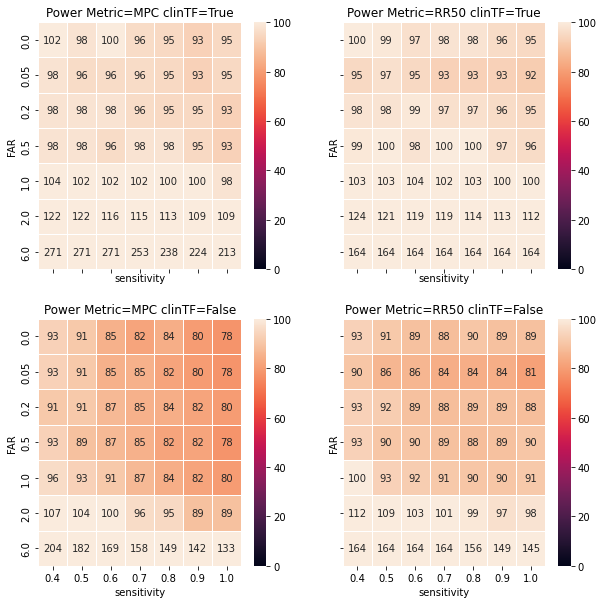

In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import make_full_RCT_sets
make_full_RCT_sets(drawingOn=False,prefix='FARcorrBigRun',sensLIST=[.4,.5,.6,.7,.8,.9,1],farLIST=[0,.05,.2,.5,1,2,6],inflater=[2/3],mini=False,accountForFAR=True,accountForSens=False)
make_full_RCT_sets(drawingOn=True,prefix='FARcorrBigRun',sensLIST=[.4,.5,.6,.7,.8,.9,1],farLIST=[0,.05,.2,.5,1,2,6],inflater=[2/3],mini=False,accountForFAR=True,accountForSens=False)
# this is what happens if accountForFAR=True,accountForSens=False

In [ ]:
# testing out the zeroMean and inflater stuff

import numpy as np
import matplotlib.pyplot as plt
reps = 1000000
zeroMean = np.zeros(reps)

for K in range(reps):
    downsampleRATE = 28
    downsampleRATEhalf = downsampleRATE/2
    FAR = 1
    inflater = 10
    x = np.random.random(downsampleRATE)
    zeroMean[K] = FAR*inflater*(np.sum(x) - downsampleRATEhalf)
plt.hist(zeroMean,bins=1000)
print(f'mean = {np.mean(zeroMean)} median = {np.median(zeroMean)} stdev = {np.std(zeroMean)}')

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

p = pd.read_csv('clinicMonster.csv')
p

sens       FAR   szfree  meanDrug    meanSz
0    1.0  0.000000  0.62813  4.102564  1.068376
1    1.0  0.011111  0.62678  4.102564  1.068376
2    1.0  0.033333  0.62696  4.102564  1.068376
3    1.0  0.111111  0.63038  4.102564  1.059829
4    1.0  0.333333  0.63468  4.205128  1.051282
5    1.0  1.000000  0.63466  4.256410  1.059829
6    1.0  3.000000  0.63432  4.153846  1.102564
7    0.9  0.000000  0.62829  4.076923  1.068376
8    0.9  0.011111  0.62441  4.076923  1.059829
9    0.9  0.033333  0.62837  4.076923  1.059829
10   0.9  0.111111  0.62745  4.076923  1.068376
11   0.9  0.333333  0.63341  4.179487  1.068376
12   0.9  1.000000  0.63388  4.230769  1.068376
13   0.9  3.000000  0.63668  4.128205  1.119658
14   0.8  0.000000  0.62755  4.025641  1.059829
15   0.8  0.011111  0.62585  4.025641  1.076923
16   0.8  0.033333  0.62803  4.025641  1.068376
17   0.8  0.111111  0.62694  4.051282  1.068376
18   0.8  0.333333  0.63563  4.153846  1.076923
19   0.8  1.000000  0.63426  4.205128  1.076923
20   0.8  3.000000  0.63207  4.128205  1.128205
21   0.7  0.000000  0.62271  4.000000  1.094017
22   0.7  0.011111  0.62697  4.000000  1.094017
23   0.7  0.033333  0.62495  4.000000  1.085470
24   0.7  0.111111  0.62565  4.000000  1.076923
25   0.7  0.333333  0.63406  4.102564  1.068376
26   0.7  1.000000  0.63638  4.179487  1.094017
27   0.7  3.000000  0.63732  4.076923  1.136752
28   0.6  0.000000  0.62173  3.948718  1.094017
29   0.6  0.011111  0.62357  3.923077  1.085470
30   0.6  0.033333  0.62616  3.948718  1.085470
31   0.6  0.111111  0.62456  3.948718  1.094017
32   0.6  0.333333  0.63374  4.076923  1.085470
33   0.6  1.000000  0.63232  4.128205  1.094017
34   0.6  3.000000  0.63355  4.051282  1.162393
35   0.5  0.000000  0.62100  3.846154  1.094017
36   0.5  0.011111  0.62116  3.871795  1.102564
37   0.5  0.033333  0.62037  3.846154  1.094017
38   0.5  0.111111  0.62020  3.871795  1.094017
39   0.5  0.333333  0.63131  4.000000  1.094017
40   0.5  1.000000  0.63190  4.102564  1.128205
41   0.5  3.000000  0.63425  4.000000  1.196581

KeyError: 0